In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scvi
import scanpy as sc
import seaborn as sb


from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


1. Predict gene scores for selected gene set (e.g. adaptive NK cell markers) using surface protein data

2. Check surface protein data (removing zeros, distribution, correlations)

3. Constructing df containing calculated gene scores + protein data

4. Model:
    - define test and train sets
    - hyperparameter search (which parameters should be used?) 
    - record training scores
    - record the performance of the tuned model on test set
    - predict

5. Feature importances (to find important markers)


In [100]:
#loading Neurips dataset
adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [101]:
adata_neurips

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [102]:
adata_neurips.obs['Site'].unique().tolist()

['site4', 'site3', 'site1', 'site2']

In [103]:
#selecting only sites 1 and 4 (showed good ab signals), from Neurips dataset

eg=adata_neurips[(adata_neurips.obs['Site'] == "site4") | (adata_neurips.obs['Site'] == "site1")].copy() 

In [104]:
eg.obs['Site'].unique().tolist()

['site4', 'site1']

In [105]:
eg

AnnData object with n_obs × n_vars = 28418 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [106]:
#selecting only NK cells, gd T cells and ILCs using Neurips annotations

eg_nk = eg[(eg.obs['cell_type'] == "NK") | (eg.obs['cell_type'] == "NK CD158e1+")].copy()   


In [107]:
eg_nk.obs['cell_type'].unique().tolist()

['NK', 'NK CD158e1+']

In [108]:
#This includes now selected cells (NK, ILC, gd T) from site 1 and 4
eg_nk

AnnData object with n_obs × n_vars = 2640 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

## Calculating gene scores for gene sets

### Yang et al. gene sets 

In [109]:
is_nk_yang = ['KLRD1', 'KLRF1', 'NKG7', 'GNLY', 'NCAM1'] #the most DE genes in NK cells

In [110]:
#calculating scores for gene set

sc.tl.score_genes(eg_nk, is_nk_yang, score_name = 'isnk_score_yang')


/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [111]:
eg_nk

AnnData object with n_obs × n_vars = 2640 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'isnk_score_yang'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [112]:
cd56bright_rna_yang= ['IL7R', 'SELL', 'KLRC1', 'GZMK', 'CD44', 'XCL1', 'XCL2']

In [113]:
#calculating scores for gene set

sc.tl.score_genes(eg_nk, cd56bright_rna_yang, score_name = 'cd56bright_rna_yang_score')

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [114]:
eg_nk

AnnData object with n_obs × n_vars = 2640 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'isnk_score_yang', 'cd56bright_rna_yang_score'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [115]:
adaptive_high_yang = ['KLRC2', 'CD52', 'CD3E', 'CD3D', 'CD3G', 'IL32' ]

In [116]:
#calculating scores for gene set

sc.tl.score_genes(eg_nk, adaptive_high_yang, score_name = 'adaptive_high_yang_score')

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [117]:
eg_nk.obs['adaptive_high_yang_score']

GTAGTACCAATCCTTT-1-s4d1   -0.215344
CTGTGGGTCATGCGGC-1-s4d1    0.730587
GCAACATTCGCAAGAG-1-s4d1   -0.008196
TCACGGGTCGCACGAC-1-s4d1    0.144210
CGCCAGAAGACCATTC-1-s4d1    0.091737
                             ...   
ATCATTCGTCCAATCA-1-s1d3   -0.489534
ACATTTCCAGCAGTGA-1-s1d3   -0.260910
TGAGACTTCCTTCAGC-1-s1d3   -0.264678
GAGATGGTCCGCCTAT-1-s1d3    0.113583
ACCTGTCTCACAGTGT-1-s1d3   -0.039293
Name: adaptive_high_yang_score, Length: 2640, dtype: float64

In [118]:
prot = eg_nk.obsm['protein_expression_clr_neurips']

In [119]:
prot

CD86     CD274     CD270     CD155     CD112  \
GTAGTACCAATCCTTT-1-s4d1  0.652674  1.447594  1.489354  0.890243  1.290341   
CTGTGGGTCATGCGGC-1-s4d1  0.378666  1.132949  1.153412  0.730824  1.195368   
GCAACATTCGCAAGAG-1-s4d1  0.378666  1.192753  1.208881  0.000000  1.456877   
TCACGGGTCGCACGAC-1-s4d1  0.000000  0.849902  1.548700  0.730824  1.530781   
CGCCAGAAGACCATTC-1-s4d1  0.652674  1.249182  1.404314  0.306698  1.417770   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.000000  0.568367  1.124479  1.027708  0.600556   
ACATTTCCAGCAGTGA-1-s1d3  0.000000  0.671273  0.856802  0.000000  0.284617   
TGAGACTTCCTTCAGC-1-s1d3  0.000000  0.671273  0.734526  0.306698  0.284617   
GAGATGGTCCGCCTAT-1-s1d3  0.000000  0.928521  0.999570  0.541080  0.600556   
ACCTGTCTCACAGTGT-1-s1d3  0.652674  0.175083  0.856802  0.000000  0.284617   

                             CD47      CD48      CD40     CD154      CD52  \
GTAGTACCAATCCTTT-1-s4d1  1.988618  1.733474  0.850004  1.531390  0.694828   
CTGTGGGTCATGCGGC-1-s4d1  1.546005  1.090567  1.173337  1.303511  1.013739   
GCAACATTCGCAAGAG-1-s4d1  1.046035  1.333993  0.638218  1.360894  1.072649   
TCACGGGTCGCACGAC-1-s4d1  1.883102  1.686271  1.240123  1.804089  0.812797   
CGCCAGAAGACCATTC-1-s4d1  1.664855  1.409627  1.302726  1.663363  0.849218   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  2.007513  1.679342  0.749707  0.545181  0.288523   
ACATTTCCAGCAGTGA-1-s1d3  1.105431  0.818721  0.201533  0.309292  0.652195   
TGAGACTTCCTTCAGC-1-s1d3  1.255114  1.174628  0.749707  0.625887  0.406586   
GAGATGGTCCGCCTAT-1-s1d3  1.759143  2.420602  1.024682  0.700563  0.406586   
ACCTGTCTCACAGTGT-1-s1d3  1.193686  0.866867  0.512721  0.457384  0.775000   

                         ...     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  ...  1.532575  0.614600  0.900688  1.389844   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.344431  0.353792  0.860303  0.979461   
GCAACATTCGCAAGAG-1-s4d1  ...  1.218539  0.670407  0.329073  1.280509   
TCACGGGTCGCACGAC-1-s4d1  ...  1.456232  0.614600  0.576253  1.189870   
CGCCAGAAGACCATTC-1-s4d1  ...  1.556781  0.276377  0.680162  1.415407   
...                      ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  ...  1.556781  0.353792  0.519947  0.809714   
ACATTTCCAGCAGTGA-1-s1d3  ...  0.950948  0.555495  0.519947  0.546717   
TGAGACTTCCTTCAGC-1-s1d3  ...  0.374154  0.492675  0.396827  0.418509   
GAGATGGTCCGCCTAT-1-s1d3  ...  1.532575  0.555495  0.576253  0.546717   
ACCTGTCTCACAGTGT-1-s1d3  ...  0.758186  0.276377  0.396827  0.418509   

                            CD224  CD197  CD34  CD10  CD90  CD15  
GTAGTACCAATCCTTT-1-s4d1  0.918109    0.0   0.0   0.0   0.0   0.0  
CTGTGGGTCATGCGGC-1-s4d1  1.147198    0.0   0.0   0.0   0.0   0.0  
GCAACATTCGCAAGAG-1-s4d1  0.676616    0.0   0.0   0.0   0.0   0.0  
TCACGGGTCGCACGAC-1-s4d1  1.000442    0.0   0.0   0.0   0.0   0.0  
CGCCAGAAGACCATTC-1-s4d1  0.729806    0.0   0.0   0.0   0.0   0.0  
...                           ...    ...   ...   ...   ...   ...  
ATCATTCGTCCAATCA-1-s1d3  0.357584    0.0   0.0   0.0   0.0   0.0  
ACATTTCCAGCAGTGA-1-s1d3  0.194691    0.0   0.0   0.0   0.0   0.0  
TGAGACTTCCTTCAGC-1-s1d3  0.000000    0.0   0.0   0.0   0.0   0.0  
GAGATGGTCCGCCTAT-1-s1d3  0.430053    0.0   0.0   0.0   0.0   0.0  
ACCTGTCTCACAGTGT-1-s1d3  0.780309    0.0   0.0   0.0   0.0   0.0  

[2640 rows x 139 columns]

In [23]:
#dropping columns containing only zeros

prot = prot.loc[:, (prot!=0).any(axis=0)]

In [24]:
prot

CD86     CD274     CD270     CD155     CD112  \
GTAGTACCAATCCTTT-1-s4d1  0.652674  1.447594  1.489354  0.890243  1.290341   
CTGTGGGTCATGCGGC-1-s4d1  0.378666  1.132949  1.153412  0.730824  1.195368   
GCAACATTCGCAAGAG-1-s4d1  0.378666  1.192753  1.208881  0.000000  1.456877   
TCACGGGTCGCACGAC-1-s4d1  0.000000  0.849902  1.548700  0.730824  1.530781   
CGCCAGAAGACCATTC-1-s4d1  0.652674  1.249182  1.404314  0.306698  1.417770   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.000000  0.568367  1.124479  1.027708  0.600556   
ACATTTCCAGCAGTGA-1-s1d3  0.000000  0.671273  0.856802  0.000000  0.284617   
TGAGACTTCCTTCAGC-1-s1d3  0.000000  0.671273  0.734526  0.306698  0.284617   
GAGATGGTCCGCCTAT-1-s1d3  0.000000  0.928521  0.999570  0.541080  0.600556   
ACCTGTCTCACAGTGT-1-s1d3  0.652674  0.175083  0.856802  0.000000  0.284617   

                             CD47      CD48      CD40     CD154      CD52  \
GTAGTACCAATCCTTT-1-s4d1  1.988618  1.733474  0.850004  1.531390  0.694828   
CTGTGGGTCATGCGGC-1-s4d1  1.546005  1.090567  1.173337  1.303511  1.013739   
GCAACATTCGCAAGAG-1-s4d1  1.046035  1.333993  0.638218  1.360894  1.072649   
TCACGGGTCGCACGAC-1-s4d1  1.883102  1.686271  1.240123  1.804089  0.812797   
CGCCAGAAGACCATTC-1-s4d1  1.664855  1.409627  1.302726  1.663363  0.849218   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  2.007513  1.679342  0.749707  0.545181  0.288523   
ACATTTCCAGCAGTGA-1-s1d3  1.105431  0.818721  0.201533  0.309292  0.652195   
TGAGACTTCCTTCAGC-1-s1d3  1.255114  1.174628  0.749707  0.625887  0.406586   
GAGATGGTCCGCCTAT-1-s1d3  1.759143  2.420602  1.024682  0.700563  0.406586   
ACCTGTCTCACAGTGT-1-s1d3  1.193686  0.866867  0.512721  0.457384  0.775000   

                         ...      CD94     CD162     CD85j      CD23  \
GTAGTACCAATCCTTT-1-s4d1  ...  2.475005  1.804603  1.069921  1.496785   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.408073  1.772872  0.890506  1.188863   
GCAACATTCGCAAGAG-1-s4d1  ...  2.174035  1.013704  1.148843  1.332566   
TCACGGGTCGCACGAC-1-s4d1  ...  3.016060  1.587440  1.623280  1.552023   
CGCCAGAAGACCATTC-1-s4d1  ...  2.826218  2.465725  1.524077  1.637802   
...                      ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  ...  4.481286  2.345961  0.391222  0.700530   
ACATTTCCAGCAGTGA-1-s1d3  ...  2.122566  1.496074  0.391222  0.410393   
TGAGACTTCCTTCAGC-1-s1d3  ...  0.365443  1.296756  0.214622  0.410393   
GAGATGGTCCGCCTAT-1-s1d3  ...  2.986818  1.976363  0.214622  0.990050   
ACCTGTCTCACAGTGT-1-s1d3  ...  4.033146  2.040049  0.541266  0.226103   

                            CD328     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  2.696518  1.532575  0.614600  0.900688  1.389844   
CTGTGGGTCATGCGGC-1-s4d1  2.678422  1.344431  0.353792  0.860303  0.979461   
GCAACATTCGCAAGAG-1-s4d1  0.000000  1.218539  0.670407  0.329073  1.280509   
TCACGGGTCGCACGAC-1-s4d1  2.164676  1.456232  0.614600  0.576253  1.189870   
CGCCAGAAGACCATTC-1-s4d1  3.066941  1.556781  0.276377  0.680162  1.415407   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  4.391692  1.556781  0.353792  0.519947  0.809714   
ACATTTCCAGCAGTGA-1-s1d3  2.678422  0.950948  0.555495  0.519947  0.546717   
TGAGACTTCCTTCAGC-1-s1d3  3.910620  0.374154  0.492675  0.396827  0.418509   
GAGATGGTCCGCCTAT-1-s1d3  1.800479  1.532575  0.555495  0.576253  0.546717   
ACCTGTCTCACAGTGT-1-s1d3  3.336630  0.758186  0.276377  0.396827  0.418509   

                            CD224  
GTAGTACCAATCCTTT-1-s4d1  0.918109  
CTGTGGGTCATGCGGC-1-s4d1  1.147198  
GCAACATTCGCAAGAG-1-s4d1  0.676616  
TCACGGGTCGCACGAC-1-s4d1  1.000442  
CGCCAGAAGACCATTC-1-s4d1  0.729806  
...                           ...  
ATCATTCGTCCAATCA-1-s1d3  0.357584  
ACATTTCCAGCAGTGA-1-s1d3  0.194691  
TGAGACTTCCTTCAGC-1-s1d3  0.000000  
GAGATGGTCCGCCTAT-1-s1d3  0.43

In [25]:
prot.describe()

CD86        CD274        CD270        CD155        CD112  \
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000   
mean      0.259739     1.044477     1.077427     0.575894     0.826136   
std       0.328835     0.675683     0.335722     0.379068     0.415217   
min       0.000000     0.000000     0.166149     0.000000     0.000000   
25%       0.000000     0.453643     0.856802     0.306698     0.505917   
50%       0.000000     1.001407     1.063974     0.541080     0.766577   
75%       0.378666     1.491603     1.311364     0.890243     1.144269   
max       4.037784     7.179674     6.503963     3.066146     2.308017   

              CD47         CD48         CD40        CD154         CD52  ...  \
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000  ...   
mean      1.593414     1.468572     0.757240     0.989188     0.785021  ...   
std       0.436319     0.447961     0.374219     0.417811     0.421535  ...   
min       0.349275     0.201874     0.000000     0.000000     0.000000  ...   
25%       1.303571     1.151323     0.512721     0.663922     0.512170  ...   
50%       1.560743     1.418692     0.749707     0.925184     0.735717  ...   
75%       1.852154     1.726866     1.024682     1.323007     1.013739  ...   
max       3.565268     4.167115     2.040997     2.384986     2.846132  ...   

              CD94        CD162        CD85j         CD23        CD328  \
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000   
mean      2.695500     1.842853     0.708465     0.999731     2.870358   
std       1.222390     0.656122     0.419833     0.419200     0.942209   
min       0.257817     0.000000     0.000000     0.081182     0.000000   
25%       1.660982     1.407198     0.391222     0.657651     2.332854   
50%       2.591687     1.879785     0.671706     0.958123     2.948787   
75%       3.670459     2.322979     0.984231     1.332566     3.517752   
max       5.781869     4.388661     2.238449     3.030348     5.379574   

             HLA-E         CD82        CD101         CD88        CD224  
count  2640.000000  2640.000000  2640.000000  2640.000000  2640.000000  
mean      1.253904     0.504434     0.574611     0.820453     0.738894  
std       0.366789     0.279724     0.305433     0.321915     0.430546  
min       0.204475     0.000000     0.000000     0.000000     0.000000  
25%       0.993845     0.353792     0.329073     0.605141     0.430053  
50%       1.251529     0.492675     0.519947     0.809714     0.729806  
75%       1.482333     0.614600     0.728330     1.054625     1.000442  
max       2.666251     3.958134     2.975896     3.458393     2.980588  

[8 rows x 134 columns]

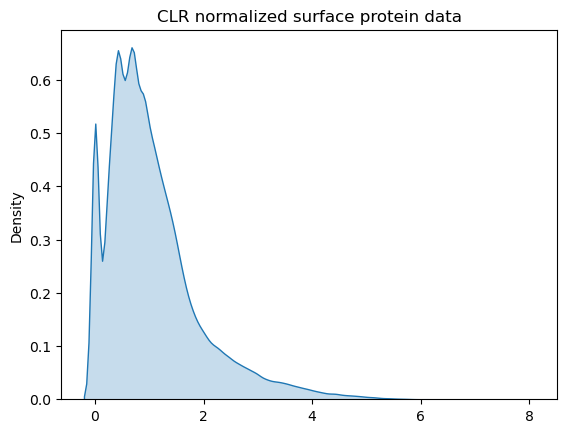

In [26]:
flatten_df = prot.to_numpy().flatten()

sb.kdeplot(flatten_df, fill = True) ; 


plt.title("CLR normalized surface protein data") ;

In [27]:
adaptive_score_yang = eg_nk.obs['adaptive_high_yang_score']

In [28]:
adaptive_score_yang

GTAGTACCAATCCTTT-1-s4d1   -0.215344
CTGTGGGTCATGCGGC-1-s4d1    0.730587
GCAACATTCGCAAGAG-1-s4d1   -0.008196
TCACGGGTCGCACGAC-1-s4d1    0.144210
CGCCAGAAGACCATTC-1-s4d1    0.091737
                             ...   
ATCATTCGTCCAATCA-1-s1d3   -0.489534
ACATTTCCAGCAGTGA-1-s1d3   -0.260910
TGAGACTTCCTTCAGC-1-s1d3   -0.264678
GAGATGGTCCGCCTAT-1-s1d3    0.113583
ACCTGTCTCACAGTGT-1-s1d3   -0.039293
Name: adaptive_high_yang_score, Length: 2640, dtype: float64

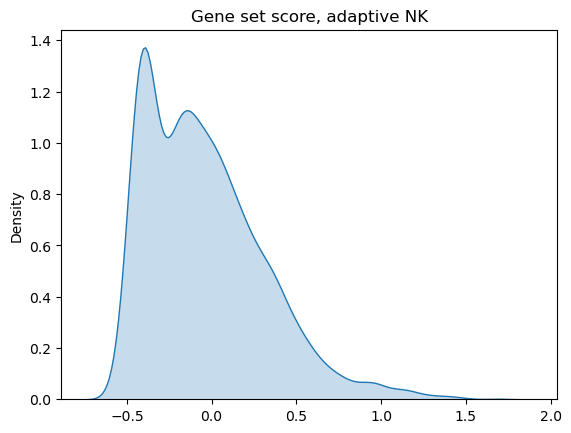

In [29]:
flatten_df1 = adaptive_score_yang.to_numpy().flatten()

sb.kdeplot(flatten_df1, fill = True) ; 

plt.title("Gene set score, adaptive NK") ;

In [30]:
#Creating df containign surface protein data + scores for gene sets

a = adaptive_score_yang
b = prot

df =pd.concat([a, b], axis=1)


In [31]:
df

adaptive_high_yang_score      CD86     CD274  \
GTAGTACCAATCCTTT-1-s4d1                 -0.215344  0.652674  1.447594   
CTGTGGGTCATGCGGC-1-s4d1                  0.730587  0.378666  1.132949   
GCAACATTCGCAAGAG-1-s4d1                 -0.008196  0.378666  1.192753   
TCACGGGTCGCACGAC-1-s4d1                  0.144210  0.000000  0.849902   
CGCCAGAAGACCATTC-1-s4d1                  0.091737  0.652674  1.249182   
...                                           ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3                 -0.489534  0.000000  0.568367   
ACATTTCCAGCAGTGA-1-s1d3                 -0.260910  0.000000  0.671273   
TGAGACTTCCTTCAGC-1-s1d3                 -0.264678  0.000000  0.671273   
GAGATGGTCCGCCTAT-1-s1d3                  0.113583  0.000000  0.928521   
ACCTGTCTCACAGTGT-1-s1d3                 -0.039293  0.652674  0.175083   

                            CD270     CD155     CD112      CD47      CD48  \
GTAGTACCAATCCTTT-1-s4d1  1.489354  0.890243  1.290341  1.988618  1.733474   
CTGTGGGTCATGCGGC-1-s4d1  1.153412  0.730824  1.195368  1.546005  1.090567   
GCAACATTCGCAAGAG-1-s4d1  1.208881  0.000000  1.456877  1.046035  1.333993   
TCACGGGTCGCACGAC-1-s4d1  1.548700  0.730824  1.530781  1.883102  1.686271   
CGCCAGAAGACCATTC-1-s4d1  1.404314  0.306698  1.417770  1.664855  1.409627   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  1.124479  1.027708  0.600556  2.007513  1.679342   
ACATTTCCAGCAGTGA-1-s1d3  0.856802  0.000000  0.284617  1.105431  0.818721   
TGAGACTTCCTTCAGC-1-s1d3  0.734526  0.306698  0.284617  1.255114  1.174628   
GAGATGGTCCGCCTAT-1-s1d3  0.999570  0.541080  0.600556  1.759143  2.420602   
ACCTGTCTCACAGTGT-1-s1d3  0.856802  0.000000  0.284617  1.193686  0.866867   

                             CD40     CD154  ...      CD94     CD162  \
GTAGTACCAATCCTTT-1-s4d1  0.850004  1.531390  ...  2.475005  1.804603   
CTGTGGGTCATGCGGC-1-s4d1  1.173337  1.303511  ...  1.408073  1.772872   
GCAACATTCGCAAGAG-1-s4d1  0.638218  1.360894  ...  2.174035  1.013704   
TCACGGGTCGCACGAC-1-s4d1  1.240123  1.804089  ...  3.016060  1.587440   
CGCCAGAAGACCATTC-1-s4d1  1.302726  1.663363  ...  2.826218  2.465725   
...                           ...       ...  ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.749707  0.545181  ...  4.481286  2.345961   
ACATTTCCAGCAGTGA-1-s1d3  0.201533  0.309292  ...  2.122566  1.496074   
TGAGACTTCCTTCAGC-1-s1d3  0.749707  0.625887  ...  0.365443  1.296756   
GAGATGGTCCGCCTAT-1-s1d3  1.024682  0.700563  ...  2.986818  1.976363   
ACCTGTCTCACAGTGT-1-s1d3  0.512721  0.457384  ...  4.033146  2.040049   

                            CD85j      CD23     CD328     HLA-E      CD82  \
GTAGTACCAATCCTTT-1-s4d1  1.069921  1.496785  2.696518  1.532575  0.614600   
CTGTGGGTCATGCGGC-1-s4d1  0.890506  1.188863  2.678422  1.344431  0.353792   
GCAACATTCGCAAGAG-1-s4d1  1.148843  1.332566  0.000000  1.218539  0.670407   
TCACGGGTCGCACGAC-1-s4d1  1.623280  1.552023  2.164676  1.456232  0.614600   
CGCCAGAAGACCATTC-1-s4d1  1.524077  1.637802  3.066941  1.556781  0.276377   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.391222  0.700530  4.391692  1.556781  0.353792   
ACATTTCCAGCAGTGA-1-s1d3  0.391222  0.410393  2.678422  0.950948  0.555495   
TGAGACTTCCTTCAGC-1-s1d3  0.214622  0.410393  3.910620  0.374154  0.492675   
GAGATGGTCCGCCTAT-1-s1d3  0.214622  0.990050  1.800479  1.532575  0.555495   
ACCTGTCTCACAGTGT-1-s1d3  0.541266  0.226103  3.336630  0.758186  0.276377   

                            CD101      CD88     CD224  
GTAGTACCAATCCTTT-1-s4d1  0.900688  1.389844  0.918109  
CTGTGGGTCATGCGGC-1-s4d1  0.860303  0.979461  1.147198  
GCAACATTCGCAAGAG-1-s4d1  0.329073  1.280509  0.676616  
TCACGGGTCGCACGAC-1-s4d1  0.576253  1.189870  1.000442  
CGCCAGAAGACCATTC-1-s4d1  0.680162  1.415407  0.729806  
...                           ...       ...       ...  
ATCATTCGTCCAATCA-1-s1d3  0.519947  0.8097

In [32]:
df.iloc[0,1]

0.6526741519890381

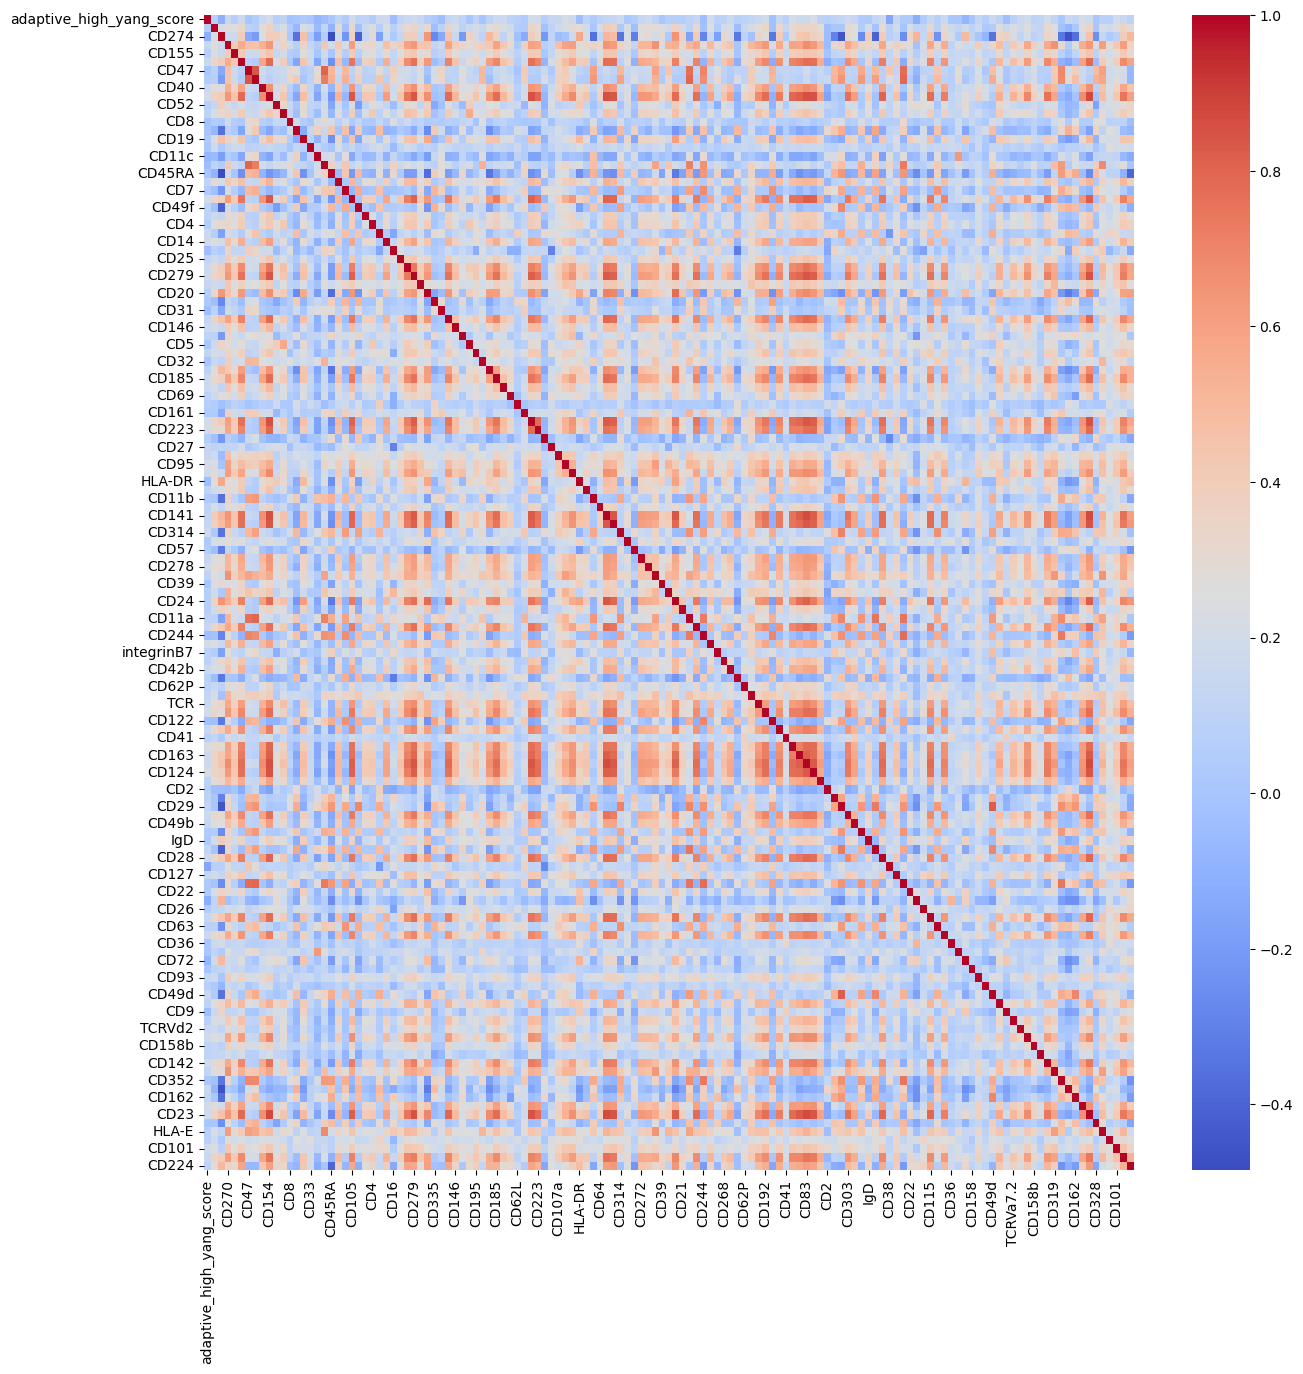

In [185]:
plt.figure(figsize=(15,15))
sb.heatmap(data=df.corr(),cmap='coolwarm')
plt.show()

In [244]:
df

adaptive_high_yang_score      CD86     CD274  \
GTAGTACCAATCCTTT-1-s4d1                 -0.215344  0.652674  1.447594   
CTGTGGGTCATGCGGC-1-s4d1                  0.730587  0.378666  1.132949   
GCAACATTCGCAAGAG-1-s4d1                 -0.008196  0.378666  1.192753   
TCACGGGTCGCACGAC-1-s4d1                  0.144210  0.000000  0.849902   
CGCCAGAAGACCATTC-1-s4d1                  0.091737  0.652674  1.249182   
...                                           ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3                 -0.489534  0.000000  0.568367   
ACATTTCCAGCAGTGA-1-s1d3                 -0.260910  0.000000  0.671273   
TGAGACTTCCTTCAGC-1-s1d3                 -0.264678  0.000000  0.671273   
GAGATGGTCCGCCTAT-1-s1d3                  0.113583  0.000000  0.928521   
ACCTGTCTCACAGTGT-1-s1d3                 -0.039293  0.652674  0.175083   

                            CD270     CD155     CD112      CD47      CD48  \
GTAGTACCAATCCTTT-1-s4d1  1.489354  0.890243  1.290341  1.988618  1.733474   
CTGTGGGTCATGCGGC-1-s4d1  1.153412  0.730824  1.195368  1.546005  1.090567   
GCAACATTCGCAAGAG-1-s4d1  1.208881  0.000000  1.456877  1.046035  1.333993   
TCACGGGTCGCACGAC-1-s4d1  1.548700  0.730824  1.530781  1.883102  1.686271   
CGCCAGAAGACCATTC-1-s4d1  1.404314  0.306698  1.417770  1.664855  1.409627   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  1.124479  1.027708  0.600556  2.007513  1.679342   
ACATTTCCAGCAGTGA-1-s1d3  0.856802  0.000000  0.284617  1.105431  0.818721   
TGAGACTTCCTTCAGC-1-s1d3  0.734526  0.306698  0.284617  1.255114  1.174628   
GAGATGGTCCGCCTAT-1-s1d3  0.999570  0.541080  0.600556  1.759143  2.420602   
ACCTGTCTCACAGTGT-1-s1d3  0.856802  0.000000  0.284617  1.193686  0.866867   

                             CD40     CD154  ...      CD94     CD162  \
GTAGTACCAATCCTTT-1-s4d1  0.850004  1.531390  ...  2.475005  1.804603   
CTGTGGGTCATGCGGC-1-s4d1  1.173337  1.303511  ...  1.408073  1.772872   
GCAACATTCGCAAGAG-1-s4d1  0.638218  1.360894  ...  2.174035  1.013704   
TCACGGGTCGCACGAC-1-s4d1  1.240123  1.804089  ...  3.016060  1.587440   
CGCCAGAAGACCATTC-1-s4d1  1.302726  1.663363  ...  2.826218  2.465725   
...                           ...       ...  ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.749707  0.545181  ...  4.481286  2.345961   
ACATTTCCAGCAGTGA-1-s1d3  0.201533  0.309292  ...  2.122566  1.496074   
TGAGACTTCCTTCAGC-1-s1d3  0.749707  0.625887  ...  0.365443  1.296756   
GAGATGGTCCGCCTAT-1-s1d3  1.024682  0.700563  ...  2.986818  1.976363   
ACCTGTCTCACAGTGT-1-s1d3  0.512721  0.457384  ...  4.033146  2.040049   

                            CD85j      CD23     CD328     HLA-E      CD82  \
GTAGTACCAATCCTTT-1-s4d1  1.069921  1.496785  2.696518  1.532575  0.614600   
CTGTGGGTCATGCGGC-1-s4d1  0.890506  1.188863  2.678422  1.344431  0.353792   
GCAACATTCGCAAGAG-1-s4d1  1.148843  1.332566  0.000000  1.218539  0.670407   
TCACGGGTCGCACGAC-1-s4d1  1.623280  1.552023  2.164676  1.456232  0.614600   
CGCCAGAAGACCATTC-1-s4d1  1.524077  1.637802  3.066941  1.556781  0.276377   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.391222  0.700530  4.391692  1.556781  0.353792   
ACATTTCCAGCAGTGA-1-s1d3  0.391222  0.410393  2.678422  0.950948  0.555495   
TGAGACTTCCTTCAGC-1-s1d3  0.214622  0.410393  3.910620  0.374154  0.492675   
GAGATGGTCCGCCTAT-1-s1d3  0.214622  0.990050  1.800479  1.532575  0.555495   
ACCTGTCTCACAGTGT-1-s1d3  0.541266  0.226103  3.336630  0.758186  0.276377   

                            CD101      CD88     CD224  
GTAGTACCAATCCTTT-1-s4d1  0.900688  1.389844  0.918109  
CTGTGGGTCATGCGGC-1-s4d1  0.860303  0.979461  1.147198  
GCAACATTCGCAAGAG-1-s4d1  0.329073  1.280509  0.676616  
TCACGGGTCGCACGAC-1-s4d1  0.576253  1.189870  1.000442  
CGCCAGAAGACCATTC-1-s4d1  0.680162  1.415407  0.729806  
...                           ...       ...       ...  
ATCATTCGTCCAATCA-1-s1d3  0.519947  0.8097

In [245]:
df['adaptive_high_yang_score']

GTAGTACCAATCCTTT-1-s4d1   -0.215344
CTGTGGGTCATGCGGC-1-s4d1    0.730587
GCAACATTCGCAAGAG-1-s4d1   -0.008196
TCACGGGTCGCACGAC-1-s4d1    0.144210
CGCCAGAAGACCATTC-1-s4d1    0.091737
                             ...   
ATCATTCGTCCAATCA-1-s1d3   -0.489534
ACATTTCCAGCAGTGA-1-s1d3   -0.260910
TGAGACTTCCTTCAGC-1-s1d3   -0.264678
GAGATGGTCCGCCTAT-1-s1d3    0.113583
ACCTGTCTCACAGTGT-1-s1d3   -0.039293
Name: adaptive_high_yang_score, Length: 2640, dtype: float64

In [52]:
#Random forest

X = df.iloc[:, 1:]
y = df['adaptive_high_yang_score']

mean_train_score = []

params = {#'bootstrap': [True, False],
 'max_depth': [3,5,7],
 #'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
 'min_samples_leaf': [2, 5, 10],
 #'min_samples_split': [2, 5, 10] ,
 #'n_estimators': [10, 50, 100]
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(RandomForestRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)
    

Mean squared error: 0.09 R2 score: 0.18


In [53]:
#Mean training scores

print(mean_train_score)

[array([-0.10162585, -0.10152804, -0.10160364, -0.08216684, -0.08209679,
       -0.08378844, -0.06056565, -0.06204683, -0.06795179])]


In [54]:
# The best score and parameters

print(result.best_score_)
print(result.best_params_)

-0.10744202680050015
{'max_depth': 7, 'min_samples_leaf': 5}


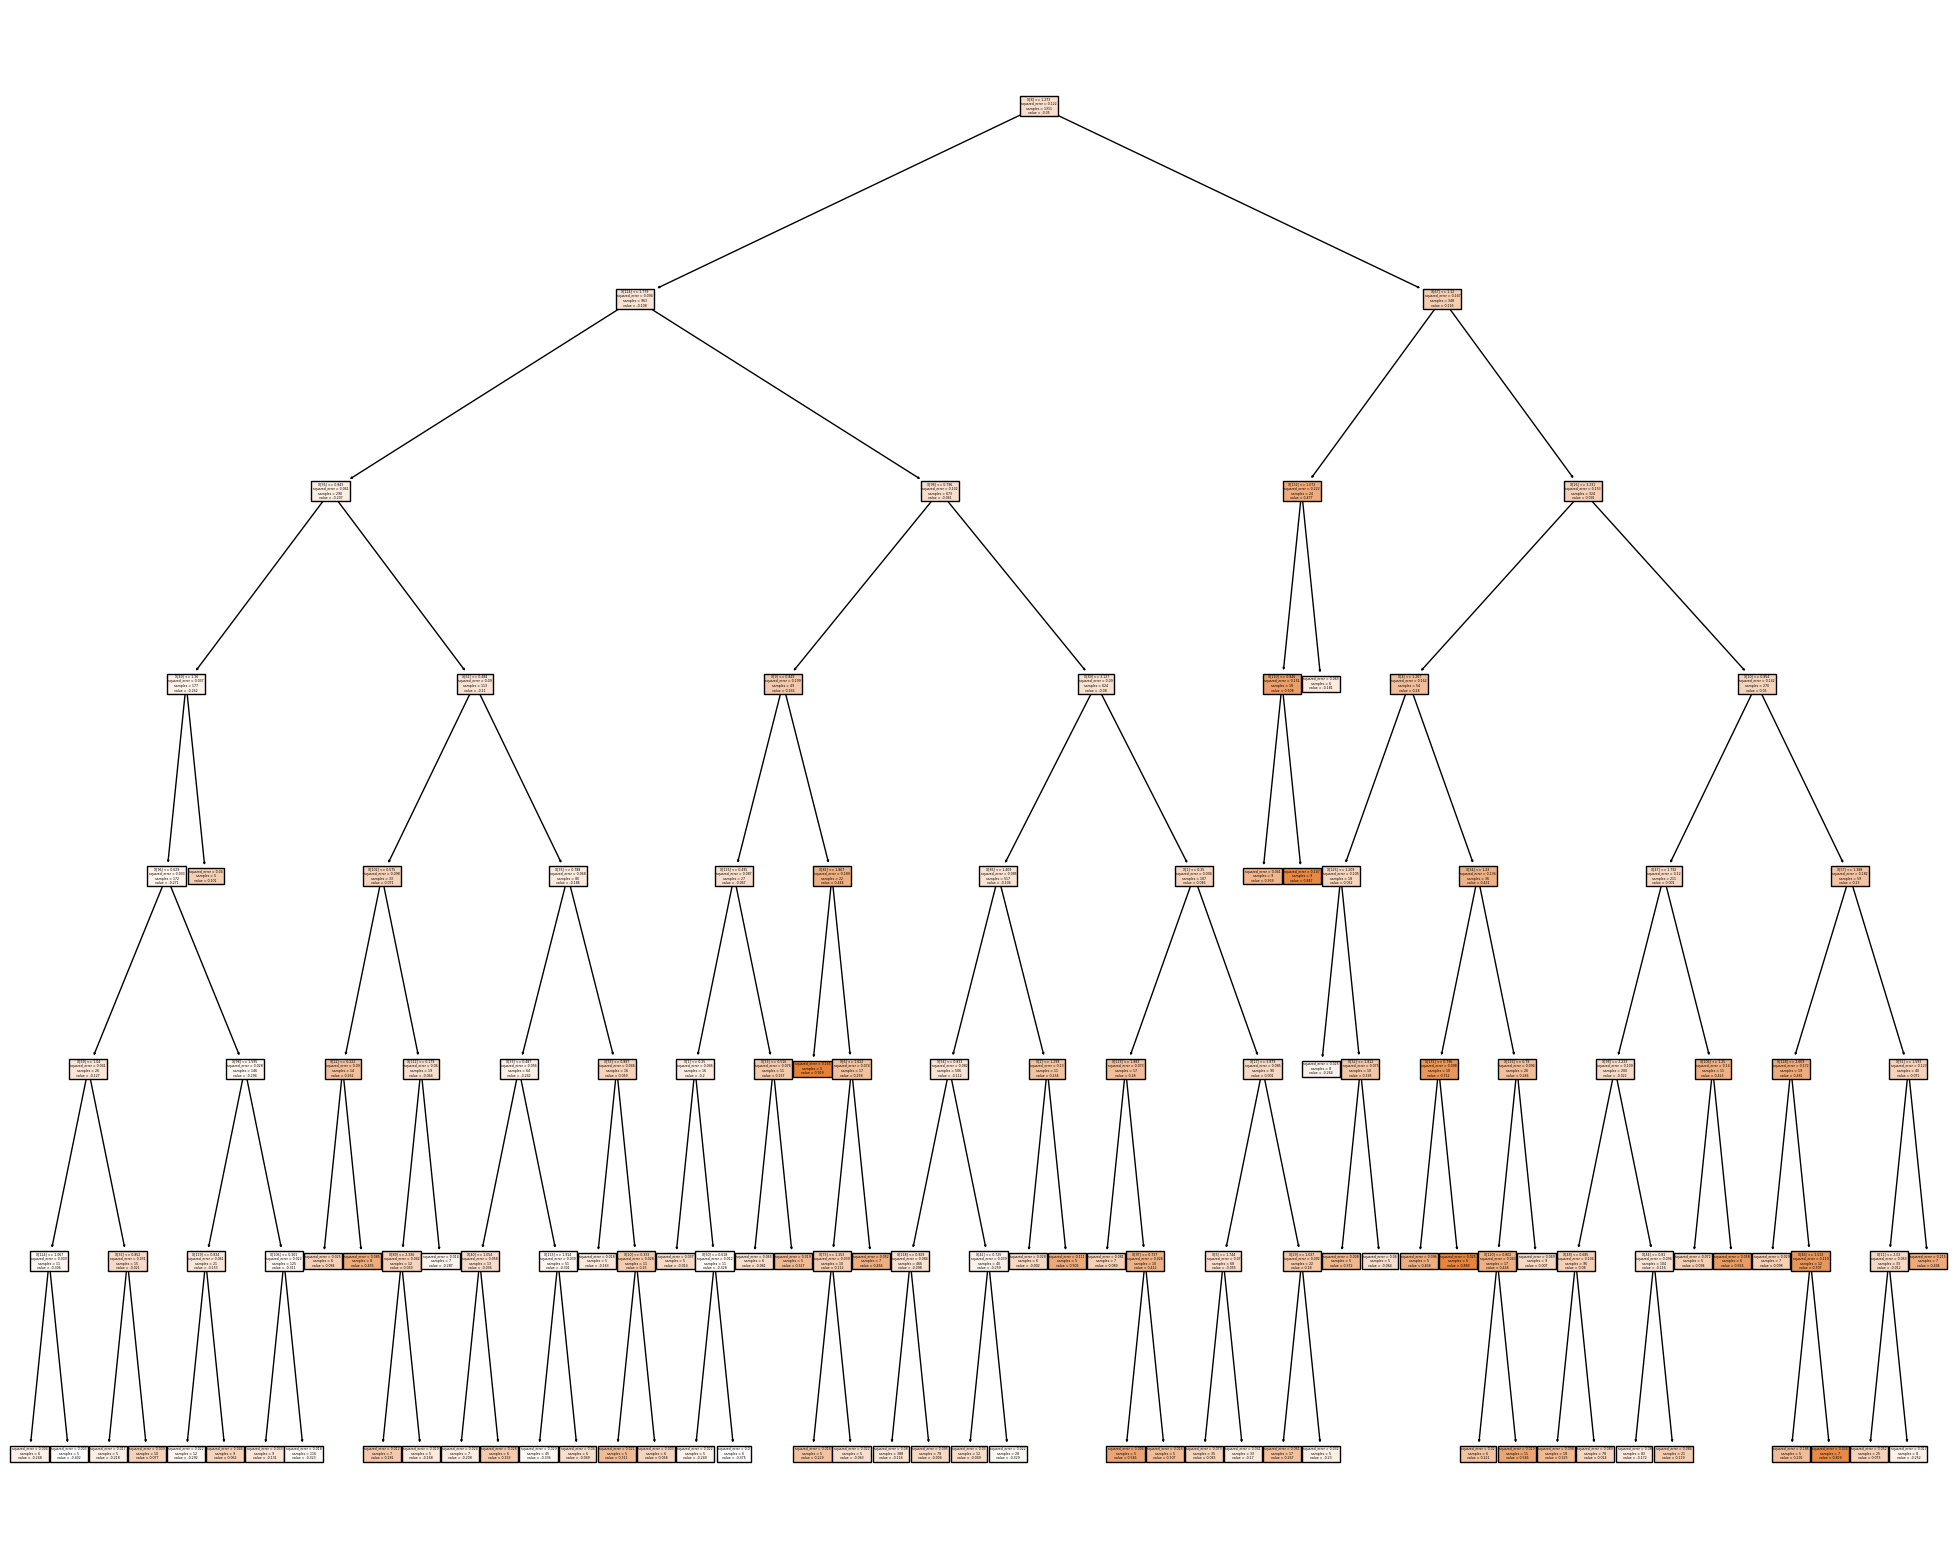

In [55]:
from sklearn import tree

plt.figure(figsize=(25, 20)) # Resize figure
tree.plot_tree(best_model.estimators_[0], filled = True) ;

plt.show()

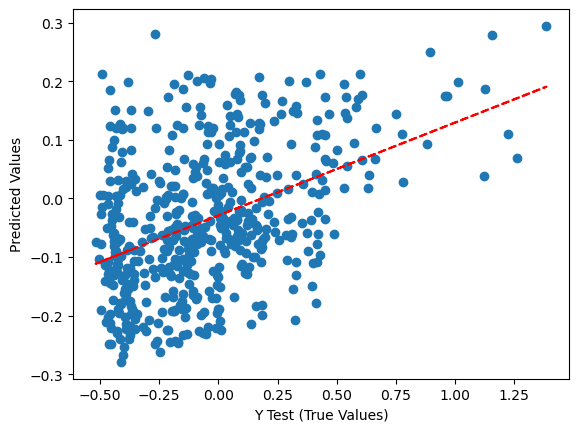

In [57]:
plt.scatter(y_test, y_pred)

# Add a trendline
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r--')
# Add labels
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')
plt.show()

<AxesSubplot: xlabel='adaptive_high_yang_score', ylabel='Density'>

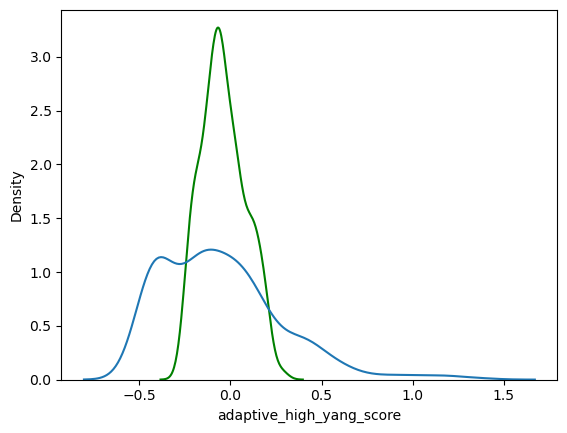

In [58]:
sb.kdeplot(y_pred, color = "g") #predicted values
sb.kdeplot(y_test) #observed values

In [59]:
#Feature importances

importances_rf = best_model.feature_importances_
importances_rf = pd.Series(importances_rf, index=prot.columns)
importances_rf=importances_rf.sort_values(ascending=False)

print(importances_rf.head(10))

CD154    0.060664
CD152    0.047799
CD94     0.046913
CD38     0.045834
CD52     0.033025
CD124    0.030049
CD274    0.026224
CD49d    0.019341
CD314    0.015536
CD162    0.015087
dtype: float64


In [60]:
#df from the top 20 important markers
importances_rf=pd.DataFrame(importances_rf)
importances_rf_top=importances_rf[0:20]
importances_rf_top=importances_rf_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


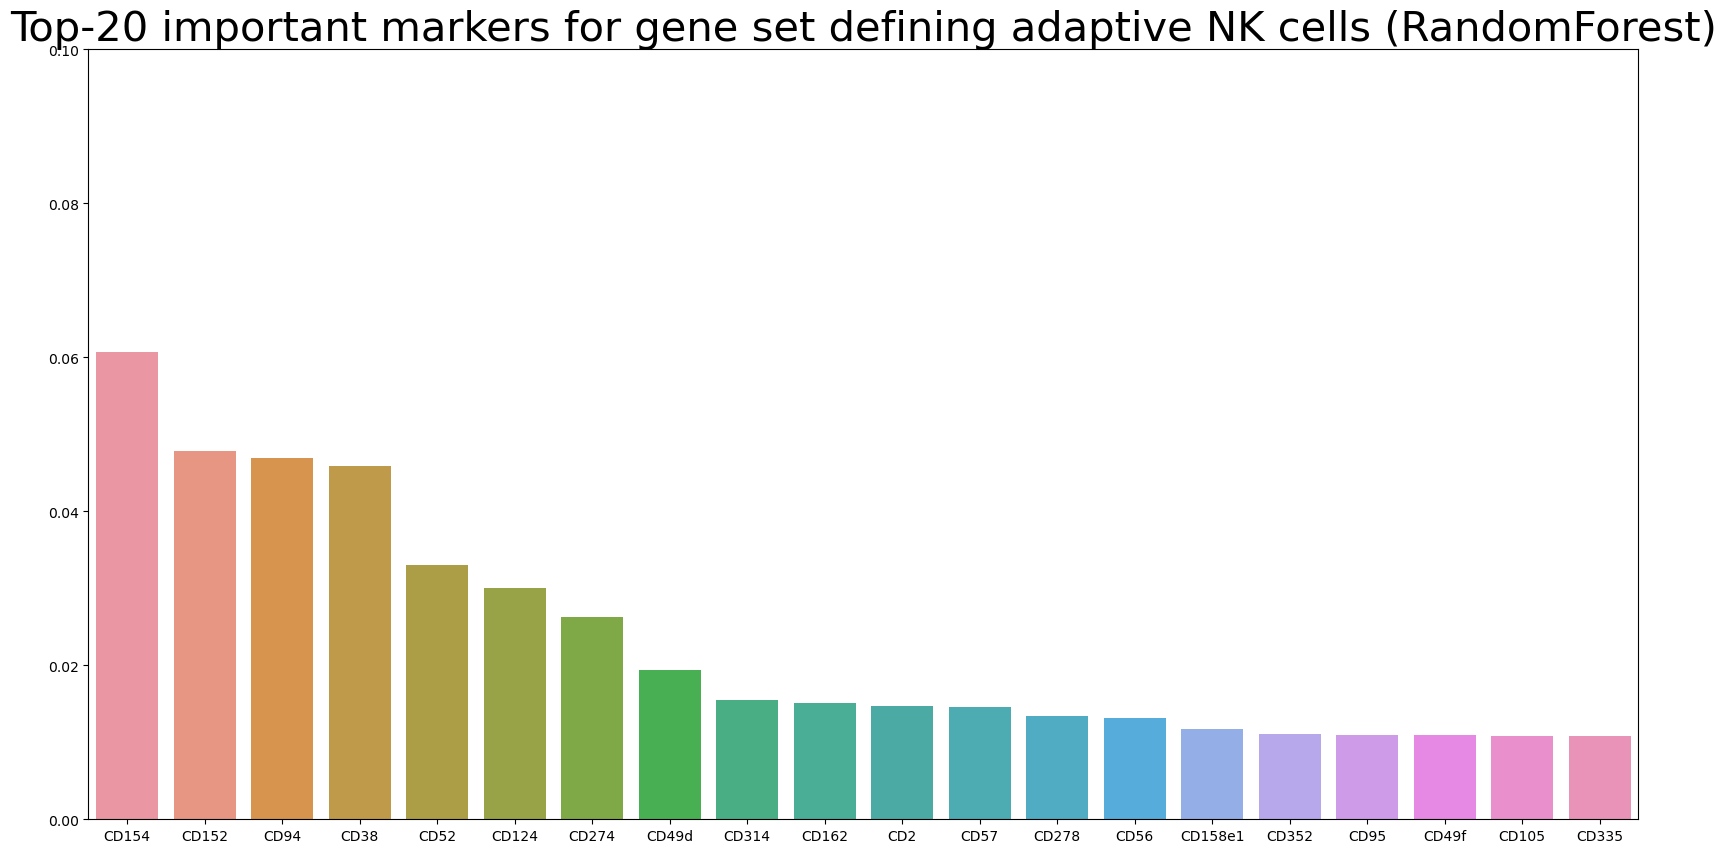

In [61]:
plt.figure(figsize=(20,10))
plt.ylim(0,0.1)
a=sb.barplot(data=importances_rf_top)

plt.title("Top-20 important markers for gene set defining adaptive NK cells (RandomForest)", fontsize = 30) ;


In [62]:
from sklearn.dummy import DummyRegressor

X = df.iloc[:, 1:]
y = df['adaptive_high_yang_score']

mean_train_score = []

params =  {'strategy': ["mean", "median"]}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(DummyRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_dummy = result.best_estimator_
y_pred = best_model_dummy.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

Mean squared error: 0.11 R2 score: -0.00


In [63]:
print(mean_train_score)

[array([-0.1254374 , -0.12909503])]


In [64]:
#Gradient boosting regressor

from sklearn.ensemble import GradientBoostingRegressor

X = df.iloc[:, 1:]
y = df['adaptive_high_yang_score']

mean_train_score = []

params =  {'max_depth': [3,5,7],
          'min_samples_leaf': [2, 5, 10]}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(GradientBoostingRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_gbr = result.best_estimator_
y_pred = best_model_gbr.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

Mean squared error: 0.09 R2 score: 0.20


In [65]:
print(mean_train_score)

[array([-0.05676394, -0.05721314, -0.05873377, -0.01636145, -0.01784628,
       -0.020888  , -0.00186074, -0.00238341, -0.00529479])]


<AxesSubplot: xlabel='adaptive_high_yang_score', ylabel='Density'>

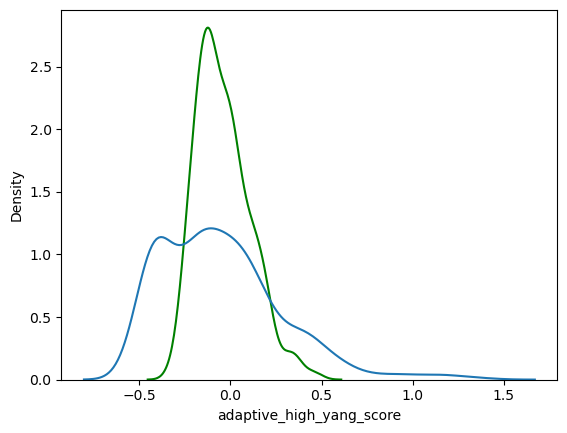

In [66]:
sb.kdeplot(y_pred, color = "g")
sb.kdeplot(y_test)

In [67]:
importances_gbr = best_model_gbr.feature_importances_
importances_gbr = pd.Series(importances_gbr, index=prot.columns)
importances_gbr=importances_gbr.sort_values(ascending=False)

print(importances_gbr.head(10))

CD38     0.063223
CD154    0.043067
CD152    0.042971
CD94     0.038137
CD274    0.036232
CD52     0.035922
CD124    0.032816
CD56     0.023100
CD278    0.021940
CD27     0.020218
dtype: float64


In [68]:
#df from the top 20 important markers
importances_gbr=pd.DataFrame(importances_gbr)
importances_gbr_top=importances_gbr[0:20]
importances_gbr_top=importances_gbr_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


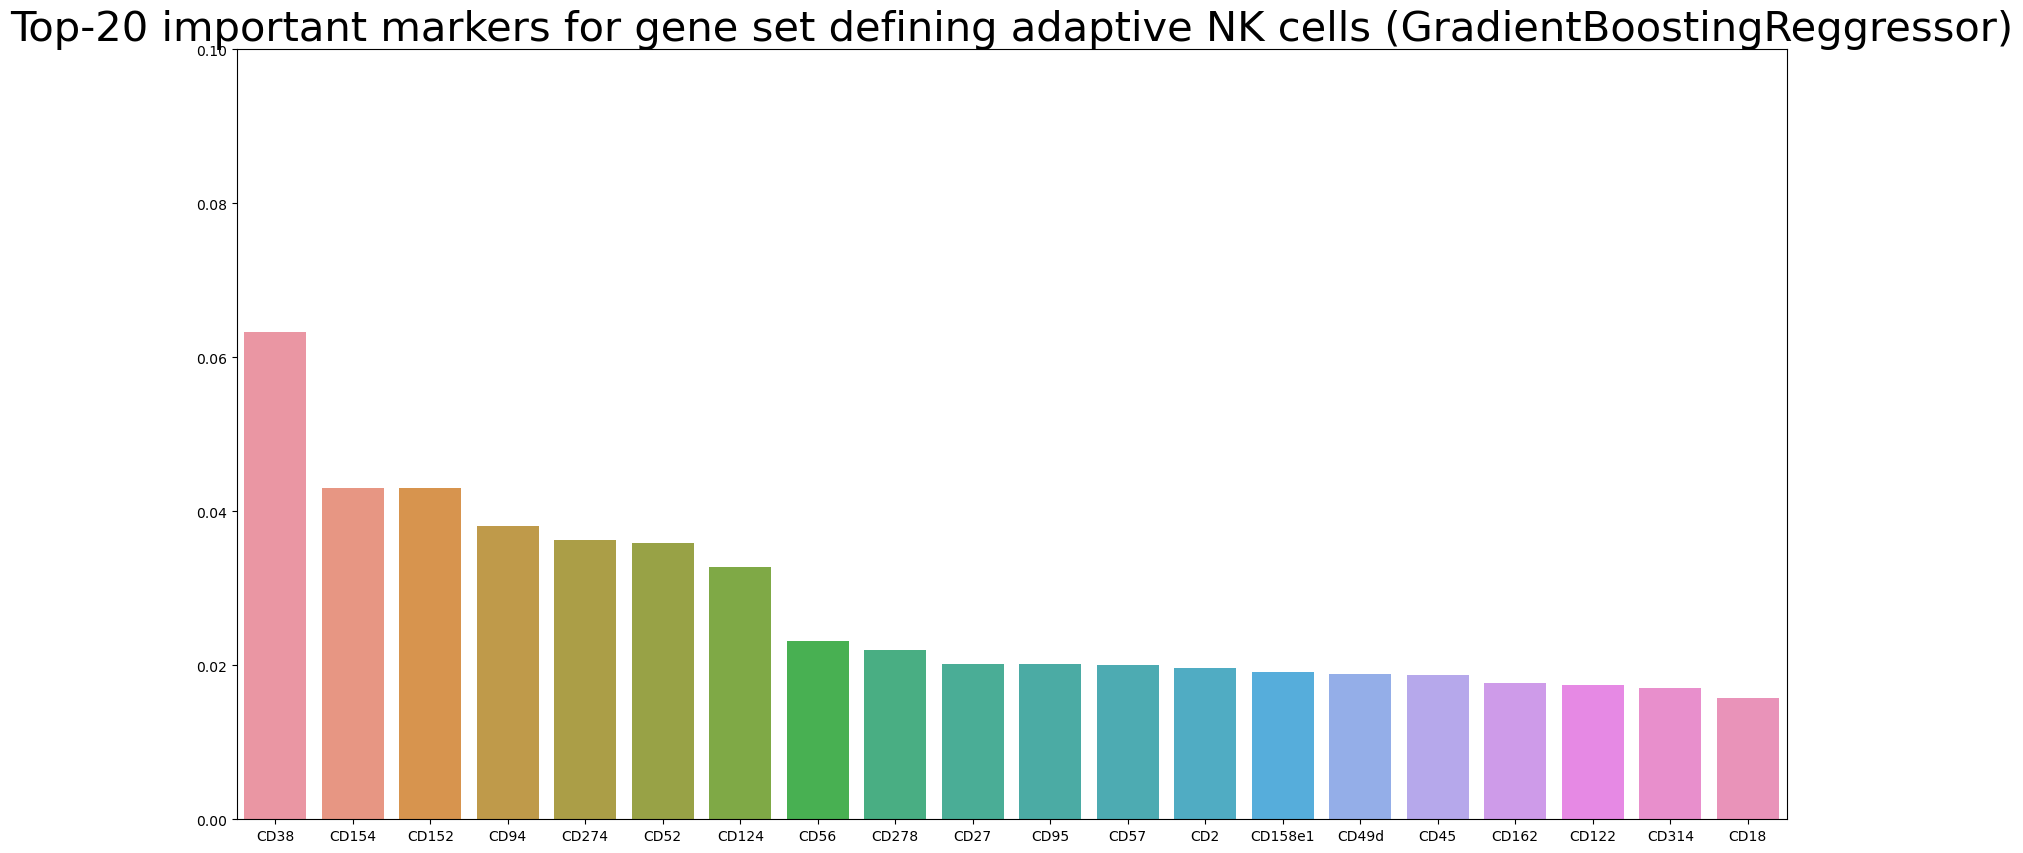

In [69]:
plt.figure(figsize=(20,10))
plt.ylim(0,0.1)
a=sb.barplot(data=importances_gbr_top)

plt.title("Top-20 important markers for gene set defining adaptive NK cells (GradientBoostingReggressor)", fontsize = 30) ;



In [290]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [70]:
from catboost import CatBoostRegressor

X = df.iloc[:, 1:]
y = df['adaptive_high_yang_score']

mean_train_score = []

params= {'depth': [6,8,10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations'    : [30, 50, 100]
                 }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


#Step 2: hyperparameter search
search= GridSearchCV(CatBoostRegressor(), params, cv= 10, scoring='neg_mean_squared_error', return_train_score = True)
result = search.fit(X_train,y_train)
#collecting training scores and saving into mean_train_score
train_scores_mean = (search.cv_results_['mean_train_score']) 
mean_train_score.append(train_scores_mean)
#Step 3: Performance on test set
best_model_cb = result.best_estimator_
y_pred = best_model_cb.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
R2= r2_score(y_test, y_pred)
    
print("Mean squared error: %.2f" % MSE, 'R2 score: %.2f'% R2)

0:	learn: 0.3537931	total: 7.57ms	remaining: 219ms
1:	learn: 0.3533816	total: 11ms	remaining: 155ms
2:	learn: 0.3529869	total: 14.7ms	remaining: 132ms
3:	learn: 0.3525762	total: 18.4ms	remaining: 120ms
4:	learn: 0.3522551	total: 21.3ms	remaining: 107ms
5:	learn: 0.3518679	total: 24.1ms	remaining: 96.3ms
6:	learn: 0.3514626	total: 26.6ms	remaining: 87.5ms
7:	learn: 0.3511401	total: 29.3ms	remaining: 80.5ms
8:	learn: 0.3507932	total: 33.2ms	remaining: 77.5ms
9:	learn: 0.3504198	total: 36.3ms	remaining: 72.6ms
10:	learn: 0.3500599	total: 38.9ms	remaining: 67.2ms
11:	learn: 0.3496728	total: 41.7ms	remaining: 62.5ms
12:	learn: 0.3492816	total: 44.6ms	remaining: 58.3ms
13:	learn: 0.3489395	total: 47.4ms	remaining: 54.2ms
14:	learn: 0.3486437	total: 49.9ms	remaining: 49.9ms
15:	learn: 0.3482806	total: 52.7ms	remaining: 46.2ms
16:	learn: 0.3478721	total: 55.4ms	remaining: 42.4ms
17:	learn: 0.3475587	total: 57.9ms	remaining: 38.6ms
18:	learn: 0.3472671	total: 60.3ms	remaining: 34.9ms
19:	learn:

1:	learn: 0.3561913	total: 5.79ms	remaining: 81.1ms
2:	learn: 0.3558094	total: 8.43ms	remaining: 75.9ms
3:	learn: 0.3554206	total: 10.8ms	remaining: 70.2ms
4:	learn: 0.3550719	total: 13.2ms	remaining: 65.8ms
5:	learn: 0.3546654	total: 15.6ms	remaining: 62.3ms
6:	learn: 0.3542813	total: 18.3ms	remaining: 60ms
7:	learn: 0.3539774	total: 21.1ms	remaining: 58ms
8:	learn: 0.3536134	total: 24.1ms	remaining: 56.3ms
9:	learn: 0.3532556	total: 28ms	remaining: 56ms
10:	learn: 0.3529128	total: 30.4ms	remaining: 52.6ms
11:	learn: 0.3525582	total: 32.8ms	remaining: 49.2ms
12:	learn: 0.3521756	total: 35.2ms	remaining: 46.1ms
13:	learn: 0.3518614	total: 38.1ms	remaining: 43.5ms
14:	learn: 0.3515327	total: 41.7ms	remaining: 41.7ms
15:	learn: 0.3511549	total: 44.4ms	remaining: 38.9ms
16:	learn: 0.3507864	total: 47ms	remaining: 35.9ms
17:	learn: 0.3504811	total: 49.9ms	remaining: 33.3ms
18:	learn: 0.3501715	total: 52.4ms	remaining: 30.4ms
19:	learn: 0.3497912	total: 54.9ms	remaining: 27.5ms
20:	learn: 0

2:	learn: 0.3488523	total: 9.39ms	remaining: 84.5ms
3:	learn: 0.3468311	total: 13ms	remaining: 84.8ms
4:	learn: 0.3454891	total: 16.1ms	remaining: 80.4ms
5:	learn: 0.3440659	total: 19ms	remaining: 76ms
6:	learn: 0.3424817	total: 22.8ms	remaining: 74.8ms
7:	learn: 0.3414916	total: 25.6ms	remaining: 70.5ms
8:	learn: 0.3400855	total: 29.3ms	remaining: 68.4ms
9:	learn: 0.3389170	total: 32.7ms	remaining: 65.3ms
10:	learn: 0.3377854	total: 35.3ms	remaining: 61ms
11:	learn: 0.3367123	total: 38.3ms	remaining: 57.5ms
12:	learn: 0.3354197	total: 41.7ms	remaining: 54.5ms
13:	learn: 0.3344523	total: 44.6ms	remaining: 50.9ms
14:	learn: 0.3334263	total: 47.3ms	remaining: 47.3ms
15:	learn: 0.3322629	total: 50.4ms	remaining: 44.1ms
16:	learn: 0.3313144	total: 53.2ms	remaining: 40.6ms
17:	learn: 0.3303789	total: 56.9ms	remaining: 37.9ms
18:	learn: 0.3297459	total: 59.4ms	remaining: 34.4ms
19:	learn: 0.3286290	total: 62.2ms	remaining: 31.1ms
20:	learn: 0.3276783	total: 65.2ms	remaining: 27.9ms
21:	learn

0:	learn: 0.3471638	total: 4.27ms	remaining: 124ms
1:	learn: 0.3449963	total: 7.88ms	remaining: 110ms
2:	learn: 0.3434767	total: 10.9ms	remaining: 98ms
3:	learn: 0.3419349	total: 14.5ms	remaining: 94.5ms
4:	learn: 0.3404075	total: 17.7ms	remaining: 88.3ms
5:	learn: 0.3390258	total: 22.7ms	remaining: 90.6ms
6:	learn: 0.3374032	total: 27.8ms	remaining: 91.3ms
7:	learn: 0.3363557	total: 31.7ms	remaining: 87.1ms
8:	learn: 0.3351291	total: 35.8ms	remaining: 83.4ms
9:	learn: 0.3339388	total: 39.1ms	remaining: 78.1ms
10:	learn: 0.3327967	total: 42.6ms	remaining: 73.7ms
11:	learn: 0.3312715	total: 46.7ms	remaining: 70ms
12:	learn: 0.3298541	total: 50.3ms	remaining: 65.8ms
13:	learn: 0.3290104	total: 52.8ms	remaining: 60.4ms
14:	learn: 0.3280980	total: 55.9ms	remaining: 55.9ms
15:	learn: 0.3268514	total: 59.8ms	remaining: 52.3ms
16:	learn: 0.3258124	total: 63.5ms	remaining: 48.5ms
17:	learn: 0.3248898	total: 67ms	remaining: 44.6ms
18:	learn: 0.3242939	total: 70ms	remaining: 40.5ms
19:	learn: 0.

17:	learn: 0.3182768	total: 49.7ms	remaining: 33.1ms
18:	learn: 0.3172388	total: 52.6ms	remaining: 30.5ms
19:	learn: 0.3164662	total: 55.3ms	remaining: 27.7ms
20:	learn: 0.3151603	total: 58.5ms	remaining: 25.1ms
21:	learn: 0.3141962	total: 61.4ms	remaining: 22.3ms
22:	learn: 0.3137343	total: 64.1ms	remaining: 19.5ms
23:	learn: 0.3125299	total: 67.6ms	remaining: 16.9ms
24:	learn: 0.3123509	total: 70.9ms	remaining: 14.2ms
25:	learn: 0.3115763	total: 73.9ms	remaining: 11.4ms
26:	learn: 0.3110418	total: 76.8ms	remaining: 8.53ms
27:	learn: 0.3105248	total: 79.4ms	remaining: 5.67ms
28:	learn: 0.3098399	total: 82.7ms	remaining: 2.85ms
29:	learn: 0.3086005	total: 85.5ms	remaining: 0us
0:	learn: 0.3519959	total: 2.76ms	remaining: 80.2ms
1:	learn: 0.3484908	total: 5.29ms	remaining: 74.1ms
2:	learn: 0.3456764	total: 8.33ms	remaining: 75ms
3:	learn: 0.3428552	total: 10.9ms	remaining: 70.6ms
4:	learn: 0.3403876	total: 13.8ms	remaining: 69ms
5:	learn: 0.3382672	total: 17.1ms	remaining: 68.4ms
6:	lea

1:	learn: 0.3488893	total: 5.33ms	remaining: 74.7ms
2:	learn: 0.3463858	total: 8.43ms	remaining: 75.9ms
3:	learn: 0.3435305	total: 10.8ms	remaining: 70.1ms
4:	learn: 0.3414078	total: 13.4ms	remaining: 66.9ms
5:	learn: 0.3391741	total: 15.8ms	remaining: 63.2ms
6:	learn: 0.3364436	total: 18.2ms	remaining: 59.7ms
7:	learn: 0.3343629	total: 20.5ms	remaining: 56.5ms
8:	learn: 0.3325318	total: 23ms	remaining: 53.7ms
9:	learn: 0.3302777	total: 25.5ms	remaining: 51.1ms
10:	learn: 0.3285888	total: 28ms	remaining: 48.4ms
11:	learn: 0.3268101	total: 31.2ms	remaining: 46.9ms
12:	learn: 0.3256418	total: 34.3ms	remaining: 44.9ms
13:	learn: 0.3239669	total: 37ms	remaining: 42.3ms
14:	learn: 0.3230693	total: 39.5ms	remaining: 39.5ms
15:	learn: 0.3224588	total: 42.1ms	remaining: 36.8ms
16:	learn: 0.3213888	total: 44.9ms	remaining: 34.3ms
17:	learn: 0.3202010	total: 47.4ms	remaining: 31.6ms
18:	learn: 0.3190894	total: 49.8ms	remaining: 28.8ms
19:	learn: 0.3178429	total: 52.3ms	remaining: 26.1ms
20:	lear

19:	learn: 0.3495522	total: 50.4ms	remaining: 75.6ms
20:	learn: 0.3492622	total: 53.3ms	remaining: 73.6ms
21:	learn: 0.3490067	total: 56.2ms	remaining: 71.6ms
22:	learn: 0.3486191	total: 59.1ms	remaining: 69.4ms
23:	learn: 0.3482596	total: 61.8ms	remaining: 66.9ms
24:	learn: 0.3479293	total: 65ms	remaining: 65ms
25:	learn: 0.3476297	total: 67.5ms	remaining: 62.4ms
26:	learn: 0.3473460	total: 70.2ms	remaining: 59.8ms
27:	learn: 0.3471189	total: 72.9ms	remaining: 57.3ms
28:	learn: 0.3468320	total: 75.4ms	remaining: 54.6ms
29:	learn: 0.3465457	total: 78ms	remaining: 52ms
30:	learn: 0.3462306	total: 81.1ms	remaining: 49.7ms
31:	learn: 0.3458766	total: 84.9ms	remaining: 47.8ms
32:	learn: 0.3456219	total: 87.6ms	remaining: 45.1ms
33:	learn: 0.3453139	total: 90.5ms	remaining: 42.6ms
34:	learn: 0.3450217	total: 93.3ms	remaining: 40ms
35:	learn: 0.3447602	total: 95.8ms	remaining: 37.3ms
36:	learn: 0.3444453	total: 98.8ms	remaining: 34.7ms
37:	learn: 0.3441816	total: 101ms	remaining: 32ms
38:	le

17:	learn: 0.3454946	total: 49.3ms	remaining: 87.7ms
18:	learn: 0.3452198	total: 52.3ms	remaining: 85.4ms
19:	learn: 0.3447976	total: 54.9ms	remaining: 82.3ms
20:	learn: 0.3444909	total: 57.4ms	remaining: 79.3ms
21:	learn: 0.3442216	total: 60ms	remaining: 76.3ms
22:	learn: 0.3438781	total: 62.7ms	remaining: 73.6ms
23:	learn: 0.3435659	total: 65.4ms	remaining: 70.8ms
24:	learn: 0.3433109	total: 68ms	remaining: 68ms
25:	learn: 0.3429485	total: 70.4ms	remaining: 65ms
26:	learn: 0.3426319	total: 72.9ms	remaining: 62.1ms
27:	learn: 0.3423633	total: 76.1ms	remaining: 59.8ms
28:	learn: 0.3420182	total: 79.6ms	remaining: 57.7ms
29:	learn: 0.3416685	total: 82.5ms	remaining: 55ms
30:	learn: 0.3413776	total: 85.2ms	remaining: 52.2ms
31:	learn: 0.3410315	total: 87.8ms	remaining: 49.4ms
32:	learn: 0.3408066	total: 90.5ms	remaining: 46.6ms
33:	learn: 0.3405097	total: 93ms	remaining: 43.8ms
34:	learn: 0.3402503	total: 95.6ms	remaining: 41ms
35:	learn: 0.3399535	total: 98.1ms	remaining: 38.1ms
36:	lea

38:	learn: 0.3145200	total: 104ms	remaining: 29.4ms
39:	learn: 0.3138471	total: 108ms	remaining: 26.9ms
40:	learn: 0.3133145	total: 110ms	remaining: 24.2ms
41:	learn: 0.3129286	total: 113ms	remaining: 21.5ms
42:	learn: 0.3120582	total: 116ms	remaining: 18.9ms
43:	learn: 0.3113803	total: 119ms	remaining: 16.2ms
44:	learn: 0.3105906	total: 121ms	remaining: 13.5ms
45:	learn: 0.3100703	total: 124ms	remaining: 10.8ms
46:	learn: 0.3095784	total: 127ms	remaining: 8.1ms
47:	learn: 0.3088198	total: 130ms	remaining: 5.42ms
48:	learn: 0.3084178	total: 134ms	remaining: 2.73ms
49:	learn: 0.3080333	total: 136ms	remaining: 0us
0:	learn: 0.3518873	total: 2.7ms	remaining: 132ms
1:	learn: 0.3497394	total: 5.15ms	remaining: 124ms
2:	learn: 0.3481926	total: 7.73ms	remaining: 121ms
3:	learn: 0.3466976	total: 10.2ms	remaining: 117ms
4:	learn: 0.3454721	total: 12.8ms	remaining: 116ms
5:	learn: 0.3436470	total: 15.7ms	remaining: 115ms
6:	learn: 0.3419666	total: 18.1ms	remaining: 111ms
7:	learn: 0.3407150	tota

36:	learn: 0.3161870	total: 97.3ms	remaining: 34.2ms
37:	learn: 0.3154953	total: 100ms	remaining: 31.6ms
38:	learn: 0.3154228	total: 103ms	remaining: 28.9ms
39:	learn: 0.3147136	total: 105ms	remaining: 26.3ms
40:	learn: 0.3146038	total: 108ms	remaining: 23.6ms
41:	learn: 0.3143422	total: 110ms	remaining: 21ms
42:	learn: 0.3135546	total: 113ms	remaining: 18.4ms
43:	learn: 0.3128632	total: 116ms	remaining: 15.8ms
44:	learn: 0.3121489	total: 119ms	remaining: 13.2ms
45:	learn: 0.3114097	total: 122ms	remaining: 10.6ms
46:	learn: 0.3109763	total: 125ms	remaining: 7.97ms
47:	learn: 0.3104485	total: 128ms	remaining: 5.34ms
48:	learn: 0.3100562	total: 131ms	remaining: 2.67ms
49:	learn: 0.3092483	total: 133ms	remaining: 0us
0:	learn: 0.3525459	total: 3.08ms	remaining: 151ms
1:	learn: 0.3507325	total: 5.57ms	remaining: 134ms
2:	learn: 0.3487983	total: 8.03ms	remaining: 126ms
3:	learn: 0.3470602	total: 10.9ms	remaining: 125ms
4:	learn: 0.3455363	total: 13.1ms	remaining: 118ms
5:	learn: 0.3438141	t

36:	learn: 0.3112657	total: 95.8ms	remaining: 33.6ms
37:	learn: 0.3106083	total: 98.7ms	remaining: 31.2ms
38:	learn: 0.3100647	total: 102ms	remaining: 28.8ms
39:	learn: 0.3094701	total: 105ms	remaining: 26.1ms
40:	learn: 0.3090504	total: 107ms	remaining: 23.5ms
41:	learn: 0.3083310	total: 110ms	remaining: 20.9ms
42:	learn: 0.3078433	total: 113ms	remaining: 18.3ms
43:	learn: 0.3071920	total: 115ms	remaining: 15.7ms
44:	learn: 0.3065153	total: 118ms	remaining: 13.1ms
45:	learn: 0.3060423	total: 121ms	remaining: 10.5ms
46:	learn: 0.3056637	total: 124ms	remaining: 7.92ms
47:	learn: 0.3051256	total: 127ms	remaining: 5.31ms
48:	learn: 0.3048028	total: 130ms	remaining: 2.65ms
49:	learn: 0.3044006	total: 133ms	remaining: 0us
0:	learn: 0.3537500	total: 3.4ms	remaining: 167ms
1:	learn: 0.3520978	total: 5.82ms	remaining: 140ms
2:	learn: 0.3501853	total: 8.55ms	remaining: 134ms
3:	learn: 0.3487642	total: 11ms	remaining: 127ms
4:	learn: 0.3469808	total: 13.4ms	remaining: 121ms
5:	learn: 0.3452625	t

39:	learn: 0.2994836	total: 105ms	remaining: 26.2ms
40:	learn: 0.2985307	total: 108ms	remaining: 23.7ms
41:	learn: 0.2970552	total: 110ms	remaining: 21ms
42:	learn: 0.2968997	total: 113ms	remaining: 18.4ms
43:	learn: 0.2965195	total: 115ms	remaining: 15.7ms
44:	learn: 0.2955862	total: 118ms	remaining: 13.1ms
45:	learn: 0.2950224	total: 120ms	remaining: 10.5ms
46:	learn: 0.2942152	total: 123ms	remaining: 7.85ms
47:	learn: 0.2935586	total: 126ms	remaining: 5.23ms
48:	learn: 0.2930163	total: 128ms	remaining: 2.61ms
49:	learn: 0.2919457	total: 130ms	remaining: 0us
0:	learn: 0.3530204	total: 2.55ms	remaining: 125ms
1:	learn: 0.3495065	total: 4.84ms	remaining: 116ms
2:	learn: 0.3459639	total: 7.37ms	remaining: 115ms
3:	learn: 0.3431297	total: 9.73ms	remaining: 112ms
4:	learn: 0.3410170	total: 12ms	remaining: 108ms
5:	learn: 0.3386547	total: 14.5ms	remaining: 106ms
6:	learn: 0.3361629	total: 17.5ms	remaining: 107ms
7:	learn: 0.3342791	total: 20.2ms	remaining: 106ms
8:	learn: 0.3324003	total: 

41:	learn: 0.2967610	total: 109ms	remaining: 20.7ms
42:	learn: 0.2965536	total: 112ms	remaining: 18.2ms
43:	learn: 0.2958667	total: 114ms	remaining: 15.6ms
44:	learn: 0.2950705	total: 117ms	remaining: 13ms
45:	learn: 0.2943107	total: 120ms	remaining: 10.4ms
46:	learn: 0.2930761	total: 122ms	remaining: 7.8ms
47:	learn: 0.2920942	total: 125ms	remaining: 5.21ms
48:	learn: 0.2917979	total: 127ms	remaining: 2.6ms
49:	learn: 0.2910235	total: 130ms	remaining: 0us
0:	learn: 0.3480796	total: 2.65ms	remaining: 130ms
1:	learn: 0.3450751	total: 4.91ms	remaining: 118ms
2:	learn: 0.3417412	total: 7.68ms	remaining: 120ms
3:	learn: 0.3387790	total: 10.4ms	remaining: 119ms
4:	learn: 0.3364015	total: 13.2ms	remaining: 119ms
5:	learn: 0.3340619	total: 15.9ms	remaining: 117ms
6:	learn: 0.3317194	total: 18.2ms	remaining: 112ms
7:	learn: 0.3300987	total: 20.7ms	remaining: 109ms
8:	learn: 0.3287195	total: 23.3ms	remaining: 106ms
9:	learn: 0.3267552	total: 26.1ms	remaining: 104ms
10:	learn: 0.3254835	total: 2

32:	learn: 0.3428785	total: 90.8ms	remaining: 184ms
33:	learn: 0.3425650	total: 93.6ms	remaining: 182ms
34:	learn: 0.3423049	total: 96.4ms	remaining: 179ms
35:	learn: 0.3420277	total: 99ms	remaining: 176ms
36:	learn: 0.3417566	total: 102ms	remaining: 173ms
37:	learn: 0.3415220	total: 104ms	remaining: 170ms
38:	learn: 0.3412484	total: 107ms	remaining: 168ms
39:	learn: 0.3409356	total: 110ms	remaining: 165ms
40:	learn: 0.3406450	total: 113ms	remaining: 162ms
41:	learn: 0.3403334	total: 116ms	remaining: 160ms
42:	learn: 0.3400390	total: 118ms	remaining: 157ms
43:	learn: 0.3397749	total: 122ms	remaining: 155ms
44:	learn: 0.3394679	total: 125ms	remaining: 153ms
45:	learn: 0.3392559	total: 128ms	remaining: 150ms
46:	learn: 0.3390556	total: 130ms	remaining: 147ms
47:	learn: 0.3388172	total: 133ms	remaining: 144ms
48:	learn: 0.3385240	total: 136ms	remaining: 141ms
49:	learn: 0.3382361	total: 138ms	remaining: 138ms
50:	learn: 0.3379563	total: 141ms	remaining: 136ms
51:	learn: 0.3376247	total: 1

44:	learn: 0.3401409	total: 119ms	remaining: 145ms
45:	learn: 0.3399397	total: 122ms	remaining: 143ms
46:	learn: 0.3397229	total: 125ms	remaining: 141ms
47:	learn: 0.3394242	total: 127ms	remaining: 138ms
48:	learn: 0.3391900	total: 130ms	remaining: 136ms
49:	learn: 0.3389287	total: 133ms	remaining: 133ms
50:	learn: 0.3386768	total: 136ms	remaining: 131ms
51:	learn: 0.3383701	total: 138ms	remaining: 128ms
52:	learn: 0.3380735	total: 141ms	remaining: 125ms
53:	learn: 0.3378338	total: 144ms	remaining: 123ms
54:	learn: 0.3375230	total: 148ms	remaining: 121ms
55:	learn: 0.3372547	total: 151ms	remaining: 119ms
56:	learn: 0.3370876	total: 154ms	remaining: 116ms
57:	learn: 0.3367900	total: 157ms	remaining: 114ms
58:	learn: 0.3365730	total: 160ms	remaining: 111ms
59:	learn: 0.3363404	total: 163ms	remaining: 109ms
60:	learn: 0.3360650	total: 166ms	remaining: 106ms
61:	learn: 0.3358197	total: 168ms	remaining: 103ms
62:	learn: 0.3355430	total: 171ms	remaining: 100ms
63:	learn: 0.3353463	total: 173

53:	learn: 0.3392202	total: 145ms	remaining: 123ms
54:	learn: 0.3389511	total: 148ms	remaining: 121ms
55:	learn: 0.3386795	total: 150ms	remaining: 118ms
56:	learn: 0.3385078	total: 153ms	remaining: 115ms
57:	learn: 0.3381982	total: 155ms	remaining: 112ms
58:	learn: 0.3379059	total: 159ms	remaining: 110ms
59:	learn: 0.3376072	total: 161ms	remaining: 107ms
60:	learn: 0.3373008	total: 164ms	remaining: 105ms
61:	learn: 0.3370531	total: 167ms	remaining: 102ms
62:	learn: 0.3367658	total: 169ms	remaining: 99.5ms
63:	learn: 0.3365533	total: 173ms	remaining: 97.1ms
64:	learn: 0.3363284	total: 176ms	remaining: 94.9ms
65:	learn: 0.3361507	total: 179ms	remaining: 92.2ms
66:	learn: 0.3359156	total: 182ms	remaining: 89.6ms
67:	learn: 0.3356428	total: 184ms	remaining: 86.8ms
68:	learn: 0.3354030	total: 187ms	remaining: 84ms
69:	learn: 0.3351720	total: 190ms	remaining: 81.3ms
70:	learn: 0.3349949	total: 192ms	remaining: 78.5ms
71:	learn: 0.3347846	total: 195ms	remaining: 75.7ms
72:	learn: 0.3345535	to

61:	learn: 0.3379312	total: 166ms	remaining: 102ms
62:	learn: 0.3376821	total: 169ms	remaining: 99.2ms
63:	learn: 0.3374244	total: 172ms	remaining: 96.5ms
64:	learn: 0.3372207	total: 174ms	remaining: 93.8ms
65:	learn: 0.3370255	total: 177ms	remaining: 91ms
66:	learn: 0.3367886	total: 180ms	remaining: 88.5ms
67:	learn: 0.3364876	total: 183ms	remaining: 85.9ms
68:	learn: 0.3362249	total: 185ms	remaining: 83.2ms
69:	learn: 0.3359524	total: 189ms	remaining: 81.1ms
70:	learn: 0.3357569	total: 192ms	remaining: 78.5ms
71:	learn: 0.3355491	total: 196ms	remaining: 76.1ms
72:	learn: 0.3353091	total: 198ms	remaining: 73.3ms
73:	learn: 0.3351000	total: 201ms	remaining: 70.6ms
74:	learn: 0.3349016	total: 204ms	remaining: 67.9ms
75:	learn: 0.3346824	total: 206ms	remaining: 65.1ms
76:	learn: 0.3344869	total: 209ms	remaining: 62.4ms
77:	learn: 0.3342068	total: 212ms	remaining: 59.8ms
78:	learn: 0.3339758	total: 215ms	remaining: 57ms
79:	learn: 0.3337003	total: 217ms	remaining: 54.3ms
80:	learn: 0.3335

75:	learn: 0.3275812	total: 203ms	remaining: 64.1ms
76:	learn: 0.3273886	total: 206ms	remaining: 61.5ms
77:	learn: 0.3271245	total: 208ms	remaining: 58.8ms
78:	learn: 0.3269341	total: 211ms	remaining: 56.1ms
79:	learn: 0.3266999	total: 214ms	remaining: 53.4ms
80:	learn: 0.3265557	total: 216ms	remaining: 50.7ms
81:	learn: 0.3263033	total: 219ms	remaining: 48ms
82:	learn: 0.3261410	total: 222ms	remaining: 45.4ms
83:	learn: 0.3260108	total: 225ms	remaining: 42.8ms
84:	learn: 0.3258097	total: 227ms	remaining: 40.1ms
85:	learn: 0.3256056	total: 230ms	remaining: 37.4ms
86:	learn: 0.3254326	total: 233ms	remaining: 34.9ms
87:	learn: 0.3252073	total: 237ms	remaining: 32.3ms
88:	learn: 0.3249887	total: 240ms	remaining: 29.6ms
89:	learn: 0.3247872	total: 242ms	remaining: 26.9ms
90:	learn: 0.3245155	total: 245ms	remaining: 24.2ms
91:	learn: 0.3243330	total: 247ms	remaining: 21.5ms
92:	learn: 0.3240986	total: 250ms	remaining: 18.8ms
93:	learn: 0.3239446	total: 253ms	remaining: 16.1ms
94:	learn: 0.3

85:	learn: 0.2902116	total: 228ms	remaining: 37.1ms
86:	learn: 0.2898023	total: 231ms	remaining: 34.5ms
87:	learn: 0.2893032	total: 234ms	remaining: 31.9ms
88:	learn: 0.2889109	total: 236ms	remaining: 29.2ms
89:	learn: 0.2884753	total: 239ms	remaining: 26.5ms
90:	learn: 0.2879602	total: 242ms	remaining: 23.9ms
91:	learn: 0.2873962	total: 244ms	remaining: 21.2ms
92:	learn: 0.2869686	total: 247ms	remaining: 18.6ms
93:	learn: 0.2865401	total: 250ms	remaining: 16ms
94:	learn: 0.2862071	total: 253ms	remaining: 13.3ms
95:	learn: 0.2857606	total: 256ms	remaining: 10.7ms
96:	learn: 0.2853451	total: 259ms	remaining: 8.01ms
97:	learn: 0.2846597	total: 262ms	remaining: 5.34ms
98:	learn: 0.2842203	total: 264ms	remaining: 2.67ms
99:	learn: 0.2840130	total: 267ms	remaining: 0us
0:	learn: 0.3518873	total: 2.45ms	remaining: 243ms
1:	learn: 0.3497394	total: 5.09ms	remaining: 249ms
2:	learn: 0.3481926	total: 7.68ms	remaining: 248ms
3:	learn: 0.3466976	total: 10.2ms	remaining: 245ms
4:	learn: 0.3454721	t

94:	learn: 0.2896478	total: 254ms	remaining: 13.4ms
95:	learn: 0.2891159	total: 257ms	remaining: 10.7ms
96:	learn: 0.2883012	total: 260ms	remaining: 8.03ms
97:	learn: 0.2879163	total: 262ms	remaining: 5.35ms
98:	learn: 0.2875347	total: 265ms	remaining: 2.67ms
99:	learn: 0.2872870	total: 267ms	remaining: 0us
0:	learn: 0.3547611	total: 2.75ms	remaining: 273ms
1:	learn: 0.3528774	total: 5.14ms	remaining: 252ms
2:	learn: 0.3508850	total: 7.75ms	remaining: 251ms
3:	learn: 0.3492964	total: 10.4ms	remaining: 248ms
4:	learn: 0.3475997	total: 12.7ms	remaining: 242ms
5:	learn: 0.3462808	total: 15.1ms	remaining: 237ms
6:	learn: 0.3444815	total: 17.7ms	remaining: 235ms
7:	learn: 0.3434034	total: 20.3ms	remaining: 233ms
8:	learn: 0.3421105	total: 22.7ms	remaining: 229ms
9:	learn: 0.3409143	total: 25.3ms	remaining: 228ms
10:	learn: 0.3396796	total: 27.9ms	remaining: 226ms
11:	learn: 0.3382495	total: 30.8ms	remaining: 226ms
12:	learn: 0.3366880	total: 33.5ms	remaining: 224ms
13:	learn: 0.3357138	tota

0:	learn: 0.3525459	total: 2.75ms	remaining: 273ms
1:	learn: 0.3507325	total: 5.61ms	remaining: 275ms
2:	learn: 0.3487983	total: 8.63ms	remaining: 279ms
3:	learn: 0.3470602	total: 11.7ms	remaining: 280ms
4:	learn: 0.3455363	total: 14.2ms	remaining: 270ms
5:	learn: 0.3438141	total: 16.7ms	remaining: 261ms
6:	learn: 0.3420666	total: 19.1ms	remaining: 254ms
7:	learn: 0.3405782	total: 21.6ms	remaining: 248ms
8:	learn: 0.3391604	total: 24.7ms	remaining: 250ms
9:	learn: 0.3378474	total: 27.4ms	remaining: 247ms
10:	learn: 0.3368201	total: 29.9ms	remaining: 242ms
11:	learn: 0.3353254	total: 33ms	remaining: 242ms
12:	learn: 0.3340913	total: 36ms	remaining: 241ms
13:	learn: 0.3332327	total: 38.8ms	remaining: 238ms
14:	learn: 0.3322521	total: 41.4ms	remaining: 235ms
15:	learn: 0.3310928	total: 43.9ms	remaining: 230ms
16:	learn: 0.3301660	total: 46.7ms	remaining: 228ms
17:	learn: 0.3293376	total: 49.5ms	remaining: 225ms
18:	learn: 0.3288117	total: 52ms	remaining: 222ms
19:	learn: 0.3276162	total: 

9:	learn: 0.3361083	total: 27.4ms	remaining: 246ms
10:	learn: 0.3351007	total: 29.9ms	remaining: 242ms
11:	learn: 0.3338979	total: 32.5ms	remaining: 239ms
12:	learn: 0.3324564	total: 35.2ms	remaining: 236ms
13:	learn: 0.3316357	total: 38ms	remaining: 234ms
14:	learn: 0.3305824	total: 40.7ms	remaining: 231ms
15:	learn: 0.3296124	total: 43.5ms	remaining: 228ms
16:	learn: 0.3287464	total: 46.1ms	remaining: 225ms
17:	learn: 0.3278194	total: 48.5ms	remaining: 221ms
18:	learn: 0.3271234	total: 51.9ms	remaining: 221ms
19:	learn: 0.3262394	total: 54.4ms	remaining: 218ms
20:	learn: 0.3255446	total: 58.7ms	remaining: 221ms
21:	learn: 0.3245785	total: 61.3ms	remaining: 217ms
22:	learn: 0.3238164	total: 64.2ms	remaining: 215ms
23:	learn: 0.3229082	total: 66.7ms	remaining: 211ms
24:	learn: 0.3223712	total: 69.6ms	remaining: 209ms
25:	learn: 0.3215222	total: 72.4ms	remaining: 206ms
26:	learn: 0.3206884	total: 75.5ms	remaining: 204ms
27:	learn: 0.3199614	total: 78.1ms	remaining: 201ms
28:	learn: 0.31

18:	learn: 0.3312530	total: 48.7ms	remaining: 207ms
19:	learn: 0.3301355	total: 52.1ms	remaining: 209ms
20:	learn: 0.3293575	total: 54.6ms	remaining: 205ms
21:	learn: 0.3286316	total: 57.4ms	remaining: 204ms
22:	learn: 0.3275550	total: 60.4ms	remaining: 202ms
23:	learn: 0.3266478	total: 63ms	remaining: 199ms
24:	learn: 0.3258284	total: 65.8ms	remaining: 197ms
25:	learn: 0.3251701	total: 68.2ms	remaining: 194ms
26:	learn: 0.3244912	total: 70.8ms	remaining: 191ms
27:	learn: 0.3236312	total: 74ms	remaining: 190ms
28:	learn: 0.3227445	total: 77.6ms	remaining: 190ms
29:	learn: 0.3219577	total: 80.9ms	remaining: 189ms
30:	learn: 0.3213496	total: 83.8ms	remaining: 186ms
31:	learn: 0.3207297	total: 86.4ms	remaining: 184ms
32:	learn: 0.3197687	total: 89.1ms	remaining: 181ms
33:	learn: 0.3193340	total: 91.6ms	remaining: 178ms
34:	learn: 0.3190098	total: 94.1ms	remaining: 175ms
35:	learn: 0.3184815	total: 96.6ms	remaining: 172ms
36:	learn: 0.3179195	total: 99.4ms	remaining: 169ms
37:	learn: 0.317

26:	learn: 0.3082476	total: 71.7ms	remaining: 194ms
27:	learn: 0.3077929	total: 74.3ms	remaining: 191ms
28:	learn: 0.3069095	total: 76.9ms	remaining: 188ms
29:	learn: 0.3054666	total: 79.4ms	remaining: 185ms
30:	learn: 0.3039241	total: 82ms	remaining: 183ms
31:	learn: 0.3035465	total: 84.6ms	remaining: 180ms
32:	learn: 0.3024770	total: 87ms	remaining: 177ms
33:	learn: 0.3014208	total: 89.4ms	remaining: 174ms
34:	learn: 0.3009890	total: 92.1ms	remaining: 171ms
35:	learn: 0.2997596	total: 94.7ms	remaining: 168ms
36:	learn: 0.2991397	total: 97.7ms	remaining: 166ms
37:	learn: 0.2981497	total: 101ms	remaining: 165ms
38:	learn: 0.2973069	total: 104ms	remaining: 162ms
39:	learn: 0.2962490	total: 107ms	remaining: 160ms
40:	learn: 0.2950014	total: 109ms	remaining: 157ms
41:	learn: 0.2935553	total: 113ms	remaining: 156ms
42:	learn: 0.2928109	total: 115ms	remaining: 153ms
43:	learn: 0.2922151	total: 118ms	remaining: 150ms
44:	learn: 0.2908584	total: 120ms	remaining: 147ms
45:	learn: 0.2902109	tot

36:	learn: 0.3016266	total: 97.2ms	remaining: 165ms
37:	learn: 0.3001793	total: 100ms	remaining: 163ms
38:	learn: 0.2995556	total: 103ms	remaining: 161ms
39:	learn: 0.2988380	total: 106ms	remaining: 159ms
40:	learn: 0.2979790	total: 109ms	remaining: 156ms
41:	learn: 0.2965718	total: 111ms	remaining: 154ms
42:	learn: 0.2956056	total: 114ms	remaining: 151ms
43:	learn: 0.2947461	total: 117ms	remaining: 149ms
44:	learn: 0.2936289	total: 120ms	remaining: 146ms
45:	learn: 0.2930063	total: 122ms	remaining: 144ms
46:	learn: 0.2921517	total: 125ms	remaining: 141ms
47:	learn: 0.2912845	total: 129ms	remaining: 140ms
48:	learn: 0.2908543	total: 132ms	remaining: 137ms
49:	learn: 0.2896216	total: 135ms	remaining: 135ms
50:	learn: 0.2889115	total: 138ms	remaining: 132ms
51:	learn: 0.2879808	total: 140ms	remaining: 130ms
52:	learn: 0.2869555	total: 143ms	remaining: 127ms
53:	learn: 0.2861778	total: 145ms	remaining: 124ms
54:	learn: 0.2860977	total: 148ms	remaining: 121ms
55:	learn: 0.2852380	total: 15

46:	learn: 0.2897077	total: 121ms	remaining: 136ms
47:	learn: 0.2887648	total: 124ms	remaining: 134ms
48:	learn: 0.2882829	total: 126ms	remaining: 131ms
49:	learn: 0.2874364	total: 129ms	remaining: 129ms
50:	learn: 0.2869309	total: 132ms	remaining: 127ms
51:	learn: 0.2863210	total: 134ms	remaining: 124ms
52:	learn: 0.2859218	total: 137ms	remaining: 122ms
53:	learn: 0.2852423	total: 140ms	remaining: 119ms
54:	learn: 0.2842709	total: 143ms	remaining: 117ms
55:	learn: 0.2836646	total: 146ms	remaining: 114ms
56:	learn: 0.2832693	total: 148ms	remaining: 112ms
57:	learn: 0.2822606	total: 152ms	remaining: 110ms
58:	learn: 0.2818099	total: 155ms	remaining: 108ms
59:	learn: 0.2815775	total: 157ms	remaining: 105ms
60:	learn: 0.2804894	total: 160ms	remaining: 102ms
61:	learn: 0.2799260	total: 163ms	remaining: 99.7ms
62:	learn: 0.2790665	total: 165ms	remaining: 97ms
63:	learn: 0.2785223	total: 168ms	remaining: 94.4ms
64:	learn: 0.2778674	total: 170ms	remaining: 91.7ms
65:	learn: 0.2776037	total: 1

57:	learn: 0.2819571	total: 154ms	remaining: 111ms
58:	learn: 0.2815672	total: 157ms	remaining: 109ms
59:	learn: 0.2811096	total: 159ms	remaining: 106ms
60:	learn: 0.2800530	total: 162ms	remaining: 103ms
61:	learn: 0.2794869	total: 164ms	remaining: 101ms
62:	learn: 0.2787577	total: 167ms	remaining: 98.3ms
63:	learn: 0.2775331	total: 170ms	remaining: 95.6ms
64:	learn: 0.2759917	total: 172ms	remaining: 92.8ms
65:	learn: 0.2750675	total: 175ms	remaining: 90.2ms
66:	learn: 0.2744242	total: 178ms	remaining: 87.4ms
67:	learn: 0.2732380	total: 180ms	remaining: 84.7ms
68:	learn: 0.2724449	total: 183ms	remaining: 82.2ms
69:	learn: 0.2723253	total: 186ms	remaining: 79.9ms
70:	learn: 0.2715948	total: 189ms	remaining: 77.3ms
71:	learn: 0.2705899	total: 192ms	remaining: 74.5ms
72:	learn: 0.2701806	total: 194ms	remaining: 71.8ms
73:	learn: 0.2698202	total: 196ms	remaining: 69ms
74:	learn: 0.2690600	total: 199ms	remaining: 66.5ms
75:	learn: 0.2681957	total: 202ms	remaining: 63.8ms
76:	learn: 0.267268

73:	learn: 0.2718450	total: 199ms	remaining: 69.9ms
74:	learn: 0.2708666	total: 202ms	remaining: 67.3ms
75:	learn: 0.2704984	total: 205ms	remaining: 64.7ms
76:	learn: 0.2693009	total: 207ms	remaining: 61.9ms
77:	learn: 0.2684131	total: 210ms	remaining: 59.2ms
78:	learn: 0.2676065	total: 212ms	remaining: 56.5ms
79:	learn: 0.2668730	total: 215ms	remaining: 53.8ms
80:	learn: 0.2657160	total: 218ms	remaining: 51.1ms
81:	learn: 0.2645552	total: 220ms	remaining: 48.4ms
82:	learn: 0.2636061	total: 224ms	remaining: 45.8ms
83:	learn: 0.2626872	total: 227ms	remaining: 43.2ms
84:	learn: 0.2617008	total: 230ms	remaining: 40.5ms
85:	learn: 0.2606474	total: 233ms	remaining: 37.9ms
86:	learn: 0.2596691	total: 236ms	remaining: 35.2ms
87:	learn: 0.2588304	total: 238ms	remaining: 32.5ms
88:	learn: 0.2579321	total: 241ms	remaining: 29.8ms
89:	learn: 0.2567961	total: 244ms	remaining: 27.1ms
90:	learn: 0.2556712	total: 247ms	remaining: 24.5ms
91:	learn: 0.2552715	total: 250ms	remaining: 21.7ms
92:	learn: 0

0:	learn: 0.3539164	total: 13.6ms	remaining: 394ms
1:	learn: 0.3534383	total: 20.8ms	remaining: 291ms
2:	learn: 0.3529684	total: 27.3ms	remaining: 245ms
3:	learn: 0.3525056	total: 33.6ms	remaining: 218ms
4:	learn: 0.3520756	total: 40.6ms	remaining: 203ms
5:	learn: 0.3516024	total: 47.3ms	remaining: 189ms
6:	learn: 0.3510785	total: 54ms	remaining: 177ms
7:	learn: 0.3507506	total: 60.6ms	remaining: 167ms
8:	learn: 0.3502580	total: 67.5ms	remaining: 157ms
9:	learn: 0.3497692	total: 74.2ms	remaining: 148ms
10:	learn: 0.3493791	total: 81.3ms	remaining: 140ms
11:	learn: 0.3490152	total: 88.1ms	remaining: 132ms
12:	learn: 0.3485478	total: 94.9ms	remaining: 124ms
13:	learn: 0.3481858	total: 101ms	remaining: 116ms
14:	learn: 0.3477858	total: 108ms	remaining: 108ms
15:	learn: 0.3473316	total: 115ms	remaining: 100ms
16:	learn: 0.3469511	total: 122ms	remaining: 93.1ms
17:	learn: 0.3465751	total: 129ms	remaining: 85.7ms
18:	learn: 0.3461447	total: 135ms	remaining: 78.4ms
19:	learn: 0.3457451	total:

20:	learn: 0.3192706	total: 169ms	remaining: 72.5ms
21:	learn: 0.3181056	total: 177ms	remaining: 64.2ms
22:	learn: 0.3166884	total: 184ms	remaining: 56ms
23:	learn: 0.3155385	total: 190ms	remaining: 47.6ms
24:	learn: 0.3144753	total: 198ms	remaining: 39.6ms
25:	learn: 0.3130042	total: 206ms	remaining: 31.6ms
26:	learn: 0.3113610	total: 212ms	remaining: 23.6ms
27:	learn: 0.3104378	total: 219ms	remaining: 15.6ms
28:	learn: 0.3095829	total: 226ms	remaining: 7.8ms
29:	learn: 0.3083199	total: 233ms	remaining: 0us
0:	learn: 0.3517610	total: 15.9ms	remaining: 461ms
1:	learn: 0.3494481	total: 22.4ms	remaining: 314ms
2:	learn: 0.3472828	total: 29.1ms	remaining: 262ms
3:	learn: 0.3451460	total: 35.6ms	remaining: 231ms
4:	learn: 0.3431140	total: 43.2ms	remaining: 216ms
5:	learn: 0.3410498	total: 49.8ms	remaining: 199ms
6:	learn: 0.3394893	total: 56.5ms	remaining: 186ms
7:	learn: 0.3383234	total: 63.2ms	remaining: 174ms
8:	learn: 0.3369329	total: 70ms	remaining: 163ms
9:	learn: 0.3353659	total: 76

23:	learn: 0.3170983	total: 182ms	remaining: 45.5ms
24:	learn: 0.3162164	total: 190ms	remaining: 38.1ms
25:	learn: 0.3152789	total: 198ms	remaining: 30.5ms
26:	learn: 0.3138061	total: 206ms	remaining: 22.9ms
27:	learn: 0.3127065	total: 215ms	remaining: 15.4ms
28:	learn: 0.3112795	total: 222ms	remaining: 7.66ms
29:	learn: 0.3101595	total: 229ms	remaining: 0us
0:	learn: 0.3496594	total: 15.7ms	remaining: 455ms
1:	learn: 0.3476032	total: 22.6ms	remaining: 317ms
2:	learn: 0.3453548	total: 29.4ms	remaining: 264ms
3:	learn: 0.3430252	total: 36.9ms	remaining: 240ms
4:	learn: 0.3409529	total: 45.2ms	remaining: 226ms
5:	learn: 0.3388364	total: 53.2ms	remaining: 213ms
6:	learn: 0.3374035	total: 60.2ms	remaining: 198ms
7:	learn: 0.3362305	total: 66.9ms	remaining: 184ms
8:	learn: 0.3344417	total: 73.9ms	remaining: 172ms
9:	learn: 0.3326584	total: 80.7ms	remaining: 161ms
10:	learn: 0.3312558	total: 87.9ms	remaining: 152ms
11:	learn: 0.3301130	total: 96.5ms	remaining: 145ms
12:	learn: 0.3282229	tota

0:	learn: 0.3519122	total: 17ms	remaining: 493ms
1:	learn: 0.3477119	total: 23.8ms	remaining: 334ms
2:	learn: 0.3437264	total: 31.6ms	remaining: 284ms
3:	learn: 0.3392996	total: 38.2ms	remaining: 248ms
4:	learn: 0.3361326	total: 45ms	remaining: 225ms
5:	learn: 0.3331831	total: 51.7ms	remaining: 207ms
6:	learn: 0.3301251	total: 58.1ms	remaining: 191ms
7:	learn: 0.3279053	total: 65.4ms	remaining: 180ms
8:	learn: 0.3248098	total: 72ms	remaining: 168ms
9:	learn: 0.3215179	total: 79.1ms	remaining: 158ms
10:	learn: 0.3196879	total: 85.9ms	remaining: 148ms
11:	learn: 0.3184576	total: 92.4ms	remaining: 139ms
12:	learn: 0.3162350	total: 99.9ms	remaining: 131ms
13:	learn: 0.3146426	total: 107ms	remaining: 122ms
14:	learn: 0.3123090	total: 113ms	remaining: 113ms
15:	learn: 0.3093334	total: 120ms	remaining: 105ms
16:	learn: 0.3076005	total: 128ms	remaining: 97.9ms
17:	learn: 0.3067024	total: 135ms	remaining: 89.9ms
18:	learn: 0.3048732	total: 142ms	remaining: 82.3ms
19:	learn: 0.3025873	total: 150

20:	learn: 0.2971045	total: 183ms	remaining: 78.4ms
21:	learn: 0.2959408	total: 200ms	remaining: 72.6ms
22:	learn: 0.2946170	total: 215ms	remaining: 65.4ms
23:	learn: 0.2935937	total: 230ms	remaining: 57.5ms
24:	learn: 0.2929124	total: 244ms	remaining: 48.8ms
25:	learn: 0.2914268	total: 255ms	remaining: 39.2ms
26:	learn: 0.2899001	total: 268ms	remaining: 29.8ms
27:	learn: 0.2885624	total: 278ms	remaining: 19.8ms
28:	learn: 0.2865046	total: 288ms	remaining: 9.94ms
29:	learn: 0.2844090	total: 300ms	remaining: 0us
0:	learn: 0.3518467	total: 21.1ms	remaining: 612ms
1:	learn: 0.3480916	total: 30.9ms	remaining: 432ms
2:	learn: 0.3434557	total: 40.3ms	remaining: 363ms
3:	learn: 0.3395988	total: 49.3ms	remaining: 320ms
4:	learn: 0.3366662	total: 58.5ms	remaining: 293ms
5:	learn: 0.3333070	total: 72ms	remaining: 288ms
6:	learn: 0.3306494	total: 85.9ms	remaining: 282ms
7:	learn: 0.3280244	total: 95.5ms	remaining: 263ms
8:	learn: 0.3248950	total: 110ms	remaining: 256ms
9:	learn: 0.3225836	total: 

31:	learn: 0.3411638	total: 225ms	remaining: 126ms
32:	learn: 0.3409036	total: 231ms	remaining: 119ms
33:	learn: 0.3404895	total: 238ms	remaining: 112ms
34:	learn: 0.3402355	total: 246ms	remaining: 106ms
35:	learn: 0.3398630	total: 253ms	remaining: 98.3ms
36:	learn: 0.3394256	total: 260ms	remaining: 91.3ms
37:	learn: 0.3391304	total: 266ms	remaining: 84.1ms
38:	learn: 0.3387882	total: 273ms	remaining: 77.1ms
39:	learn: 0.3384852	total: 280ms	remaining: 70.1ms
40:	learn: 0.3381494	total: 287ms	remaining: 63ms
41:	learn: 0.3378104	total: 294ms	remaining: 56ms
42:	learn: 0.3375097	total: 300ms	remaining: 48.9ms
43:	learn: 0.3371802	total: 307ms	remaining: 41.9ms
44:	learn: 0.3368516	total: 315ms	remaining: 35ms
45:	learn: 0.3364833	total: 321ms	remaining: 28ms
46:	learn: 0.3362250	total: 328ms	remaining: 20.9ms
47:	learn: 0.3358169	total: 335ms	remaining: 14ms
48:	learn: 0.3354876	total: 342ms	remaining: 6.98ms
49:	learn: 0.3351688	total: 349ms	remaining: 0us
0:	learn: 0.3560970	total: 15

48:	learn: 0.3349363	total: 341ms	remaining: 6.96ms
49:	learn: 0.3346071	total: 348ms	remaining: 0us
0:	learn: 0.3564994	total: 15.4ms	remaining: 755ms
1:	learn: 0.3560460	total: 22.2ms	remaining: 532ms
2:	learn: 0.3554199	total: 28.9ms	remaining: 454ms
3:	learn: 0.3549153	total: 35.6ms	remaining: 409ms
4:	learn: 0.3544111	total: 43.2ms	remaining: 388ms
5:	learn: 0.3539033	total: 49.9ms	remaining: 366ms
6:	learn: 0.3534337	total: 56.8ms	remaining: 349ms
7:	learn: 0.3530564	total: 63.5ms	remaining: 333ms
8:	learn: 0.3525383	total: 70.2ms	remaining: 320ms
9:	learn: 0.3520253	total: 76.5ms	remaining: 306ms
10:	learn: 0.3516000	total: 83.4ms	remaining: 296ms
11:	learn: 0.3512386	total: 90.1ms	remaining: 285ms
12:	learn: 0.3507725	total: 97ms	remaining: 276ms
13:	learn: 0.3504139	total: 104ms	remaining: 266ms
14:	learn: 0.3500566	total: 110ms	remaining: 257ms
15:	learn: 0.3496406	total: 117ms	remaining: 248ms
16:	learn: 0.3492067	total: 123ms	remaining: 239ms
17:	learn: 0.3488368	total: 130

10:	learn: 0.3505634	total: 83.9ms	remaining: 297ms
11:	learn: 0.3502136	total: 91.4ms	remaining: 289ms
12:	learn: 0.3498208	total: 98.3ms	remaining: 280ms
13:	learn: 0.3494763	total: 106ms	remaining: 274ms
14:	learn: 0.3490623	total: 114ms	remaining: 266ms
15:	learn: 0.3485973	total: 121ms	remaining: 257ms
16:	learn: 0.3481671	total: 128ms	remaining: 248ms
17:	learn: 0.3478251	total: 134ms	remaining: 239ms
18:	learn: 0.3474974	total: 142ms	remaining: 231ms
19:	learn: 0.3470970	total: 148ms	remaining: 223ms
20:	learn: 0.3467130	total: 156ms	remaining: 215ms
21:	learn: 0.3462981	total: 162ms	remaining: 206ms
22:	learn: 0.3459317	total: 169ms	remaining: 198ms
23:	learn: 0.3455763	total: 175ms	remaining: 190ms
24:	learn: 0.3452676	total: 183ms	remaining: 183ms
25:	learn: 0.3448499	total: 189ms	remaining: 175ms
26:	learn: 0.3444425	total: 196ms	remaining: 167ms
27:	learn: 0.3440379	total: 203ms	remaining: 160ms
28:	learn: 0.3436847	total: 211ms	remaining: 153ms
29:	learn: 0.3432482	total: 

30:	learn: 0.3078759	total: 220ms	remaining: 135ms
31:	learn: 0.3070111	total: 227ms	remaining: 128ms
32:	learn: 0.3064074	total: 234ms	remaining: 121ms
33:	learn: 0.3055932	total: 242ms	remaining: 114ms
34:	learn: 0.3047262	total: 249ms	remaining: 107ms
35:	learn: 0.3035968	total: 255ms	remaining: 99.3ms
36:	learn: 0.3025281	total: 263ms	remaining: 92.5ms
37:	learn: 0.3017508	total: 270ms	remaining: 85.2ms
38:	learn: 0.3010202	total: 277ms	remaining: 78.2ms
39:	learn: 0.3004299	total: 284ms	remaining: 71ms
40:	learn: 0.2995158	total: 291ms	remaining: 63.8ms
41:	learn: 0.2987685	total: 297ms	remaining: 56.6ms
42:	learn: 0.2984063	total: 304ms	remaining: 49.5ms
43:	learn: 0.2974475	total: 311ms	remaining: 42.4ms
44:	learn: 0.2965544	total: 317ms	remaining: 35.3ms
45:	learn: 0.2955106	total: 324ms	remaining: 28.2ms
46:	learn: 0.2950389	total: 330ms	remaining: 21.1ms
47:	learn: 0.2948829	total: 337ms	remaining: 14ms
48:	learn: 0.2939656	total: 343ms	remaining: 7ms
49:	learn: 0.2931947	tot

11:	learn: 0.3332806	total: 90.6ms	remaining: 287ms
12:	learn: 0.3315796	total: 97.6ms	remaining: 278ms
13:	learn: 0.3305541	total: 105ms	remaining: 270ms
14:	learn: 0.3291604	total: 113ms	remaining: 265ms
15:	learn: 0.3277044	total: 121ms	remaining: 257ms
16:	learn: 0.3261491	total: 129ms	remaining: 251ms
17:	learn: 0.3248701	total: 137ms	remaining: 243ms
18:	learn: 0.3235070	total: 144ms	remaining: 235ms
19:	learn: 0.3221321	total: 152ms	remaining: 228ms
20:	learn: 0.3208893	total: 159ms	remaining: 220ms
21:	learn: 0.3192886	total: 167ms	remaining: 213ms
22:	learn: 0.3180886	total: 174ms	remaining: 205ms
23:	learn: 0.3170983	total: 181ms	remaining: 196ms
24:	learn: 0.3162164	total: 189ms	remaining: 189ms
25:	learn: 0.3152789	total: 196ms	remaining: 181ms
26:	learn: 0.3138061	total: 203ms	remaining: 173ms
27:	learn: 0.3127065	total: 210ms	remaining: 165ms
28:	learn: 0.3112795	total: 218ms	remaining: 158ms
29:	learn: 0.3101595	total: 225ms	remaining: 150ms
30:	learn: 0.3091599	total: 2

42:	learn: 0.2966023	total: 319ms	remaining: 51.9ms
43:	learn: 0.2958421	total: 330ms	remaining: 45ms
44:	learn: 0.2950445	total: 337ms	remaining: 37.5ms
45:	learn: 0.2942799	total: 345ms	remaining: 30ms
46:	learn: 0.2938600	total: 352ms	remaining: 22.5ms
47:	learn: 0.2934175	total: 359ms	remaining: 15ms
48:	learn: 0.2928535	total: 367ms	remaining: 7.48ms
49:	learn: 0.2921644	total: 374ms	remaining: 0us
0:	learn: 0.3497082	total: 17.6ms	remaining: 861ms
1:	learn: 0.3456114	total: 25.6ms	remaining: 615ms
2:	learn: 0.3417207	total: 33.1ms	remaining: 519ms
3:	learn: 0.3387250	total: 40.8ms	remaining: 470ms
4:	learn: 0.3355623	total: 48.7ms	remaining: 438ms
5:	learn: 0.3317816	total: 56.3ms	remaining: 413ms
6:	learn: 0.3283784	total: 63.9ms	remaining: 393ms
7:	learn: 0.3266680	total: 71.6ms	remaining: 376ms
8:	learn: 0.3231002	total: 79.4ms	remaining: 362ms
9:	learn: 0.3205524	total: 86.9ms	remaining: 348ms
10:	learn: 0.3177488	total: 94.5ms	remaining: 335ms
11:	learn: 0.3148608	total: 102

14:	learn: 0.3123090	total: 120ms	remaining: 279ms
15:	learn: 0.3093334	total: 128ms	remaining: 271ms
16:	learn: 0.3076005	total: 136ms	remaining: 264ms
17:	learn: 0.3067024	total: 144ms	remaining: 256ms
18:	learn: 0.3048732	total: 151ms	remaining: 246ms
19:	learn: 0.3025873	total: 158ms	remaining: 237ms
20:	learn: 0.3007930	total: 165ms	remaining: 228ms
21:	learn: 0.2987096	total: 172ms	remaining: 219ms
22:	learn: 0.2973123	total: 179ms	remaining: 211ms
23:	learn: 0.2959052	total: 187ms	remaining: 202ms
24:	learn: 0.2940427	total: 196ms	remaining: 196ms
25:	learn: 0.2929858	total: 203ms	remaining: 187ms
26:	learn: 0.2912481	total: 211ms	remaining: 179ms
27:	learn: 0.2898191	total: 218ms	remaining: 171ms
28:	learn: 0.2881846	total: 225ms	remaining: 163ms
29:	learn: 0.2863282	total: 233ms	remaining: 155ms
30:	learn: 0.2844596	total: 240ms	remaining: 147ms
31:	learn: 0.2827026	total: 248ms	remaining: 139ms
32:	learn: 0.2817882	total: 255ms	remaining: 131ms
33:	learn: 0.2798040	total: 262

48:	learn: 0.2646674	total: 339ms	remaining: 6.92ms
49:	learn: 0.2637781	total: 346ms	remaining: 0us
0:	learn: 0.3475431	total: 15.9ms	remaining: 779ms
1:	learn: 0.3432506	total: 23.6ms	remaining: 567ms
2:	learn: 0.3390808	total: 30.8ms	remaining: 483ms
3:	learn: 0.3348280	total: 39.6ms	remaining: 456ms
4:	learn: 0.3314252	total: 47.5ms	remaining: 427ms
5:	learn: 0.3277934	total: 55.4ms	remaining: 406ms
6:	learn: 0.3255230	total: 62.8ms	remaining: 386ms
7:	learn: 0.3238655	total: 70.3ms	remaining: 369ms
8:	learn: 0.3207578	total: 77.6ms	remaining: 354ms
9:	learn: 0.3177563	total: 85.3ms	remaining: 341ms
10:	learn: 0.3156154	total: 93.3ms	remaining: 331ms
11:	learn: 0.3139219	total: 102ms	remaining: 322ms
12:	learn: 0.3113975	total: 109ms	remaining: 311ms
13:	learn: 0.3099082	total: 117ms	remaining: 300ms
14:	learn: 0.3075823	total: 124ms	remaining: 290ms
15:	learn: 0.3048432	total: 132ms	remaining: 280ms
16:	learn: 0.3034392	total: 139ms	remaining: 270ms
17:	learn: 0.3013502	total: 147

16:	learn: 0.3466661	total: 133ms	remaining: 650ms
17:	learn: 0.3462345	total: 141ms	remaining: 642ms
18:	learn: 0.3457825	total: 149ms	remaining: 636ms
19:	learn: 0.3453585	total: 156ms	remaining: 624ms
20:	learn: 0.3449260	total: 164ms	remaining: 616ms
21:	learn: 0.3445088	total: 171ms	remaining: 606ms
22:	learn: 0.3440743	total: 179ms	remaining: 599ms
23:	learn: 0.3436729	total: 187ms	remaining: 592ms
24:	learn: 0.3433627	total: 195ms	remaining: 584ms
25:	learn: 0.3429649	total: 202ms	remaining: 576ms
26:	learn: 0.3425394	total: 210ms	remaining: 567ms
27:	learn: 0.3421609	total: 217ms	remaining: 557ms
28:	learn: 0.3417523	total: 224ms	remaining: 548ms
29:	learn: 0.3413656	total: 232ms	remaining: 541ms
30:	learn: 0.3409421	total: 239ms	remaining: 532ms
31:	learn: 0.3405747	total: 248ms	remaining: 526ms
32:	learn: 0.3402983	total: 256ms	remaining: 521ms
33:	learn: 0.3399154	total: 265ms	remaining: 513ms
34:	learn: 0.3395019	total: 271ms	remaining: 504ms
35:	learn: 0.3390857	total: 279

77:	learn: 0.3268200	total: 577ms	remaining: 163ms
78:	learn: 0.3266639	total: 585ms	remaining: 155ms
79:	learn: 0.3264028	total: 593ms	remaining: 148ms
80:	learn: 0.3261045	total: 601ms	remaining: 141ms
81:	learn: 0.3258217	total: 609ms	remaining: 134ms
82:	learn: 0.3255600	total: 616ms	remaining: 126ms
83:	learn: 0.3252571	total: 624ms	remaining: 119ms
84:	learn: 0.3249908	total: 631ms	remaining: 111ms
85:	learn: 0.3247070	total: 638ms	remaining: 104ms
86:	learn: 0.3244844	total: 646ms	remaining: 96.5ms
87:	learn: 0.3242963	total: 652ms	remaining: 89ms
88:	learn: 0.3239318	total: 659ms	remaining: 81.4ms
89:	learn: 0.3235982	total: 666ms	remaining: 73.9ms
90:	learn: 0.3232498	total: 672ms	remaining: 66.5ms
91:	learn: 0.3229706	total: 679ms	remaining: 59ms
92:	learn: 0.3226727	total: 685ms	remaining: 51.6ms
93:	learn: 0.3223279	total: 692ms	remaining: 44.2ms
94:	learn: 0.3221084	total: 699ms	remaining: 36.8ms
95:	learn: 0.3217679	total: 706ms	remaining: 29.4ms
96:	learn: 0.3215484	tota

61:	learn: 0.3335275	total: 460ms	remaining: 282ms
62:	learn: 0.3332628	total: 468ms	remaining: 275ms
63:	learn: 0.3330366	total: 476ms	remaining: 268ms
64:	learn: 0.3327617	total: 483ms	remaining: 260ms
65:	learn: 0.3324191	total: 491ms	remaining: 253ms
66:	learn: 0.3322001	total: 498ms	remaining: 245ms
67:	learn: 0.3318774	total: 505ms	remaining: 238ms
68:	learn: 0.3315783	total: 511ms	remaining: 230ms
69:	learn: 0.3312783	total: 518ms	remaining: 222ms
70:	learn: 0.3309691	total: 525ms	remaining: 214ms
71:	learn: 0.3307059	total: 533ms	remaining: 207ms
72:	learn: 0.3304658	total: 541ms	remaining: 200ms
73:	learn: 0.3301619	total: 548ms	remaining: 192ms
74:	learn: 0.3298695	total: 555ms	remaining: 185ms
75:	learn: 0.3296169	total: 562ms	remaining: 177ms
76:	learn: 0.3293761	total: 570ms	remaining: 170ms
77:	learn: 0.3291388	total: 577ms	remaining: 163ms
78:	learn: 0.3289305	total: 584ms	remaining: 155ms
79:	learn: 0.3286969	total: 591ms	remaining: 148ms
80:	learn: 0.3283584	total: 597

45:	learn: 0.3358644	total: 350ms	remaining: 411ms
46:	learn: 0.3356519	total: 360ms	remaining: 405ms
47:	learn: 0.3352609	total: 368ms	remaining: 398ms
48:	learn: 0.3349363	total: 376ms	remaining: 391ms
49:	learn: 0.3346071	total: 384ms	remaining: 384ms
50:	learn: 0.3342279	total: 391ms	remaining: 376ms
51:	learn: 0.3339163	total: 399ms	remaining: 369ms
52:	learn: 0.3335620	total: 408ms	remaining: 362ms
53:	learn: 0.3332524	total: 417ms	remaining: 356ms
54:	learn: 0.3329442	total: 425ms	remaining: 348ms
55:	learn: 0.3326598	total: 433ms	remaining: 340ms
56:	learn: 0.3323164	total: 440ms	remaining: 332ms
57:	learn: 0.3319721	total: 448ms	remaining: 325ms
58:	learn: 0.3315725	total: 456ms	remaining: 317ms
59:	learn: 0.3312052	total: 463ms	remaining: 309ms
60:	learn: 0.3308321	total: 471ms	remaining: 301ms
61:	learn: 0.3305015	total: 478ms	remaining: 293ms
62:	learn: 0.3302361	total: 485ms	remaining: 285ms
63:	learn: 0.3300055	total: 492ms	remaining: 277ms
64:	learn: 0.3297412	total: 499

13:	learn: 0.3460201	total: 112ms	remaining: 686ms
14:	learn: 0.3456469	total: 119ms	remaining: 676ms
15:	learn: 0.3452509	total: 127ms	remaining: 668ms
16:	learn: 0.3448694	total: 134ms	remaining: 654ms
17:	learn: 0.3445233	total: 141ms	remaining: 641ms
18:	learn: 0.3441709	total: 150ms	remaining: 638ms
19:	learn: 0.3438134	total: 157ms	remaining: 629ms
20:	learn: 0.3433238	total: 165ms	remaining: 619ms
21:	learn: 0.3429698	total: 172ms	remaining: 610ms
22:	learn: 0.3425917	total: 180ms	remaining: 601ms
23:	learn: 0.3422385	total: 188ms	remaining: 594ms
24:	learn: 0.3419233	total: 196ms	remaining: 588ms
25:	learn: 0.3415140	total: 205ms	remaining: 583ms
26:	learn: 0.3411082	total: 214ms	remaining: 577ms
27:	learn: 0.3407794	total: 223ms	remaining: 575ms
28:	learn: 0.3404296	total: 232ms	remaining: 568ms
29:	learn: 0.3399996	total: 242ms	remaining: 565ms
30:	learn: 0.3396305	total: 250ms	remaining: 555ms
31:	learn: 0.3392732	total: 259ms	remaining: 550ms
32:	learn: 0.3390089	total: 268

81:	learn: 0.3206007	total: 882ms	remaining: 194ms
82:	learn: 0.3203233	total: 890ms	remaining: 182ms
83:	learn: 0.3200964	total: 897ms	remaining: 171ms
84:	learn: 0.3198571	total: 905ms	remaining: 160ms
85:	learn: 0.3196047	total: 912ms	remaining: 148ms
86:	learn: 0.3193730	total: 920ms	remaining: 137ms
87:	learn: 0.3191335	total: 927ms	remaining: 126ms
88:	learn: 0.3188176	total: 935ms	remaining: 116ms
89:	learn: 0.3185184	total: 943ms	remaining: 105ms
90:	learn: 0.3182242	total: 950ms	remaining: 94ms
91:	learn: 0.3179815	total: 958ms	remaining: 83.3ms
92:	learn: 0.3176956	total: 966ms	remaining: 72.7ms
93:	learn: 0.3174500	total: 973ms	remaining: 62.1ms
94:	learn: 0.3171884	total: 981ms	remaining: 51.6ms
95:	learn: 0.3168155	total: 988ms	remaining: 41.2ms
96:	learn: 0.3165510	total: 996ms	remaining: 30.8ms
97:	learn: 0.3162988	total: 1s	remaining: 20.5ms
98:	learn: 0.3160994	total: 1.01s	remaining: 10.2ms
99:	learn: 0.3159191	total: 1.02s	remaining: 0us
0:	learn: 0.3550825	total: 20

56:	learn: 0.2848784	total: 429ms	remaining: 324ms
57:	learn: 0.2841965	total: 437ms	remaining: 316ms
58:	learn: 0.2836464	total: 445ms	remaining: 309ms
59:	learn: 0.2829785	total: 453ms	remaining: 302ms
60:	learn: 0.2827326	total: 460ms	remaining: 294ms
61:	learn: 0.2822372	total: 467ms	remaining: 286ms
62:	learn: 0.2815303	total: 476ms	remaining: 279ms
63:	learn: 0.2809218	total: 483ms	remaining: 272ms
64:	learn: 0.2802874	total: 490ms	remaining: 264ms
65:	learn: 0.2797734	total: 497ms	remaining: 256ms
66:	learn: 0.2789338	total: 503ms	remaining: 248ms
67:	learn: 0.2780744	total: 510ms	remaining: 240ms
68:	learn: 0.2774302	total: 518ms	remaining: 233ms
69:	learn: 0.2767590	total: 524ms	remaining: 225ms
70:	learn: 0.2761558	total: 531ms	remaining: 217ms
71:	learn: 0.2752187	total: 537ms	remaining: 209ms
72:	learn: 0.2744095	total: 544ms	remaining: 201ms
73:	learn: 0.2731818	total: 551ms	remaining: 193ms
74:	learn: 0.2728862	total: 557ms	remaining: 186ms
75:	learn: 0.2715750	total: 564

40:	learn: 0.2995158	total: 299ms	remaining: 431ms
41:	learn: 0.2987685	total: 311ms	remaining: 429ms
42:	learn: 0.2984063	total: 320ms	remaining: 425ms
43:	learn: 0.2974475	total: 331ms	remaining: 421ms
44:	learn: 0.2965544	total: 340ms	remaining: 416ms
45:	learn: 0.2955106	total: 349ms	remaining: 410ms
46:	learn: 0.2950389	total: 359ms	remaining: 404ms
47:	learn: 0.2948829	total: 369ms	remaining: 399ms
48:	learn: 0.2939656	total: 378ms	remaining: 393ms
49:	learn: 0.2931947	total: 388ms	remaining: 388ms
50:	learn: 0.2924127	total: 398ms	remaining: 382ms
51:	learn: 0.2920733	total: 408ms	remaining: 377ms
52:	learn: 0.2910398	total: 418ms	remaining: 371ms
53:	learn: 0.2901374	total: 428ms	remaining: 364ms
54:	learn: 0.2896123	total: 438ms	remaining: 359ms
55:	learn: 0.2888209	total: 448ms	remaining: 352ms
56:	learn: 0.2879422	total: 459ms	remaining: 346ms
57:	learn: 0.2873026	total: 469ms	remaining: 340ms
58:	learn: 0.2863034	total: 479ms	remaining: 333ms
59:	learn: 0.2855013	total: 488

17:	learn: 0.3242849	total: 148ms	remaining: 673ms
18:	learn: 0.3228799	total: 155ms	remaining: 659ms
19:	learn: 0.3216911	total: 163ms	remaining: 650ms
20:	learn: 0.3204425	total: 171ms	remaining: 644ms
21:	learn: 0.3193436	total: 178ms	remaining: 631ms
22:	learn: 0.3178956	total: 185ms	remaining: 619ms
23:	learn: 0.3168804	total: 192ms	remaining: 607ms
24:	learn: 0.3159530	total: 199ms	remaining: 597ms
25:	learn: 0.3146659	total: 206ms	remaining: 585ms
26:	learn: 0.3132132	total: 214ms	remaining: 578ms
27:	learn: 0.3122147	total: 220ms	remaining: 567ms
28:	learn: 0.3106841	total: 227ms	remaining: 556ms
29:	learn: 0.3093730	total: 234ms	remaining: 547ms
30:	learn: 0.3077912	total: 241ms	remaining: 537ms
31:	learn: 0.3064101	total: 249ms	remaining: 528ms
32:	learn: 0.3058085	total: 255ms	remaining: 518ms
33:	learn: 0.3049698	total: 263ms	remaining: 510ms
34:	learn: 0.3041923	total: 269ms	remaining: 500ms
35:	learn: 0.3027907	total: 276ms	remaining: 492ms
36:	learn: 0.3017343	total: 283

1:	learn: 0.3524353	total: 21.6ms	remaining: 1.06s
2:	learn: 0.3496057	total: 28.7ms	remaining: 927ms
3:	learn: 0.3473483	total: 36.3ms	remaining: 870ms
4:	learn: 0.3454741	total: 43.4ms	remaining: 825ms
5:	learn: 0.3434173	total: 49.9ms	remaining: 781ms
6:	learn: 0.3416025	total: 57.3ms	remaining: 761ms
7:	learn: 0.3401513	total: 64ms	remaining: 736ms
8:	learn: 0.3380800	total: 71.3ms	remaining: 721ms
9:	learn: 0.3359753	total: 78.1ms	remaining: 703ms
10:	learn: 0.3342872	total: 85.5ms	remaining: 692ms
11:	learn: 0.3332806	total: 92.1ms	remaining: 675ms
12:	learn: 0.3315796	total: 98.7ms	remaining: 661ms
13:	learn: 0.3305541	total: 105ms	remaining: 647ms
14:	learn: 0.3291604	total: 112ms	remaining: 634ms
15:	learn: 0.3277044	total: 118ms	remaining: 622ms
16:	learn: 0.3261491	total: 125ms	remaining: 610ms
17:	learn: 0.3248701	total: 131ms	remaining: 598ms
18:	learn: 0.3235070	total: 138ms	remaining: 587ms
19:	learn: 0.3221321	total: 145ms	remaining: 578ms
20:	learn: 0.3208893	total: 15

85:	learn: 0.2685056	total: 705ms	remaining: 115ms
86:	learn: 0.2679441	total: 713ms	remaining: 107ms
87:	learn: 0.2675530	total: 721ms	remaining: 98.3ms
88:	learn: 0.2668806	total: 730ms	remaining: 90.3ms
89:	learn: 0.2660167	total: 739ms	remaining: 82.1ms
90:	learn: 0.2651749	total: 747ms	remaining: 73.9ms
91:	learn: 0.2649786	total: 754ms	remaining: 65.6ms
92:	learn: 0.2645495	total: 762ms	remaining: 57.3ms
93:	learn: 0.2639511	total: 769ms	remaining: 49.1ms
94:	learn: 0.2632061	total: 776ms	remaining: 40.8ms
95:	learn: 0.2621308	total: 783ms	remaining: 32.6ms
96:	learn: 0.2616136	total: 791ms	remaining: 24.5ms
97:	learn: 0.2612980	total: 798ms	remaining: 16.3ms
98:	learn: 0.2600979	total: 806ms	remaining: 8.14ms
99:	learn: 0.2599631	total: 813ms	remaining: 0us
0:	learn: 0.3468192	total: 16ms	remaining: 1.58s
1:	learn: 0.3450475	total: 22.7ms	remaining: 1.11s
2:	learn: 0.3430883	total: 29.4ms	remaining: 949ms
3:	learn: 0.3413398	total: 36.2ms	remaining: 868ms
4:	learn: 0.3393840	tot

64:	learn: 0.2826226	total: 529ms	remaining: 285ms
65:	learn: 0.2819993	total: 537ms	remaining: 277ms
66:	learn: 0.2817076	total: 545ms	remaining: 269ms
67:	learn: 0.2808518	total: 556ms	remaining: 261ms
68:	learn: 0.2802836	total: 565ms	remaining: 254ms
69:	learn: 0.2795450	total: 575ms	remaining: 246ms
70:	learn: 0.2786635	total: 586ms	remaining: 239ms
71:	learn: 0.2782279	total: 595ms	remaining: 231ms
72:	learn: 0.2777377	total: 604ms	remaining: 223ms
73:	learn: 0.2772466	total: 614ms	remaining: 216ms
74:	learn: 0.2769833	total: 624ms	remaining: 208ms
75:	learn: 0.2763012	total: 634ms	remaining: 200ms
76:	learn: 0.2760507	total: 644ms	remaining: 192ms
77:	learn: 0.2754216	total: 653ms	remaining: 184ms
78:	learn: 0.2750631	total: 659ms	remaining: 175ms
79:	learn: 0.2744956	total: 666ms	remaining: 166ms
80:	learn: 0.2736330	total: 673ms	remaining: 158ms
81:	learn: 0.2730349	total: 679ms	remaining: 149ms
82:	learn: 0.2724649	total: 685ms	remaining: 140ms
83:	learn: 0.2719369	total: 693

45:	learn: 0.2602289	total: 329ms	remaining: 387ms
46:	learn: 0.2589680	total: 338ms	remaining: 382ms
47:	learn: 0.2582449	total: 346ms	remaining: 375ms
48:	learn: 0.2567061	total: 353ms	remaining: 367ms
49:	learn: 0.2558982	total: 360ms	remaining: 360ms
50:	learn: 0.2539583	total: 368ms	remaining: 354ms
51:	learn: 0.2529411	total: 377ms	remaining: 348ms
52:	learn: 0.2519714	total: 386ms	remaining: 343ms
53:	learn: 0.2504268	total: 394ms	remaining: 335ms
54:	learn: 0.2492655	total: 401ms	remaining: 328ms
55:	learn: 0.2482424	total: 408ms	remaining: 320ms
56:	learn: 0.2463655	total: 415ms	remaining: 313ms
57:	learn: 0.2456005	total: 421ms	remaining: 305ms
58:	learn: 0.2445789	total: 428ms	remaining: 298ms
59:	learn: 0.2433314	total: 435ms	remaining: 290ms
60:	learn: 0.2422740	total: 443ms	remaining: 283ms
61:	learn: 0.2410063	total: 450ms	remaining: 276ms
62:	learn: 0.2397117	total: 458ms	remaining: 269ms
63:	learn: 0.2384279	total: 465ms	remaining: 262ms
64:	learn: 0.2374631	total: 474

29:	learn: 0.2863282	total: 220ms	remaining: 514ms
30:	learn: 0.2844596	total: 229ms	remaining: 510ms
31:	learn: 0.2827026	total: 237ms	remaining: 504ms
32:	learn: 0.2817882	total: 247ms	remaining: 501ms
33:	learn: 0.2798040	total: 253ms	remaining: 492ms
34:	learn: 0.2783339	total: 261ms	remaining: 484ms
35:	learn: 0.2767468	total: 268ms	remaining: 477ms
36:	learn: 0.2749291	total: 275ms	remaining: 469ms
37:	learn: 0.2738808	total: 283ms	remaining: 462ms
38:	learn: 0.2725791	total: 290ms	remaining: 454ms
39:	learn: 0.2713691	total: 298ms	remaining: 447ms
40:	learn: 0.2701860	total: 305ms	remaining: 439ms
41:	learn: 0.2688185	total: 312ms	remaining: 431ms
42:	learn: 0.2680856	total: 319ms	remaining: 423ms
43:	learn: 0.2666244	total: 326ms	remaining: 415ms
44:	learn: 0.2652756	total: 332ms	remaining: 406ms
45:	learn: 0.2644683	total: 339ms	remaining: 398ms
46:	learn: 0.2637791	total: 346ms	remaining: 390ms
47:	learn: 0.2633355	total: 353ms	remaining: 382ms
48:	learn: 0.2622804	total: 360

99:	learn: 0.1993754	total: 864ms	remaining: 0us
0:	learn: 0.3499935	total: 16.1ms	remaining: 1.6s
1:	learn: 0.3459449	total: 22.7ms	remaining: 1.11s
2:	learn: 0.3416055	total: 29.6ms	remaining: 959ms
3:	learn: 0.3379476	total: 36.5ms	remaining: 877ms
4:	learn: 0.3349269	total: 43.8ms	remaining: 833ms
5:	learn: 0.3315139	total: 50.3ms	remaining: 789ms
6:	learn: 0.3289824	total: 56.9ms	remaining: 756ms
7:	learn: 0.3269575	total: 64ms	remaining: 736ms
8:	learn: 0.3239368	total: 72.3ms	remaining: 731ms
9:	learn: 0.3215527	total: 79.8ms	remaining: 718ms
10:	learn: 0.3190141	total: 86.8ms	remaining: 702ms
11:	learn: 0.3168558	total: 93.1ms	remaining: 683ms
12:	learn: 0.3146152	total: 100ms	remaining: 669ms
13:	learn: 0.3137024	total: 107ms	remaining: 656ms
14:	learn: 0.3117899	total: 113ms	remaining: 643ms
15:	learn: 0.3093176	total: 120ms	remaining: 631ms
16:	learn: 0.3065893	total: 127ms	remaining: 619ms
17:	learn: 0.3047277	total: 134ms	remaining: 609ms
18:	learn: 0.3029167	total: 140ms	

62:	learn: 0.2493131	total: 480ms	remaining: 282ms
63:	learn: 0.2486483	total: 488ms	remaining: 274ms
64:	learn: 0.2480509	total: 495ms	remaining: 267ms
65:	learn: 0.2470104	total: 503ms	remaining: 259ms
66:	learn: 0.2460167	total: 510ms	remaining: 251ms
67:	learn: 0.2447067	total: 518ms	remaining: 244ms
68:	learn: 0.2423101	total: 525ms	remaining: 236ms
69:	learn: 0.2416470	total: 532ms	remaining: 228ms
70:	learn: 0.2399523	total: 539ms	remaining: 220ms
71:	learn: 0.2382209	total: 546ms	remaining: 212ms
72:	learn: 0.2369105	total: 553ms	remaining: 204ms
73:	learn: 0.2355111	total: 559ms	remaining: 197ms
74:	learn: 0.2342985	total: 566ms	remaining: 189ms
75:	learn: 0.2327916	total: 573ms	remaining: 181ms
76:	learn: 0.2321235	total: 579ms	remaining: 173ms
77:	learn: 0.2309764	total: 587ms	remaining: 165ms
78:	learn: 0.2297201	total: 594ms	remaining: 158ms
79:	learn: 0.2282805	total: 600ms	remaining: 150ms
80:	learn: 0.2268198	total: 607ms	remaining: 142ms
81:	learn: 0.2260358	total: 614

30:	learn: 0.2827448	total: 219ms	remaining: 488ms
31:	learn: 0.2813487	total: 226ms	remaining: 481ms
32:	learn: 0.2807499	total: 233ms	remaining: 473ms
33:	learn: 0.2793333	total: 240ms	remaining: 467ms
34:	learn: 0.2785101	total: 247ms	remaining: 458ms
35:	learn: 0.2767297	total: 254ms	remaining: 451ms
36:	learn: 0.2752117	total: 261ms	remaining: 444ms
37:	learn: 0.2743536	total: 268ms	remaining: 437ms
38:	learn: 0.2730496	total: 274ms	remaining: 429ms
39:	learn: 0.2719608	total: 281ms	remaining: 421ms
40:	learn: 0.2707725	total: 287ms	remaining: 413ms
41:	learn: 0.2693026	total: 295ms	remaining: 407ms
42:	learn: 0.2685776	total: 301ms	remaining: 399ms
43:	learn: 0.2672727	total: 308ms	remaining: 392ms
44:	learn: 0.2657463	total: 315ms	remaining: 385ms
45:	learn: 0.2647851	total: 321ms	remaining: 377ms
46:	learn: 0.2642548	total: 328ms	remaining: 370ms
47:	learn: 0.2636742	total: 335ms	remaining: 363ms
48:	learn: 0.2623377	total: 341ms	remaining: 355ms
49:	learn: 0.2617403	total: 348

92:	learn: 0.2120811	total: 742ms	remaining: 55.8ms
93:	learn: 0.2105672	total: 753ms	remaining: 48ms
94:	learn: 0.2091611	total: 762ms	remaining: 40.1ms
95:	learn: 0.2079719	total: 771ms	remaining: 32.1ms
96:	learn: 0.2068107	total: 781ms	remaining: 24.2ms
97:	learn: 0.2060342	total: 790ms	remaining: 16.1ms
98:	learn: 0.2043932	total: 801ms	remaining: 8.09ms
99:	learn: 0.2034520	total: 808ms	remaining: 0us
0:	learn: 0.3536734	total: 25.8ms	remaining: 748ms
1:	learn: 0.3531010	total: 46.1ms	remaining: 646ms
2:	learn: 0.3525481	total: 64.9ms	remaining: 584ms
3:	learn: 0.3519780	total: 84.1ms	remaining: 547ms
4:	learn: 0.3514999	total: 104ms	remaining: 519ms
5:	learn: 0.3509257	total: 123ms	remaining: 492ms
6:	learn: 0.3503644	total: 144ms	remaining: 474ms
7:	learn: 0.3497581	total: 165ms	remaining: 454ms
8:	learn: 0.3492491	total: 185ms	remaining: 432ms
9:	learn: 0.3488144	total: 206ms	remaining: 411ms
10:	learn: 0.3482455	total: 229ms	remaining: 395ms
11:	learn: 0.3477341	total: 258ms	

14:	learn: 0.3463534	total: 294ms	remaining: 294ms
15:	learn: 0.3457719	total: 315ms	remaining: 276ms
16:	learn: 0.3453838	total: 335ms	remaining: 257ms
17:	learn: 0.3448190	total: 355ms	remaining: 237ms
18:	learn: 0.3442564	total: 375ms	remaining: 217ms
19:	learn: 0.3437383	total: 394ms	remaining: 197ms
20:	learn: 0.3432440	total: 413ms	remaining: 177ms
21:	learn: 0.3427445	total: 434ms	remaining: 158ms
22:	learn: 0.3422859	total: 454ms	remaining: 138ms
23:	learn: 0.3417684	total: 473ms	remaining: 118ms
24:	learn: 0.3412910	total: 493ms	remaining: 98.5ms
25:	learn: 0.3407809	total: 513ms	remaining: 78.9ms
26:	learn: 0.3402251	total: 535ms	remaining: 59.4ms
27:	learn: 0.3397834	total: 554ms	remaining: 39.6ms
28:	learn: 0.3393408	total: 574ms	remaining: 19.8ms
29:	learn: 0.3388258	total: 594ms	remaining: 0us
0:	learn: 0.3564345	total: 19ms	remaining: 551ms
1:	learn: 0.3558683	total: 38.1ms	remaining: 534ms
2:	learn: 0.3552207	total: 58.2ms	remaining: 524ms
3:	learn: 0.3546279	total: 77.

0:	learn: 0.3512986	total: 20.1ms	remaining: 582ms
1:	learn: 0.3487387	total: 40.1ms	remaining: 561ms
2:	learn: 0.3459718	total: 59.8ms	remaining: 538ms
3:	learn: 0.3432764	total: 79.1ms	remaining: 514ms
4:	learn: 0.3411417	total: 98.3ms	remaining: 492ms
5:	learn: 0.3385815	total: 118ms	remaining: 471ms
6:	learn: 0.3366329	total: 136ms	remaining: 448ms
7:	learn: 0.3344430	total: 156ms	remaining: 428ms
8:	learn: 0.3320509	total: 175ms	remaining: 409ms
9:	learn: 0.3299846	total: 194ms	remaining: 387ms
10:	learn: 0.3279298	total: 213ms	remaining: 368ms
11:	learn: 0.3262071	total: 233ms	remaining: 349ms
12:	learn: 0.3239578	total: 256ms	remaining: 335ms
13:	learn: 0.3219873	total: 278ms	remaining: 318ms
14:	learn: 0.3203055	total: 298ms	remaining: 298ms
15:	learn: 0.3184692	total: 317ms	remaining: 278ms
16:	learn: 0.3170992	total: 337ms	remaining: 258ms
17:	learn: 0.3147590	total: 356ms	remaining: 237ms
18:	learn: 0.3128244	total: 376ms	remaining: 218ms
19:	learn: 0.3108680	total: 396ms	re

20:	learn: 0.3110009	total: 414ms	remaining: 177ms
21:	learn: 0.3094800	total: 435ms	remaining: 158ms
22:	learn: 0.3082506	total: 456ms	remaining: 139ms
23:	learn: 0.3065127	total: 475ms	remaining: 119ms
24:	learn: 0.3047301	total: 495ms	remaining: 99ms
25:	learn: 0.3032584	total: 515ms	remaining: 79.3ms
26:	learn: 0.3010721	total: 534ms	remaining: 59.4ms
27:	learn: 0.2989425	total: 553ms	remaining: 39.5ms
28:	learn: 0.2974577	total: 573ms	remaining: 19.7ms
29:	learn: 0.2958559	total: 592ms	remaining: 0us
0:	learn: 0.3492402	total: 19.3ms	remaining: 560ms
1:	learn: 0.3464295	total: 40ms	remaining: 560ms
2:	learn: 0.3435708	total: 58.6ms	remaining: 527ms
3:	learn: 0.3412526	total: 78.2ms	remaining: 508ms
4:	learn: 0.3385217	total: 97.5ms	remaining: 488ms
5:	learn: 0.3360052	total: 117ms	remaining: 467ms
6:	learn: 0.3335021	total: 136ms	remaining: 446ms
7:	learn: 0.3311243	total: 155ms	remaining: 427ms
8:	learn: 0.3291355	total: 175ms	remaining: 408ms
9:	learn: 0.3269824	total: 194ms	rem

6:	learn: 0.3212692	total: 138ms	remaining: 453ms
7:	learn: 0.3166244	total: 163ms	remaining: 449ms
8:	learn: 0.3122983	total: 186ms	remaining: 434ms
9:	learn: 0.3088138	total: 207ms	remaining: 414ms
10:	learn: 0.3052358	total: 227ms	remaining: 392ms
11:	learn: 0.3020688	total: 246ms	remaining: 369ms
12:	learn: 0.2981226	total: 265ms	remaining: 346ms
13:	learn: 0.2955459	total: 284ms	remaining: 325ms
14:	learn: 0.2926447	total: 303ms	remaining: 303ms
15:	learn: 0.2912004	total: 322ms	remaining: 282ms
16:	learn: 0.2890586	total: 341ms	remaining: 261ms
17:	learn: 0.2867461	total: 363ms	remaining: 242ms
18:	learn: 0.2845409	total: 387ms	remaining: 224ms
19:	learn: 0.2818694	total: 407ms	remaining: 204ms
20:	learn: 0.2795823	total: 429ms	remaining: 184ms
21:	learn: 0.2778492	total: 461ms	remaining: 168ms
22:	learn: 0.2740415	total: 494ms	remaining: 150ms
23:	learn: 0.2714710	total: 521ms	remaining: 130ms
24:	learn: 0.2688229	total: 552ms	remaining: 110ms
25:	learn: 0.2668879	total: 576ms	r

21:	learn: 0.2729614	total: 451ms	remaining: 164ms
22:	learn: 0.2702224	total: 472ms	remaining: 144ms
23:	learn: 0.2674242	total: 491ms	remaining: 123ms
24:	learn: 0.2643533	total: 511ms	remaining: 102ms
25:	learn: 0.2622011	total: 530ms	remaining: 81.5ms
26:	learn: 0.2594707	total: 549ms	remaining: 61ms
27:	learn: 0.2570434	total: 567ms	remaining: 40.5ms
28:	learn: 0.2554135	total: 587ms	remaining: 20.2ms
29:	learn: 0.2532484	total: 605ms	remaining: 0us
0:	learn: 0.3440556	total: 18.6ms	remaining: 540ms
1:	learn: 0.3380682	total: 37.3ms	remaining: 522ms
2:	learn: 0.3343034	total: 58.5ms	remaining: 527ms
3:	learn: 0.3294698	total: 78ms	remaining: 507ms
4:	learn: 0.3257593	total: 97.6ms	remaining: 488ms
5:	learn: 0.3216921	total: 117ms	remaining: 470ms
6:	learn: 0.3185750	total: 137ms	remaining: 449ms
7:	learn: 0.3146921	total: 156ms	remaining: 428ms
8:	learn: 0.3100928	total: 175ms	remaining: 408ms
9:	learn: 0.3072875	total: 194ms	remaining: 387ms
10:	learn: 0.3042161	total: 213ms	rema

1:	learn: 0.3531436	total: 38.3ms	remaining: 919ms
2:	learn: 0.3525070	total: 60.2ms	remaining: 944ms
3:	learn: 0.3519996	total: 81.5ms	remaining: 937ms
4:	learn: 0.3514817	total: 102ms	remaining: 922ms
5:	learn: 0.3509162	total: 121ms	remaining: 888ms
6:	learn: 0.3503985	total: 143ms	remaining: 880ms
7:	learn: 0.3498183	total: 168ms	remaining: 880ms
8:	learn: 0.3493007	total: 192ms	remaining: 873ms
9:	learn: 0.3488245	total: 217ms	remaining: 866ms
10:	learn: 0.3483700	total: 242ms	remaining: 858ms
11:	learn: 0.3478786	total: 266ms	remaining: 841ms
12:	learn: 0.3474029	total: 286ms	remaining: 815ms
13:	learn: 0.3468766	total: 308ms	remaining: 791ms
14:	learn: 0.3463242	total: 330ms	remaining: 770ms
15:	learn: 0.3457655	total: 352ms	remaining: 748ms
16:	learn: 0.3453002	total: 375ms	remaining: 727ms
17:	learn: 0.3447484	total: 400ms	remaining: 710ms
18:	learn: 0.3442585	total: 422ms	remaining: 688ms
19:	learn: 0.3437256	total: 446ms	remaining: 670ms
20:	learn: 0.3432849	total: 469ms	rem

20:	learn: 0.3432440	total: 468ms	remaining: 646ms
21:	learn: 0.3427445	total: 493ms	remaining: 628ms
22:	learn: 0.3422859	total: 515ms	remaining: 605ms
23:	learn: 0.3417684	total: 536ms	remaining: 581ms
24:	learn: 0.3412910	total: 558ms	remaining: 558ms
25:	learn: 0.3407809	total: 578ms	remaining: 533ms
26:	learn: 0.3402251	total: 598ms	remaining: 510ms
27:	learn: 0.3397834	total: 619ms	remaining: 487ms
28:	learn: 0.3393408	total: 641ms	remaining: 464ms
29:	learn: 0.3388258	total: 662ms	remaining: 442ms
30:	learn: 0.3384107	total: 683ms	remaining: 419ms
31:	learn: 0.3380002	total: 705ms	remaining: 397ms
32:	learn: 0.3374190	total: 728ms	remaining: 375ms
33:	learn: 0.3368334	total: 747ms	remaining: 352ms
34:	learn: 0.3363859	total: 769ms	remaining: 329ms
35:	learn: 0.3358406	total: 791ms	remaining: 307ms
36:	learn: 0.3354661	total: 815ms	remaining: 286ms
37:	learn: 0.3350070	total: 840ms	remaining: 265ms
38:	learn: 0.3346509	total: 864ms	remaining: 244ms
39:	learn: 0.3342674	total: 896

41:	learn: 0.3283975	total: 883ms	remaining: 168ms
42:	learn: 0.3278320	total: 905ms	remaining: 147ms
43:	learn: 0.3274545	total: 926ms	remaining: 126ms
44:	learn: 0.3269530	total: 948ms	remaining: 105ms
45:	learn: 0.3265356	total: 972ms	remaining: 84.5ms
46:	learn: 0.3261959	total: 999ms	remaining: 63.7ms
47:	learn: 0.3257902	total: 1.02s	remaining: 42.6ms
48:	learn: 0.3253858	total: 1.05s	remaining: 21.4ms
49:	learn: 0.3250140	total: 1.07s	remaining: 0us
0:	learn: 0.3549907	total: 21.6ms	remaining: 1.06s
1:	learn: 0.3543982	total: 41.3ms	remaining: 990ms
2:	learn: 0.3538862	total: 60.9ms	remaining: 954ms
3:	learn: 0.3532524	total: 83.1ms	remaining: 956ms
4:	learn: 0.3527517	total: 108ms	remaining: 969ms
5:	learn: 0.3521001	total: 132ms	remaining: 971ms
6:	learn: 0.3515083	total: 156ms	remaining: 957ms
7:	learn: 0.3508959	total: 180ms	remaining: 945ms
8:	learn: 0.3504499	total: 199ms	remaining: 909ms
9:	learn: 0.3499444	total: 220ms	remaining: 878ms
10:	learn: 0.3493568	total: 244ms	r

7:	learn: 0.3336071	total: 162ms	remaining: 851ms
8:	learn: 0.3313773	total: 185ms	remaining: 843ms
9:	learn: 0.3294974	total: 206ms	remaining: 822ms
10:	learn: 0.3277282	total: 225ms	remaining: 796ms
11:	learn: 0.3259695	total: 244ms	remaining: 773ms
12:	learn: 0.3239418	total: 264ms	remaining: 750ms
13:	learn: 0.3222885	total: 283ms	remaining: 728ms
14:	learn: 0.3201399	total: 304ms	remaining: 710ms
15:	learn: 0.3179984	total: 328ms	remaining: 697ms
16:	learn: 0.3160976	total: 348ms	remaining: 676ms
17:	learn: 0.3142216	total: 371ms	remaining: 659ms
18:	learn: 0.3119259	total: 396ms	remaining: 646ms
19:	learn: 0.3100826	total: 416ms	remaining: 624ms
20:	learn: 0.3084093	total: 436ms	remaining: 602ms
21:	learn: 0.3067823	total: 456ms	remaining: 580ms
22:	learn: 0.3055110	total: 475ms	remaining: 558ms
23:	learn: 0.3037614	total: 495ms	remaining: 536ms
24:	learn: 0.3021111	total: 514ms	remaining: 514ms
25:	learn: 0.3007704	total: 533ms	remaining: 492ms
26:	learn: 0.2989648	total: 553ms	

18:	learn: 0.3117365	total: 375ms	remaining: 612ms
19:	learn: 0.3098862	total: 397ms	remaining: 595ms
20:	learn: 0.3085481	total: 417ms	remaining: 576ms
21:	learn: 0.3068302	total: 436ms	remaining: 555ms
22:	learn: 0.3051191	total: 457ms	remaining: 536ms
23:	learn: 0.3034630	total: 477ms	remaining: 517ms
24:	learn: 0.3017513	total: 498ms	remaining: 498ms
25:	learn: 0.3005345	total: 520ms	remaining: 480ms
26:	learn: 0.2988787	total: 541ms	remaining: 461ms
27:	learn: 0.2965041	total: 563ms	remaining: 443ms
28:	learn: 0.2949945	total: 583ms	remaining: 422ms
29:	learn: 0.2938985	total: 604ms	remaining: 403ms
30:	learn: 0.2925453	total: 626ms	remaining: 384ms
31:	learn: 0.2909384	total: 650ms	remaining: 366ms
32:	learn: 0.2897381	total: 673ms	remaining: 347ms
33:	learn: 0.2879992	total: 696ms	remaining: 327ms
34:	learn: 0.2862093	total: 717ms	remaining: 307ms
35:	learn: 0.2845794	total: 737ms	remaining: 287ms
36:	learn: 0.2835174	total: 758ms	remaining: 266ms
37:	learn: 0.2824264	total: 779

39:	learn: 0.2766040	total: 805ms	remaining: 201ms
40:	learn: 0.2752448	total: 826ms	remaining: 181ms
41:	learn: 0.2745793	total: 850ms	remaining: 162ms
42:	learn: 0.2730848	total: 875ms	remaining: 142ms
43:	learn: 0.2723511	total: 895ms	remaining: 122ms
44:	learn: 0.2707374	total: 915ms	remaining: 102ms
45:	learn: 0.2696335	total: 935ms	remaining: 81.3ms
46:	learn: 0.2685070	total: 955ms	remaining: 60.9ms
47:	learn: 0.2673673	total: 975ms	remaining: 40.6ms
48:	learn: 0.2660946	total: 994ms	remaining: 20.3ms
49:	learn: 0.2652716	total: 1.01s	remaining: 0us
0:	learn: 0.3531580	total: 19.7ms	remaining: 967ms
1:	learn: 0.3502809	total: 39.1ms	remaining: 938ms
2:	learn: 0.3480680	total: 58.9ms	remaining: 923ms
3:	learn: 0.3455512	total: 80.3ms	remaining: 924ms
4:	learn: 0.3434444	total: 105ms	remaining: 947ms
5:	learn: 0.3402712	total: 129ms	remaining: 946ms
6:	learn: 0.3381253	total: 149ms	remaining: 915ms
7:	learn: 0.3354864	total: 168ms	remaining: 884ms
8:	learn: 0.3333251	total: 188ms	

8:	learn: 0.3122983	total: 178ms	remaining: 812ms
9:	learn: 0.3088138	total: 200ms	remaining: 802ms
10:	learn: 0.3052358	total: 224ms	remaining: 795ms
11:	learn: 0.3020688	total: 248ms	remaining: 785ms
12:	learn: 0.2981226	total: 270ms	remaining: 768ms
13:	learn: 0.2955459	total: 289ms	remaining: 744ms
14:	learn: 0.2926447	total: 308ms	remaining: 719ms
15:	learn: 0.2912004	total: 327ms	remaining: 695ms
16:	learn: 0.2890586	total: 347ms	remaining: 674ms
17:	learn: 0.2867461	total: 366ms	remaining: 651ms
18:	learn: 0.2845409	total: 386ms	remaining: 630ms
19:	learn: 0.2818694	total: 407ms	remaining: 610ms
20:	learn: 0.2795823	total: 428ms	remaining: 591ms
21:	learn: 0.2778492	total: 450ms	remaining: 573ms
22:	learn: 0.2740415	total: 472ms	remaining: 554ms
23:	learn: 0.2714710	total: 492ms	remaining: 532ms
24:	learn: 0.2688229	total: 512ms	remaining: 512ms
25:	learn: 0.2668879	total: 532ms	remaining: 491ms
26:	learn: 0.2652432	total: 552ms	remaining: 470ms
27:	learn: 0.2613786	total: 571ms

23:	learn: 0.2675941	total: 502ms	remaining: 544ms
24:	learn: 0.2664001	total: 524ms	remaining: 524ms
25:	learn: 0.2647157	total: 545ms	remaining: 503ms
26:	learn: 0.2611552	total: 565ms	remaining: 481ms
27:	learn: 0.2595722	total: 584ms	remaining: 459ms
28:	learn: 0.2579297	total: 604ms	remaining: 437ms
29:	learn: 0.2567771	total: 624ms	remaining: 416ms
30:	learn: 0.2547020	total: 644ms	remaining: 395ms
31:	learn: 0.2528972	total: 664ms	remaining: 373ms
32:	learn: 0.2507483	total: 684ms	remaining: 352ms
33:	learn: 0.2489634	total: 704ms	remaining: 331ms
34:	learn: 0.2467011	total: 725ms	remaining: 311ms
35:	learn: 0.2445234	total: 745ms	remaining: 290ms
36:	learn: 0.2436496	total: 765ms	remaining: 269ms
37:	learn: 0.2419159	total: 785ms	remaining: 248ms
38:	learn: 0.2414611	total: 805ms	remaining: 227ms
39:	learn: 0.2408416	total: 824ms	remaining: 206ms
40:	learn: 0.2377893	total: 845ms	remaining: 185ms
41:	learn: 0.2358040	total: 867ms	remaining: 165ms
42:	learn: 0.2331750	total: 891

41:	learn: 0.2326489	total: 865ms	remaining: 165ms
42:	learn: 0.2303610	total: 888ms	remaining: 144ms
43:	learn: 0.2281079	total: 912ms	remaining: 124ms
44:	learn: 0.2262367	total: 933ms	remaining: 104ms
45:	learn: 0.2246962	total: 953ms	remaining: 82.8ms
46:	learn: 0.2238814	total: 972ms	remaining: 62.1ms
47:	learn: 0.2218679	total: 992ms	remaining: 41.3ms
48:	learn: 0.2199738	total: 1.01s	remaining: 20.7ms
49:	learn: 0.2187513	total: 1.03s	remaining: 0us
0:	learn: 0.3509306	total: 20.4ms	remaining: 999ms
1:	learn: 0.3456093	total: 42.5ms	remaining: 1.02s
2:	learn: 0.3416384	total: 62.3ms	remaining: 975ms
3:	learn: 0.3374029	total: 84.9ms	remaining: 977ms
4:	learn: 0.3334986	total: 107ms	remaining: 966ms
5:	learn: 0.3287805	total: 127ms	remaining: 932ms
6:	learn: 0.3251763	total: 147ms	remaining: 905ms
7:	learn: 0.3209360	total: 167ms	remaining: 876ms
8:	learn: 0.3163189	total: 186ms	remaining: 849ms
9:	learn: 0.3127775	total: 206ms	remaining: 823ms
10:	learn: 0.3089058	total: 225ms	r

5:	learn: 0.3502700	total: 119ms	remaining: 1.86s
6:	learn: 0.3498000	total: 141ms	remaining: 1.87s
7:	learn: 0.3492357	total: 161ms	remaining: 1.85s
8:	learn: 0.3486720	total: 181ms	remaining: 1.83s
9:	learn: 0.3481815	total: 201ms	remaining: 1.81s
10:	learn: 0.3476214	total: 220ms	remaining: 1.78s
11:	learn: 0.3470744	total: 244ms	remaining: 1.79s
12:	learn: 0.3464986	total: 263ms	remaining: 1.76s
13:	learn: 0.3461555	total: 283ms	remaining: 1.74s
14:	learn: 0.3456087	total: 303ms	remaining: 1.71s
15:	learn: 0.3450811	total: 322ms	remaining: 1.69s
16:	learn: 0.3446611	total: 343ms	remaining: 1.67s
17:	learn: 0.3441713	total: 362ms	remaining: 1.65s
18:	learn: 0.3436483	total: 382ms	remaining: 1.63s
19:	learn: 0.3431723	total: 402ms	remaining: 1.61s
20:	learn: 0.3426754	total: 421ms	remaining: 1.58s
21:	learn: 0.3421165	total: 440ms	remaining: 1.56s
22:	learn: 0.3415810	total: 460ms	remaining: 1.54s
23:	learn: 0.3410600	total: 480ms	remaining: 1.52s
24:	learn: 0.3405610	total: 499ms	re

75:	learn: 0.3199266	total: 1.51s	remaining: 476ms
76:	learn: 0.3195149	total: 1.53s	remaining: 457ms
77:	learn: 0.3192318	total: 1.55s	remaining: 437ms
78:	learn: 0.3187622	total: 1.57s	remaining: 417ms
79:	learn: 0.3182757	total: 1.59s	remaining: 398ms
80:	learn: 0.3178232	total: 1.61s	remaining: 378ms
81:	learn: 0.3173939	total: 1.63s	remaining: 358ms
82:	learn: 0.3170591	total: 1.65s	remaining: 338ms
83:	learn: 0.3166474	total: 1.67s	remaining: 318ms
84:	learn: 0.3162394	total: 1.69s	remaining: 299ms
85:	learn: 0.3158926	total: 1.72s	remaining: 280ms
86:	learn: 0.3155418	total: 1.74s	remaining: 260ms
87:	learn: 0.3151345	total: 1.76s	remaining: 240ms
88:	learn: 0.3146529	total: 1.78s	remaining: 220ms
89:	learn: 0.3142489	total: 1.8s	remaining: 200ms
90:	learn: 0.3139312	total: 1.82s	remaining: 180ms
91:	learn: 0.3134642	total: 1.84s	remaining: 160ms
92:	learn: 0.3131020	total: 1.86s	remaining: 140ms
93:	learn: 0.3128091	total: 1.88s	remaining: 120ms
94:	learn: 0.3124957	total: 1.9s

46:	learn: 0.3321428	total: 935ms	remaining: 1.05s
47:	learn: 0.3318100	total: 955ms	remaining: 1.03s
48:	learn: 0.3312681	total: 974ms	remaining: 1.01s
49:	learn: 0.3308554	total: 993ms	remaining: 993ms
50:	learn: 0.3304169	total: 1.01s	remaining: 974ms
51:	learn: 0.3299037	total: 1.03s	remaining: 954ms
52:	learn: 0.3295001	total: 1.05s	remaining: 933ms
53:	learn: 0.3290939	total: 1.07s	remaining: 913ms
54:	learn: 0.3286075	total: 1.09s	remaining: 893ms
55:	learn: 0.3281203	total: 1.11s	remaining: 872ms
56:	learn: 0.3277143	total: 1.13s	remaining: 853ms
57:	learn: 0.3271757	total: 1.15s	remaining: 833ms
58:	learn: 0.3266897	total: 1.17s	remaining: 814ms
59:	learn: 0.3262274	total: 1.19s	remaining: 794ms
60:	learn: 0.3257496	total: 1.21s	remaining: 774ms
61:	learn: 0.3253417	total: 1.23s	remaining: 754ms
62:	learn: 0.3249843	total: 1.25s	remaining: 734ms
63:	learn: 0.3245604	total: 1.27s	remaining: 714ms
64:	learn: 0.3241600	total: 1.29s	remaining: 694ms
65:	learn: 0.3236777	total: 1.3

18:	learn: 0.3466815	total: 373ms	remaining: 1.59s
19:	learn: 0.3461098	total: 394ms	remaining: 1.57s
20:	learn: 0.3456492	total: 413ms	remaining: 1.55s
21:	learn: 0.3452084	total: 433ms	remaining: 1.53s
22:	learn: 0.3448442	total: 452ms	remaining: 1.51s
23:	learn: 0.3442571	total: 472ms	remaining: 1.49s
24:	learn: 0.3437398	total: 491ms	remaining: 1.47s
25:	learn: 0.3432521	total: 510ms	remaining: 1.45s
26:	learn: 0.3427293	total: 530ms	remaining: 1.43s
27:	learn: 0.3423219	total: 549ms	remaining: 1.41s
28:	learn: 0.3418580	total: 569ms	remaining: 1.39s
29:	learn: 0.3413372	total: 589ms	remaining: 1.37s
30:	learn: 0.3408671	total: 611ms	remaining: 1.36s
31:	learn: 0.3403495	total: 630ms	remaining: 1.34s
32:	learn: 0.3398355	total: 649ms	remaining: 1.32s
33:	learn: 0.3392908	total: 668ms	remaining: 1.3s
34:	learn: 0.3388524	total: 688ms	remaining: 1.28s
35:	learn: 0.3383122	total: 709ms	remaining: 1.26s
36:	learn: 0.3378861	total: 733ms	remaining: 1.25s
37:	learn: 0.3374026	total: 754m

88:	learn: 0.3128744	total: 1.79s	remaining: 221ms
89:	learn: 0.3124817	total: 1.81s	remaining: 201ms
90:	learn: 0.3121440	total: 1.83s	remaining: 181ms
91:	learn: 0.3116603	total: 1.84s	remaining: 160ms
92:	learn: 0.3112292	total: 1.86s	remaining: 140ms
93:	learn: 0.3110089	total: 1.89s	remaining: 120ms
94:	learn: 0.3106553	total: 1.9s	remaining: 100ms
95:	learn: 0.3102554	total: 1.92s	remaining: 80.1ms
96:	learn: 0.3100164	total: 1.94s	remaining: 60.1ms
97:	learn: 0.3095334	total: 1.96s	remaining: 40ms
98:	learn: 0.3091933	total: 1.98s	remaining: 20ms
99:	learn: 0.3087850	total: 2s	remaining: 0us
0:	learn: 0.3482268	total: 19.2ms	remaining: 1.9s
1:	learn: 0.3476710	total: 38.6ms	remaining: 1.89s
2:	learn: 0.3472355	total: 59ms	remaining: 1.91s
3:	learn: 0.3467226	total: 82.6ms	remaining: 1.98s
4:	learn: 0.3463052	total: 106ms	remaining: 2.02s
5:	learn: 0.3458064	total: 127ms	remaining: 1.99s
6:	learn: 0.3452701	total: 147ms	remaining: 1.95s
7:	learn: 0.3446939	total: 166ms	remaining:

56:	learn: 0.3282653	total: 1.19s	remaining: 898ms
57:	learn: 0.3277890	total: 1.21s	remaining: 878ms
58:	learn: 0.3273944	total: 1.23s	remaining: 856ms
59:	learn: 0.3269533	total: 1.25s	remaining: 834ms
60:	learn: 0.3265584	total: 1.27s	remaining: 812ms
61:	learn: 0.3261063	total: 1.29s	remaining: 790ms
62:	learn: 0.3258034	total: 1.31s	remaining: 769ms
63:	learn: 0.3252718	total: 1.33s	remaining: 747ms
64:	learn: 0.3248186	total: 1.35s	remaining: 725ms
65:	learn: 0.3244608	total: 1.36s	remaining: 704ms
66:	learn: 0.3240223	total: 1.39s	remaining: 682ms
67:	learn: 0.3236242	total: 1.4s	remaining: 661ms
68:	learn: 0.3232234	total: 1.43s	remaining: 641ms
69:	learn: 0.3229272	total: 1.45s	remaining: 620ms
70:	learn: 0.3226056	total: 1.47s	remaining: 599ms
71:	learn: 0.3221195	total: 1.49s	remaining: 578ms
72:	learn: 0.3217627	total: 1.51s	remaining: 558ms
73:	learn: 0.3213195	total: 1.53s	remaining: 538ms
74:	learn: 0.3210251	total: 1.55s	remaining: 517ms
75:	learn: 0.3206733	total: 1.57

22:	learn: 0.3053908	total: 455ms	remaining: 1.52s
23:	learn: 0.3031553	total: 478ms	remaining: 1.51s
24:	learn: 0.3014746	total: 499ms	remaining: 1.5s
25:	learn: 0.2998223	total: 519ms	remaining: 1.48s
26:	learn: 0.2978590	total: 540ms	remaining: 1.46s
27:	learn: 0.2963651	total: 560ms	remaining: 1.44s
28:	learn: 0.2953032	total: 580ms	remaining: 1.42s
29:	learn: 0.2932748	total: 601ms	remaining: 1.4s
30:	learn: 0.2917509	total: 622ms	remaining: 1.38s
31:	learn: 0.2902589	total: 641ms	remaining: 1.36s
32:	learn: 0.2891744	total: 660ms	remaining: 1.34s
33:	learn: 0.2872836	total: 682ms	remaining: 1.32s
34:	learn: 0.2853265	total: 702ms	remaining: 1.3s
35:	learn: 0.2839722	total: 721ms	remaining: 1.28s
36:	learn: 0.2825727	total: 741ms	remaining: 1.26s
37:	learn: 0.2814519	total: 760ms	remaining: 1.24s
38:	learn: 0.2801002	total: 780ms	remaining: 1.22s
39:	learn: 0.2785325	total: 800ms	remaining: 1.2s
40:	learn: 0.2767724	total: 821ms	remaining: 1.18s
41:	learn: 0.2751994	total: 841ms	r

86:	learn: 0.2328628	total: 1.85s	remaining: 277ms
87:	learn: 0.2320630	total: 1.87s	remaining: 256ms
88:	learn: 0.2305320	total: 1.9s	remaining: 234ms
89:	learn: 0.2298024	total: 1.92s	remaining: 213ms
90:	learn: 0.2291181	total: 1.94s	remaining: 191ms
91:	learn: 0.2282804	total: 1.96s	remaining: 170ms
92:	learn: 0.2275443	total: 1.97s	remaining: 149ms
93:	learn: 0.2270065	total: 1.99s	remaining: 127ms
94:	learn: 0.2257974	total: 2.01s	remaining: 106ms
95:	learn: 0.2246621	total: 2.03s	remaining: 84.7ms
96:	learn: 0.2244524	total: 2.05s	remaining: 63.5ms
97:	learn: 0.2231056	total: 2.07s	remaining: 42.3ms
98:	learn: 0.2220598	total: 2.09s	remaining: 21.1ms
99:	learn: 0.2209830	total: 2.11s	remaining: 0us
0:	learn: 0.3537905	total: 18.5ms	remaining: 1.83s
1:	learn: 0.3508600	total: 38.2ms	remaining: 1.87s
2:	learn: 0.3479540	total: 60.2ms	remaining: 1.95s
3:	learn: 0.3453985	total: 84.5ms	remaining: 2.03s
4:	learn: 0.3430957	total: 107ms	remaining: 2.04s
5:	learn: 0.3404086	total: 131m

50:	learn: 0.2677383	total: 1.01s	remaining: 968ms
51:	learn: 0.2662158	total: 1.03s	remaining: 950ms
52:	learn: 0.2646047	total: 1.05s	remaining: 930ms
53:	learn: 0.2640549	total: 1.07s	remaining: 910ms
54:	learn: 0.2629407	total: 1.09s	remaining: 890ms
55:	learn: 0.2621043	total: 1.11s	remaining: 870ms
56:	learn: 0.2609048	total: 1.13s	remaining: 850ms
57:	learn: 0.2598363	total: 1.15s	remaining: 831ms
58:	learn: 0.2591605	total: 1.17s	remaining: 812ms
59:	learn: 0.2581296	total: 1.19s	remaining: 793ms
60:	learn: 0.2570395	total: 1.21s	remaining: 773ms
61:	learn: 0.2558520	total: 1.23s	remaining: 756ms
62:	learn: 0.2546805	total: 1.26s	remaining: 738ms
63:	learn: 0.2540663	total: 1.28s	remaining: 721ms
64:	learn: 0.2529448	total: 1.3s	remaining: 701ms
65:	learn: 0.2515415	total: 1.32s	remaining: 683ms
66:	learn: 0.2504000	total: 1.35s	remaining: 667ms
67:	learn: 0.2490000	total: 1.38s	remaining: 649ms
68:	learn: 0.2481571	total: 1.41s	remaining: 631ms
69:	learn: 0.2467468	total: 1.43

20:	learn: 0.3110009	total: 463ms	remaining: 1.74s
21:	learn: 0.3094800	total: 485ms	remaining: 1.72s
22:	learn: 0.3082506	total: 505ms	remaining: 1.69s
23:	learn: 0.3065127	total: 525ms	remaining: 1.66s
24:	learn: 0.3047301	total: 545ms	remaining: 1.64s
25:	learn: 0.3032584	total: 565ms	remaining: 1.61s
26:	learn: 0.3010721	total: 585ms	remaining: 1.58s
27:	learn: 0.2989425	total: 604ms	remaining: 1.55s
28:	learn: 0.2974577	total: 624ms	remaining: 1.53s
29:	learn: 0.2958559	total: 643ms	remaining: 1.5s
30:	learn: 0.2942137	total: 663ms	remaining: 1.48s
31:	learn: 0.2929484	total: 684ms	remaining: 1.45s
32:	learn: 0.2916383	total: 704ms	remaining: 1.43s
33:	learn: 0.2900142	total: 727ms	remaining: 1.41s
34:	learn: 0.2881809	total: 751ms	remaining: 1.4s
35:	learn: 0.2868596	total: 774ms	remaining: 1.38s
36:	learn: 0.2854404	total: 793ms	remaining: 1.35s
37:	learn: 0.2838164	total: 813ms	remaining: 1.32s
38:	learn: 0.2829621	total: 832ms	remaining: 1.3s
39:	learn: 0.2821060	total: 850ms	

83:	learn: 0.2324251	total: 1.78s	remaining: 338ms
84:	learn: 0.2321229	total: 1.8s	remaining: 317ms
85:	learn: 0.2313304	total: 1.82s	remaining: 296ms
86:	learn: 0.2299118	total: 1.83s	remaining: 274ms
87:	learn: 0.2296957	total: 1.85s	remaining: 253ms
88:	learn: 0.2290698	total: 1.87s	remaining: 232ms
89:	learn: 0.2280089	total: 1.89s	remaining: 210ms
90:	learn: 0.2268729	total: 1.91s	remaining: 189ms
91:	learn: 0.2260809	total: 1.93s	remaining: 168ms
92:	learn: 0.2250785	total: 1.95s	remaining: 147ms
93:	learn: 0.2243504	total: 1.97s	remaining: 126ms
94:	learn: 0.2233917	total: 1.99s	remaining: 105ms
95:	learn: 0.2223230	total: 2.01s	remaining: 83.8ms
96:	learn: 0.2217989	total: 2.03s	remaining: 62.9ms
97:	learn: 0.2207011	total: 2.05s	remaining: 41.9ms
98:	learn: 0.2197333	total: 2.07s	remaining: 20.9ms
99:	learn: 0.2187089	total: 2.1s	remaining: 0us
0:	learn: 0.3463424	total: 19.8ms	remaining: 1.96s
1:	learn: 0.3432486	total: 40.4ms	remaining: 1.98s
2:	learn: 0.3405458	total: 59.8

47:	learn: 0.2704959	total: 992ms	remaining: 1.07s
48:	learn: 0.2687968	total: 1.01s	remaining: 1.05s
49:	learn: 0.2679265	total: 1.03s	remaining: 1.03s
50:	learn: 0.2663857	total: 1.05s	remaining: 1.01s
51:	learn: 0.2650809	total: 1.07s	remaining: 988ms
52:	learn: 0.2634981	total: 1.09s	remaining: 967ms
53:	learn: 0.2621994	total: 1.11s	remaining: 948ms
54:	learn: 0.2608968	total: 1.14s	remaining: 932ms
55:	learn: 0.2596919	total: 1.16s	remaining: 915ms
56:	learn: 0.2588892	total: 1.18s	remaining: 894ms
57:	learn: 0.2573899	total: 1.21s	remaining: 873ms
58:	learn: 0.2570432	total: 1.23s	remaining: 853ms
59:	learn: 0.2557282	total: 1.25s	remaining: 831ms
60:	learn: 0.2549768	total: 1.27s	remaining: 810ms
61:	learn: 0.2540979	total: 1.29s	remaining: 788ms
62:	learn: 0.2530012	total: 1.3s	remaining: 767ms
63:	learn: 0.2523735	total: 1.32s	remaining: 745ms
64:	learn: 0.2514943	total: 1.34s	remaining: 724ms
65:	learn: 0.2507990	total: 1.36s	remaining: 702ms
66:	learn: 0.2497882	total: 1.38

10:	learn: 0.3097888	total: 226ms	remaining: 1.83s
11:	learn: 0.3053215	total: 250ms	remaining: 1.83s
12:	learn: 0.3014627	total: 269ms	remaining: 1.8s
13:	learn: 0.2987032	total: 291ms	remaining: 1.79s
14:	learn: 0.2957680	total: 311ms	remaining: 1.76s
15:	learn: 0.2917803	total: 331ms	remaining: 1.74s
16:	learn: 0.2883749	total: 351ms	remaining: 1.71s
17:	learn: 0.2850404	total: 372ms	remaining: 1.7s
18:	learn: 0.2821793	total: 393ms	remaining: 1.67s
19:	learn: 0.2797321	total: 414ms	remaining: 1.65s
20:	learn: 0.2778678	total: 433ms	remaining: 1.63s
21:	learn: 0.2749375	total: 455ms	remaining: 1.61s
22:	learn: 0.2715755	total: 475ms	remaining: 1.59s
23:	learn: 0.2690795	total: 494ms	remaining: 1.56s
24:	learn: 0.2664828	total: 515ms	remaining: 1.54s
25:	learn: 0.2633945	total: 534ms	remaining: 1.52s
26:	learn: 0.2601043	total: 555ms	remaining: 1.5s
27:	learn: 0.2572367	total: 575ms	remaining: 1.48s
28:	learn: 0.2546709	total: 596ms	remaining: 1.46s
29:	learn: 0.2525464	total: 619ms	

73:	learn: 0.1853680	total: 1.5s	remaining: 526ms
74:	learn: 0.1848034	total: 1.52s	remaining: 506ms
75:	learn: 0.1837782	total: 1.54s	remaining: 486ms
76:	learn: 0.1824492	total: 1.56s	remaining: 466ms
77:	learn: 0.1802244	total: 1.58s	remaining: 446ms
78:	learn: 0.1800323	total: 1.6s	remaining: 426ms
79:	learn: 0.1782423	total: 1.62s	remaining: 405ms
80:	learn: 0.1768528	total: 1.64s	remaining: 385ms
81:	learn: 0.1765251	total: 1.66s	remaining: 364ms
82:	learn: 0.1747011	total: 1.68s	remaining: 344ms
83:	learn: 0.1734986	total: 1.7s	remaining: 324ms
84:	learn: 0.1718232	total: 1.72s	remaining: 304ms
85:	learn: 0.1697705	total: 1.74s	remaining: 284ms
86:	learn: 0.1679629	total: 1.76s	remaining: 264ms
87:	learn: 0.1655947	total: 1.78s	remaining: 243ms
88:	learn: 0.1635610	total: 1.8s	remaining: 223ms
89:	learn: 0.1621579	total: 1.82s	remaining: 203ms
90:	learn: 0.1608576	total: 1.84s	remaining: 182ms
91:	learn: 0.1596548	total: 1.86s	remaining: 162ms
92:	learn: 0.1582377	total: 1.88s	r

42:	learn: 0.2288500	total: 897ms	remaining: 1.19s
43:	learn: 0.2285839	total: 899ms	remaining: 1.14s
44:	learn: 0.2264455	total: 923ms	remaining: 1.13s
45:	learn: 0.2261660	total: 944ms	remaining: 1.11s
46:	learn: 0.2236014	total: 965ms	remaining: 1.09s
47:	learn: 0.2215424	total: 986ms	remaining: 1.07s
48:	learn: 0.2203552	total: 1.01s	remaining: 1.05s
49:	learn: 0.2187990	total: 1.03s	remaining: 1.03s
50:	learn: 0.2172896	total: 1.05s	remaining: 1.01s
51:	learn: 0.2149411	total: 1.07s	remaining: 986ms
52:	learn: 0.2122964	total: 1.09s	remaining: 965ms
53:	learn: 0.2110425	total: 1.11s	remaining: 945ms
54:	learn: 0.2098916	total: 1.13s	remaining: 925ms
55:	learn: 0.2077172	total: 1.15s	remaining: 905ms
56:	learn: 0.2063963	total: 1.17s	remaining: 885ms
57:	learn: 0.2054684	total: 1.19s	remaining: 864ms
58:	learn: 0.2031698	total: 1.21s	remaining: 842ms
59:	learn: 0.2014374	total: 1.23s	remaining: 821ms
60:	learn: 0.1987933	total: 1.25s	remaining: 800ms
61:	learn: 0.1973280	total: 1.2

12:	learn: 0.3023632	total: 280ms	remaining: 1.87s
13:	learn: 0.3001643	total: 301ms	remaining: 1.85s
14:	learn: 0.2969207	total: 320ms	remaining: 1.81s
15:	learn: 0.2938235	total: 340ms	remaining: 1.78s
16:	learn: 0.2916643	total: 359ms	remaining: 1.75s
17:	learn: 0.2876980	total: 378ms	remaining: 1.72s
18:	learn: 0.2849227	total: 398ms	remaining: 1.7s
19:	learn: 0.2815033	total: 417ms	remaining: 1.67s
20:	learn: 0.2795689	total: 436ms	remaining: 1.64s
21:	learn: 0.2768214	total: 456ms	remaining: 1.62s
22:	learn: 0.2750832	total: 476ms	remaining: 1.59s
23:	learn: 0.2723907	total: 496ms	remaining: 1.57s
24:	learn: 0.2707616	total: 518ms	remaining: 1.55s
25:	learn: 0.2683634	total: 537ms	remaining: 1.53s
26:	learn: 0.2652241	total: 557ms	remaining: 1.5s
27:	learn: 0.2632566	total: 578ms	remaining: 1.49s
28:	learn: 0.2614983	total: 601ms	remaining: 1.47s
29:	learn: 0.2585021	total: 623ms	remaining: 1.45s
30:	learn: 0.2565091	total: 643ms	remaining: 1.43s
31:	learn: 0.2548556	total: 663ms

79:	learn: 0.1742655	total: 1.7s	remaining: 424ms
80:	learn: 0.1737715	total: 1.72s	remaining: 403ms
81:	learn: 0.1726410	total: 1.74s	remaining: 381ms
82:	learn: 0.1708991	total: 1.75s	remaining: 360ms
83:	learn: 0.1692082	total: 1.77s	remaining: 338ms
84:	learn: 0.1690726	total: 1.79s	remaining: 317ms
85:	learn: 0.1675710	total: 1.81s	remaining: 295ms
86:	learn: 0.1655957	total: 1.83s	remaining: 274ms
87:	learn: 0.1642635	total: 1.85s	remaining: 252ms
88:	learn: 0.1629516	total: 1.87s	remaining: 231ms
89:	learn: 0.1622916	total: 1.89s	remaining: 210ms
90:	learn: 0.1607103	total: 1.91s	remaining: 189ms
91:	learn: 0.1594838	total: 1.93s	remaining: 168ms
92:	learn: 0.1580156	total: 1.95s	remaining: 147ms
93:	learn: 0.1561821	total: 1.97s	remaining: 126ms
94:	learn: 0.1545360	total: 1.99s	remaining: 105ms
95:	learn: 0.1534728	total: 2.01s	remaining: 83.8ms
96:	learn: 0.1518961	total: 2.03s	remaining: 62.8ms
97:	learn: 0.1503914	total: 2.05s	remaining: 41.9ms
98:	learn: 0.1495452	total: 2

42:	learn: 0.2391650	total: 896ms	remaining: 1.19s
43:	learn: 0.2372670	total: 916ms	remaining: 1.17s
44:	learn: 0.2361326	total: 935ms	remaining: 1.14s
45:	learn: 0.2347433	total: 954ms	remaining: 1.12s
46:	learn: 0.2328584	total: 973ms	remaining: 1.1s
47:	learn: 0.2314377	total: 995ms	remaining: 1.08s
48:	learn: 0.2291080	total: 1.02s	remaining: 1.06s
49:	learn: 0.2273762	total: 1.04s	remaining: 1.04s
50:	learn: 0.2264006	total: 1.06s	remaining: 1.02s
51:	learn: 0.2253318	total: 1.08s	remaining: 998ms
52:	learn: 0.2227919	total: 1.1s	remaining: 978ms
53:	learn: 0.2208338	total: 1.13s	remaining: 959ms
54:	learn: 0.2186531	total: 1.15s	remaining: 938ms
55:	learn: 0.2167619	total: 1.17s	remaining: 918ms
56:	learn: 0.2157602	total: 1.19s	remaining: 897ms
57:	learn: 0.2141985	total: 1.21s	remaining: 876ms
58:	learn: 0.2117571	total: 1.23s	remaining: 856ms
59:	learn: 0.2100556	total: 1.25s	remaining: 836ms
60:	learn: 0.2079699	total: 1.27s	remaining: 814ms
61:	learn: 0.2068100	total: 1.29s

<AxesSubplot: xlabel='adaptive_high_yang_score', ylabel='Density'>

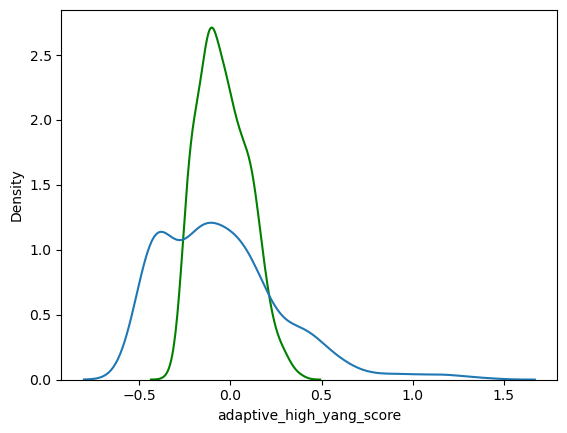

In [71]:
sb.kdeplot(y_pred, color = "g")
sb.kdeplot(y_test)

In [72]:
importances_cb = best_model_cb.feature_importances_
importances_cb = pd.Series(importances_cb, index=prot.columns)
importances_cb=importances_cb.sort_values(ascending=False)

print(importances_cb.head(10))

CD38       4.764584
CD274      3.326395
CD154      2.680028
CD52       2.583189
CD152      2.236641
CD56       2.091977
CD94       2.046986
CD49d      1.909987
CD158e1    1.703384
CD2        1.650526
dtype: float64


In [73]:
#df from the top 20 important markers
importances_cb=pd.DataFrame(importances_cb)
importances_cb_top=importances_cb[0:20]
importances_cb_top=importances_cb_top.T

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


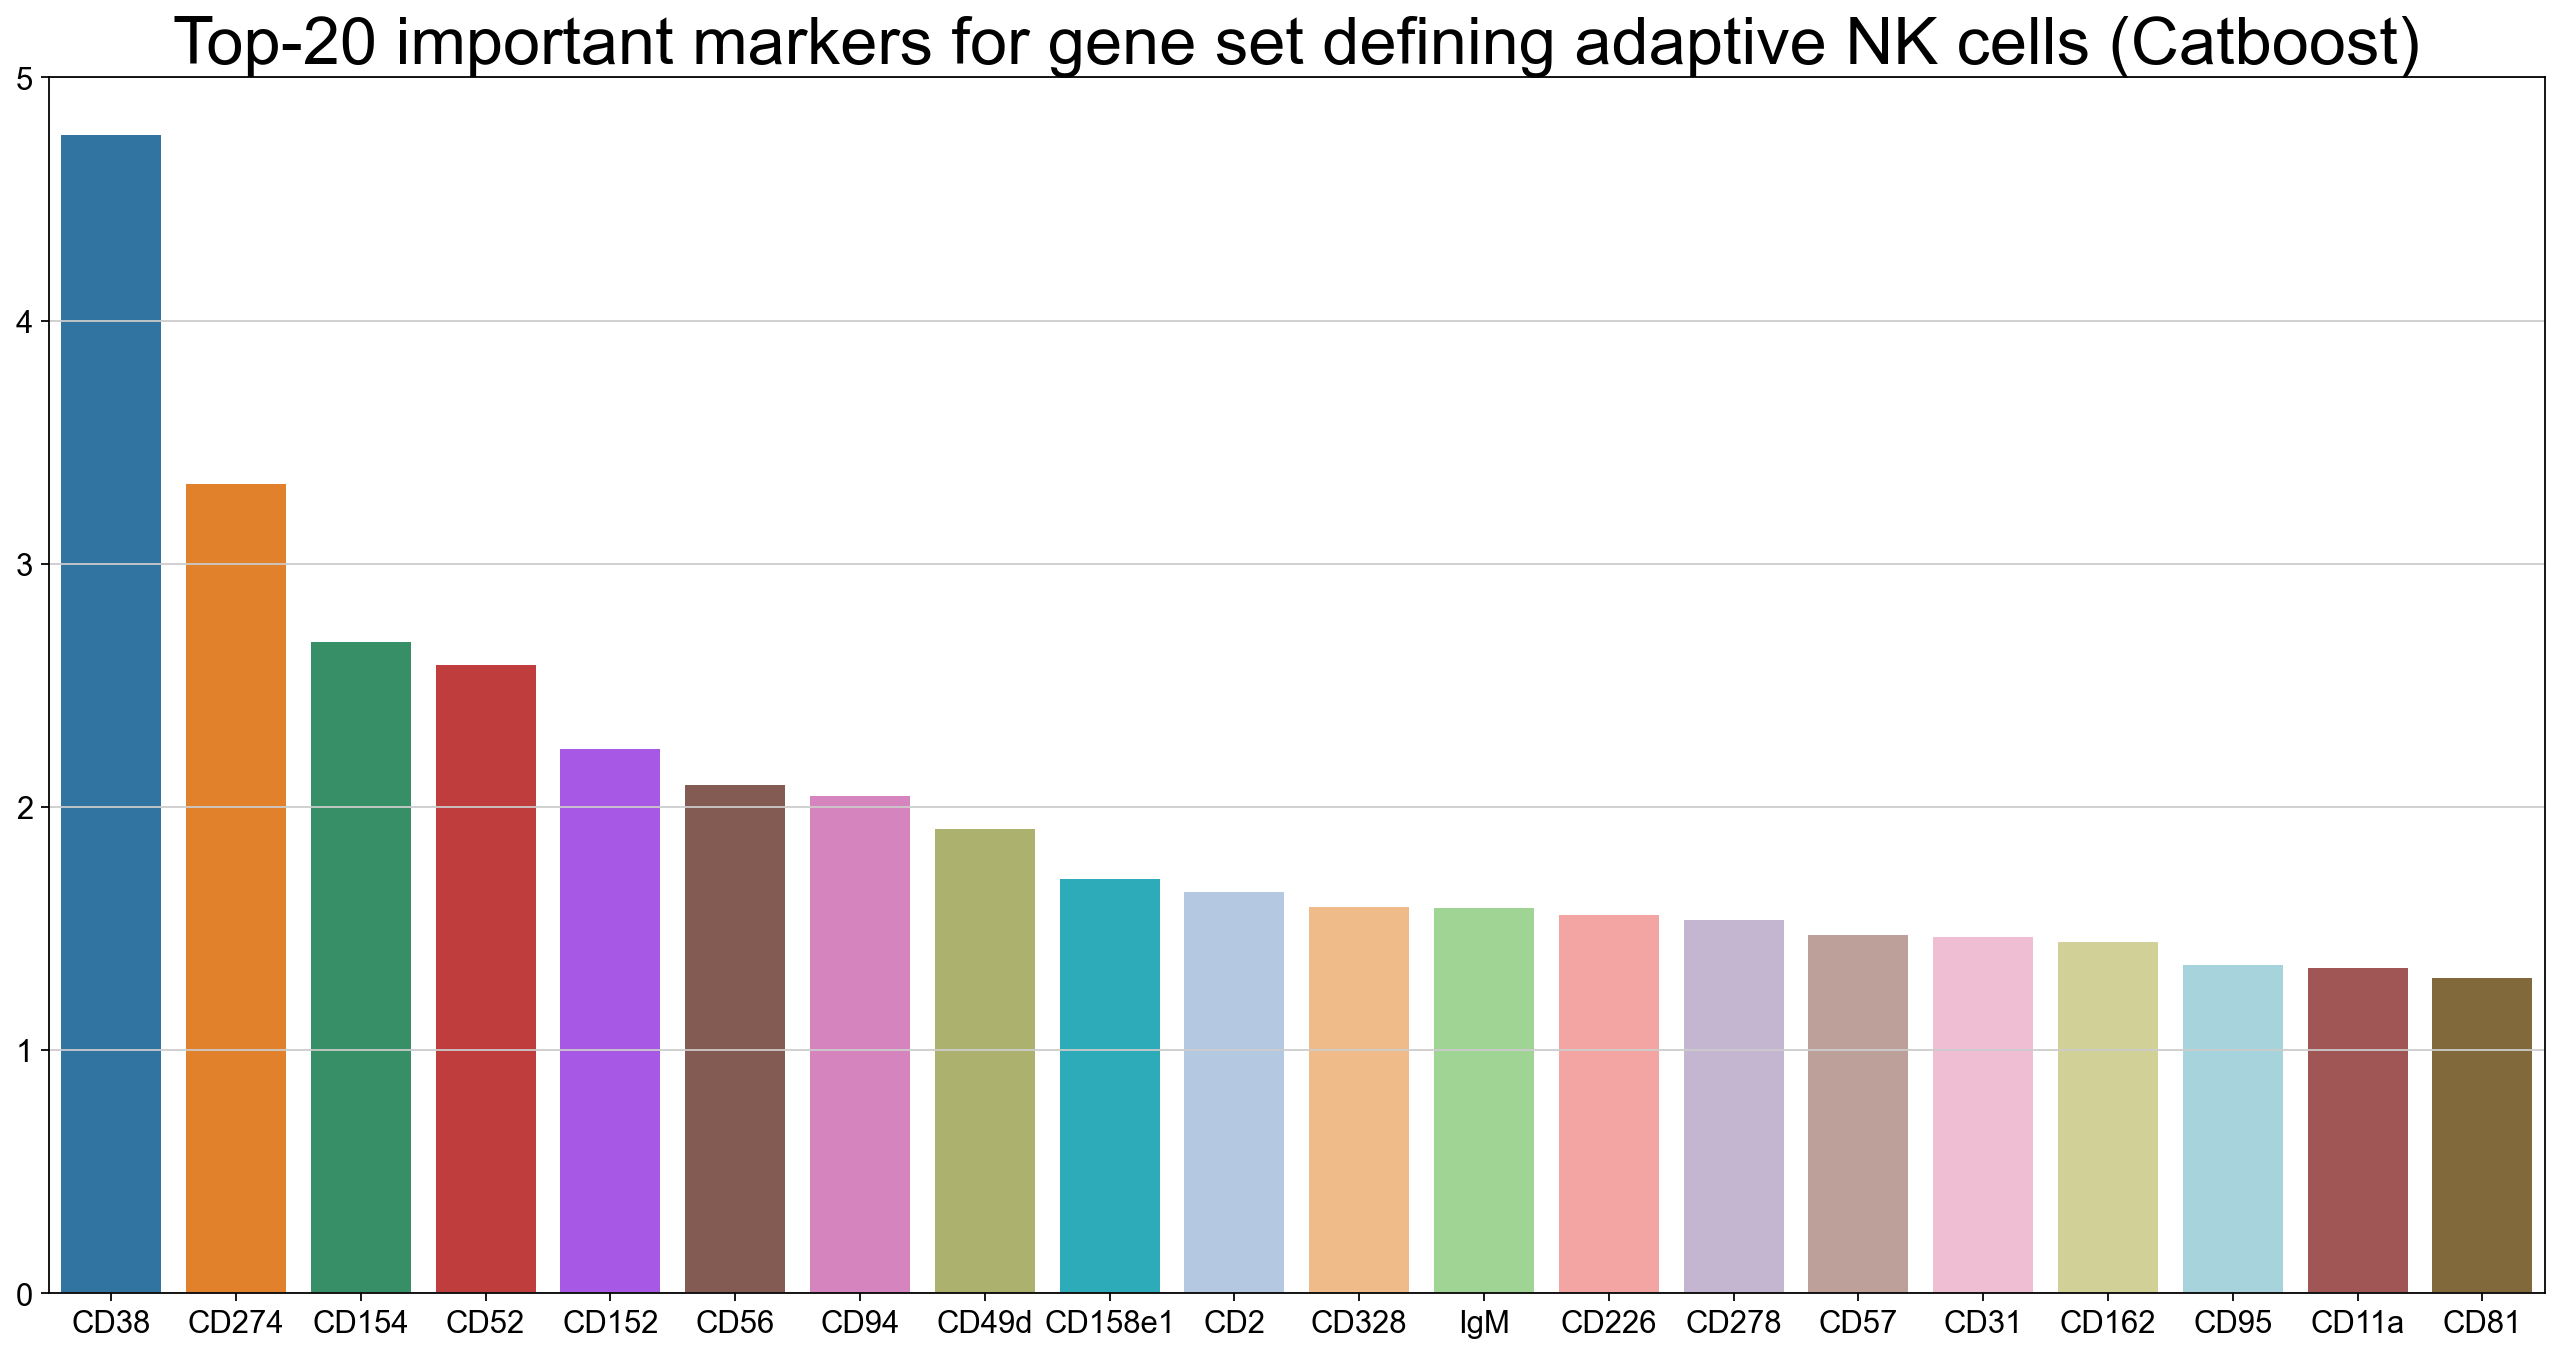

In [137]:
plt.figure(figsize=(20,10))
plt.ylim(0,5)
a=sb.barplot(data=importances_cb_top)

plt.title("Top-20 important markers for gene set defining adaptive NK cells (Catboost)", fontsize = 30) ;




In [127]:
adaptive_prot_markers = 'CD38', 'CD274', 'CD52', 'CD56', 'CD94', 'CD49d', 'CD158e1', 'CD2'

#adaptive_high_yang
#'CD154', CD152


In [79]:
#Computing a neighborhood of observations using latent space

sc.pp.neighbors(adata_neurips, use_rep="X_totalVI")   

sc.tl.umap(adata_neurips)

In [83]:
#selecting one sample from Neurips

sample =eg[eg.obs['POOL'] == "s4d1"].copy()


In [84]:
sample

AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    uns: 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'
  

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


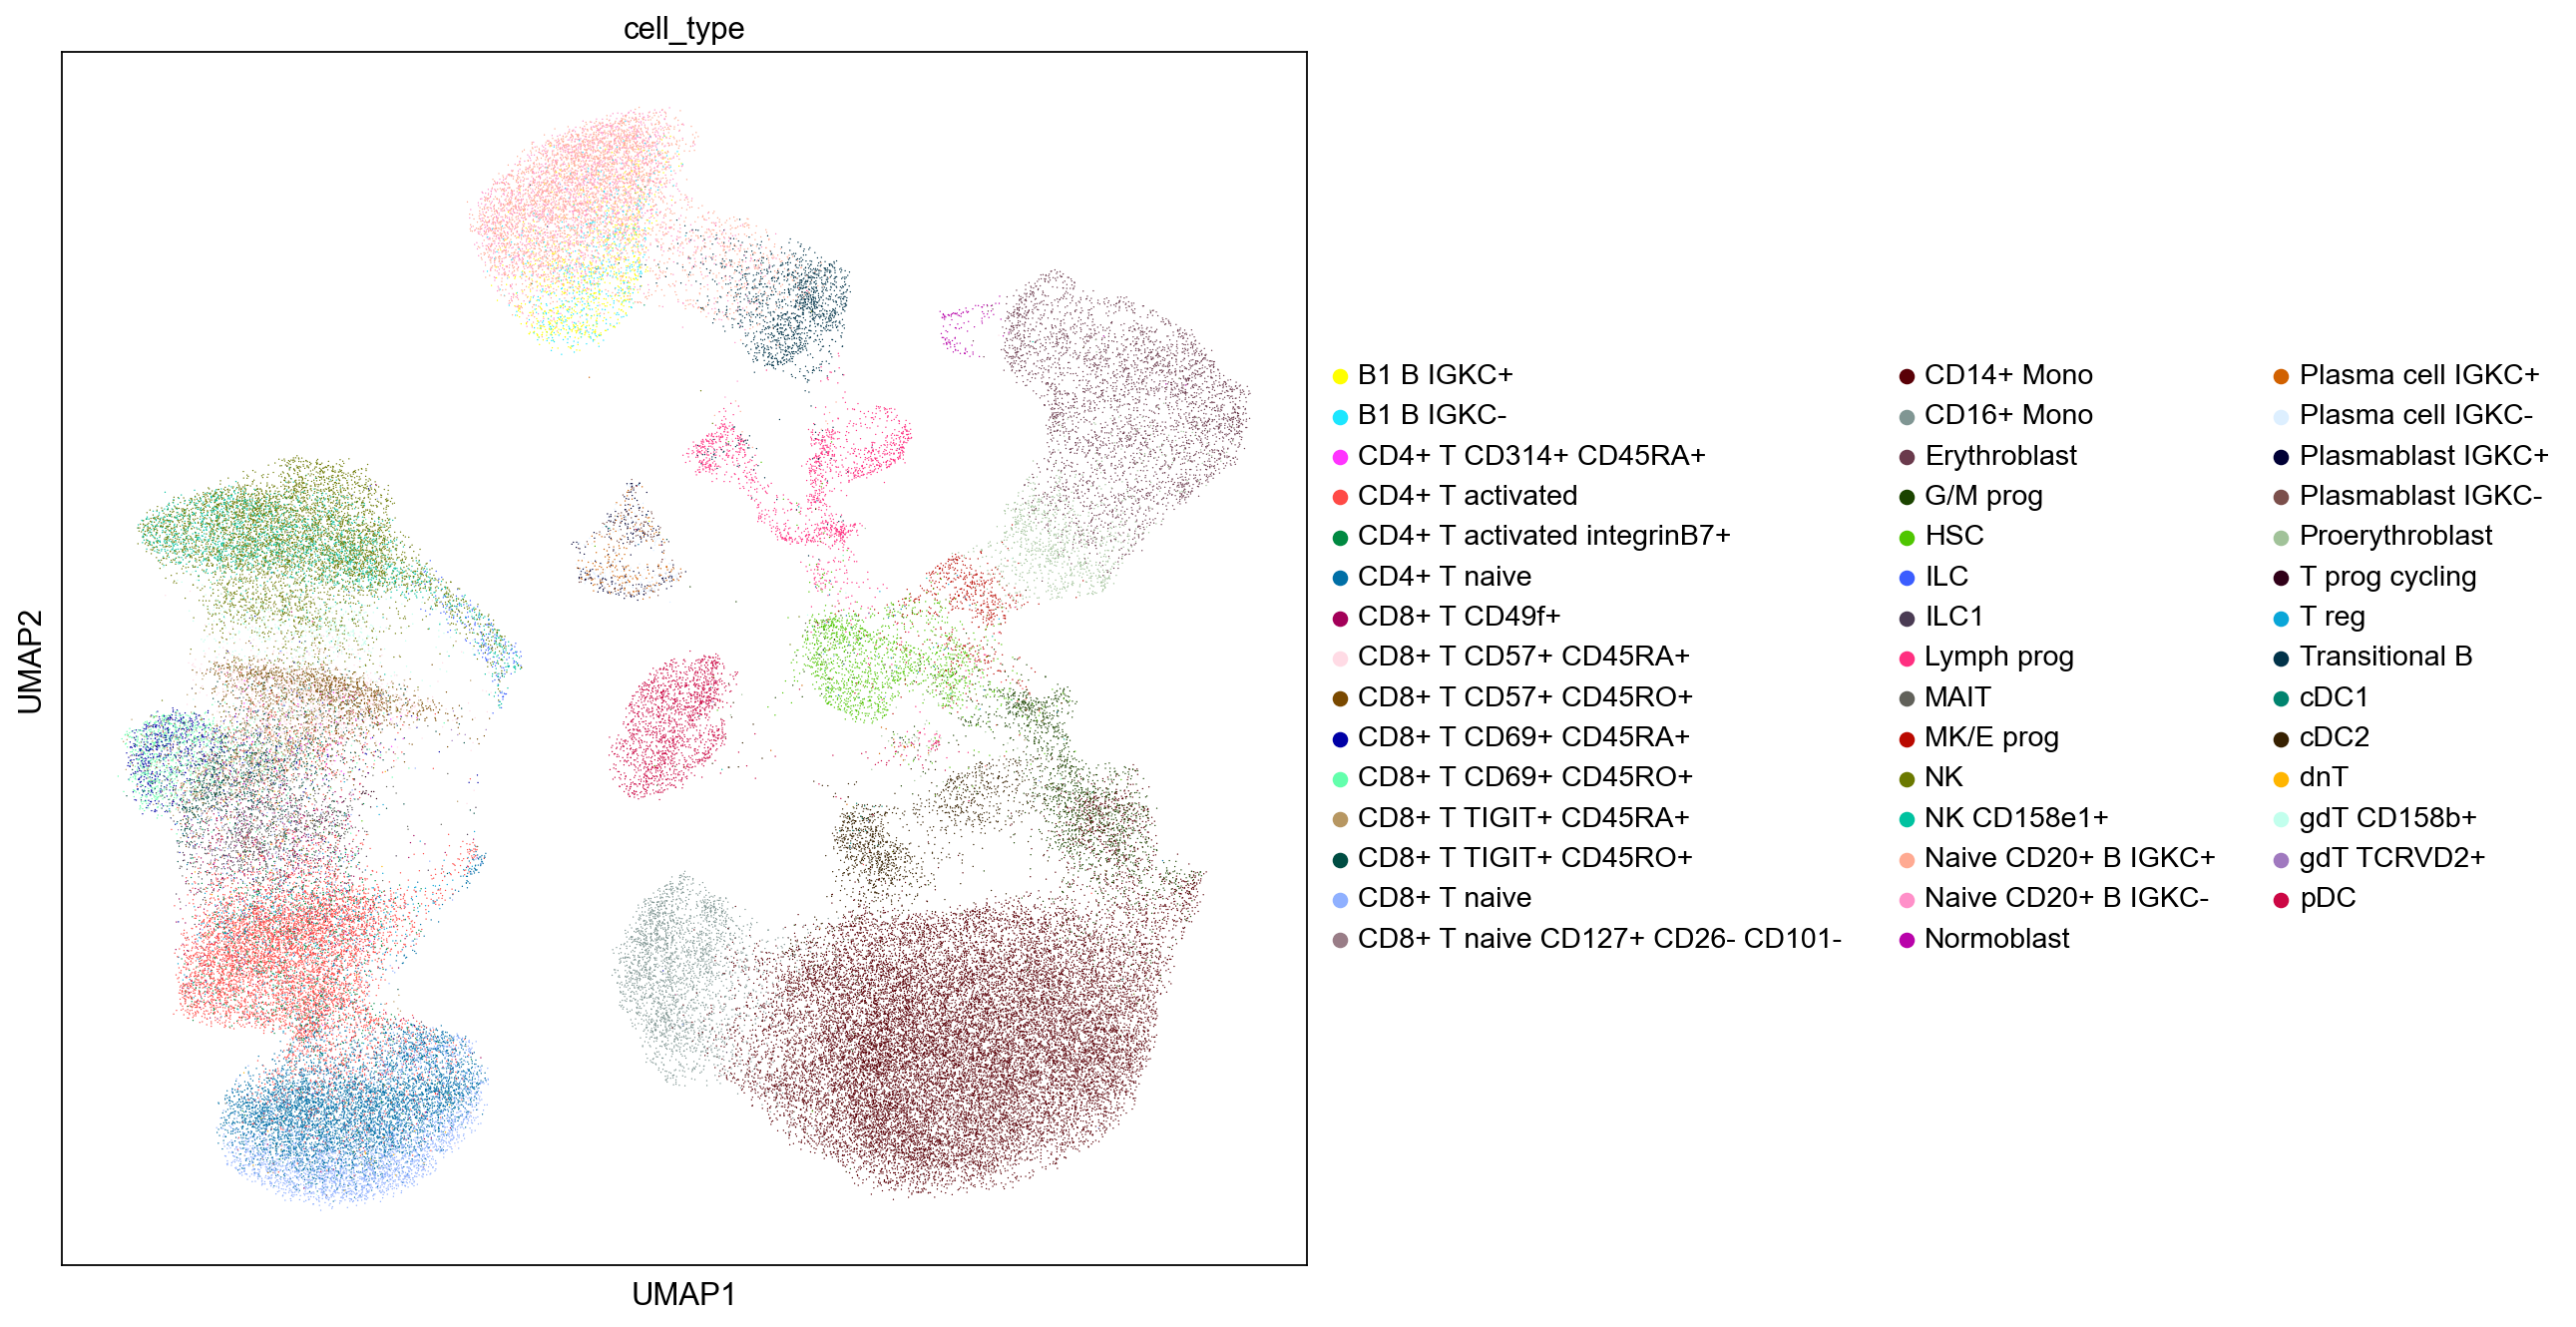

In [88]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_neurips, color = ['cell_type'])

In [92]:
#Computing a neighborhood of observations using latent space

sc.pp.neighbors(sample, use_rep="X_totalVI")   

sc.tl.umap(sample)

/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


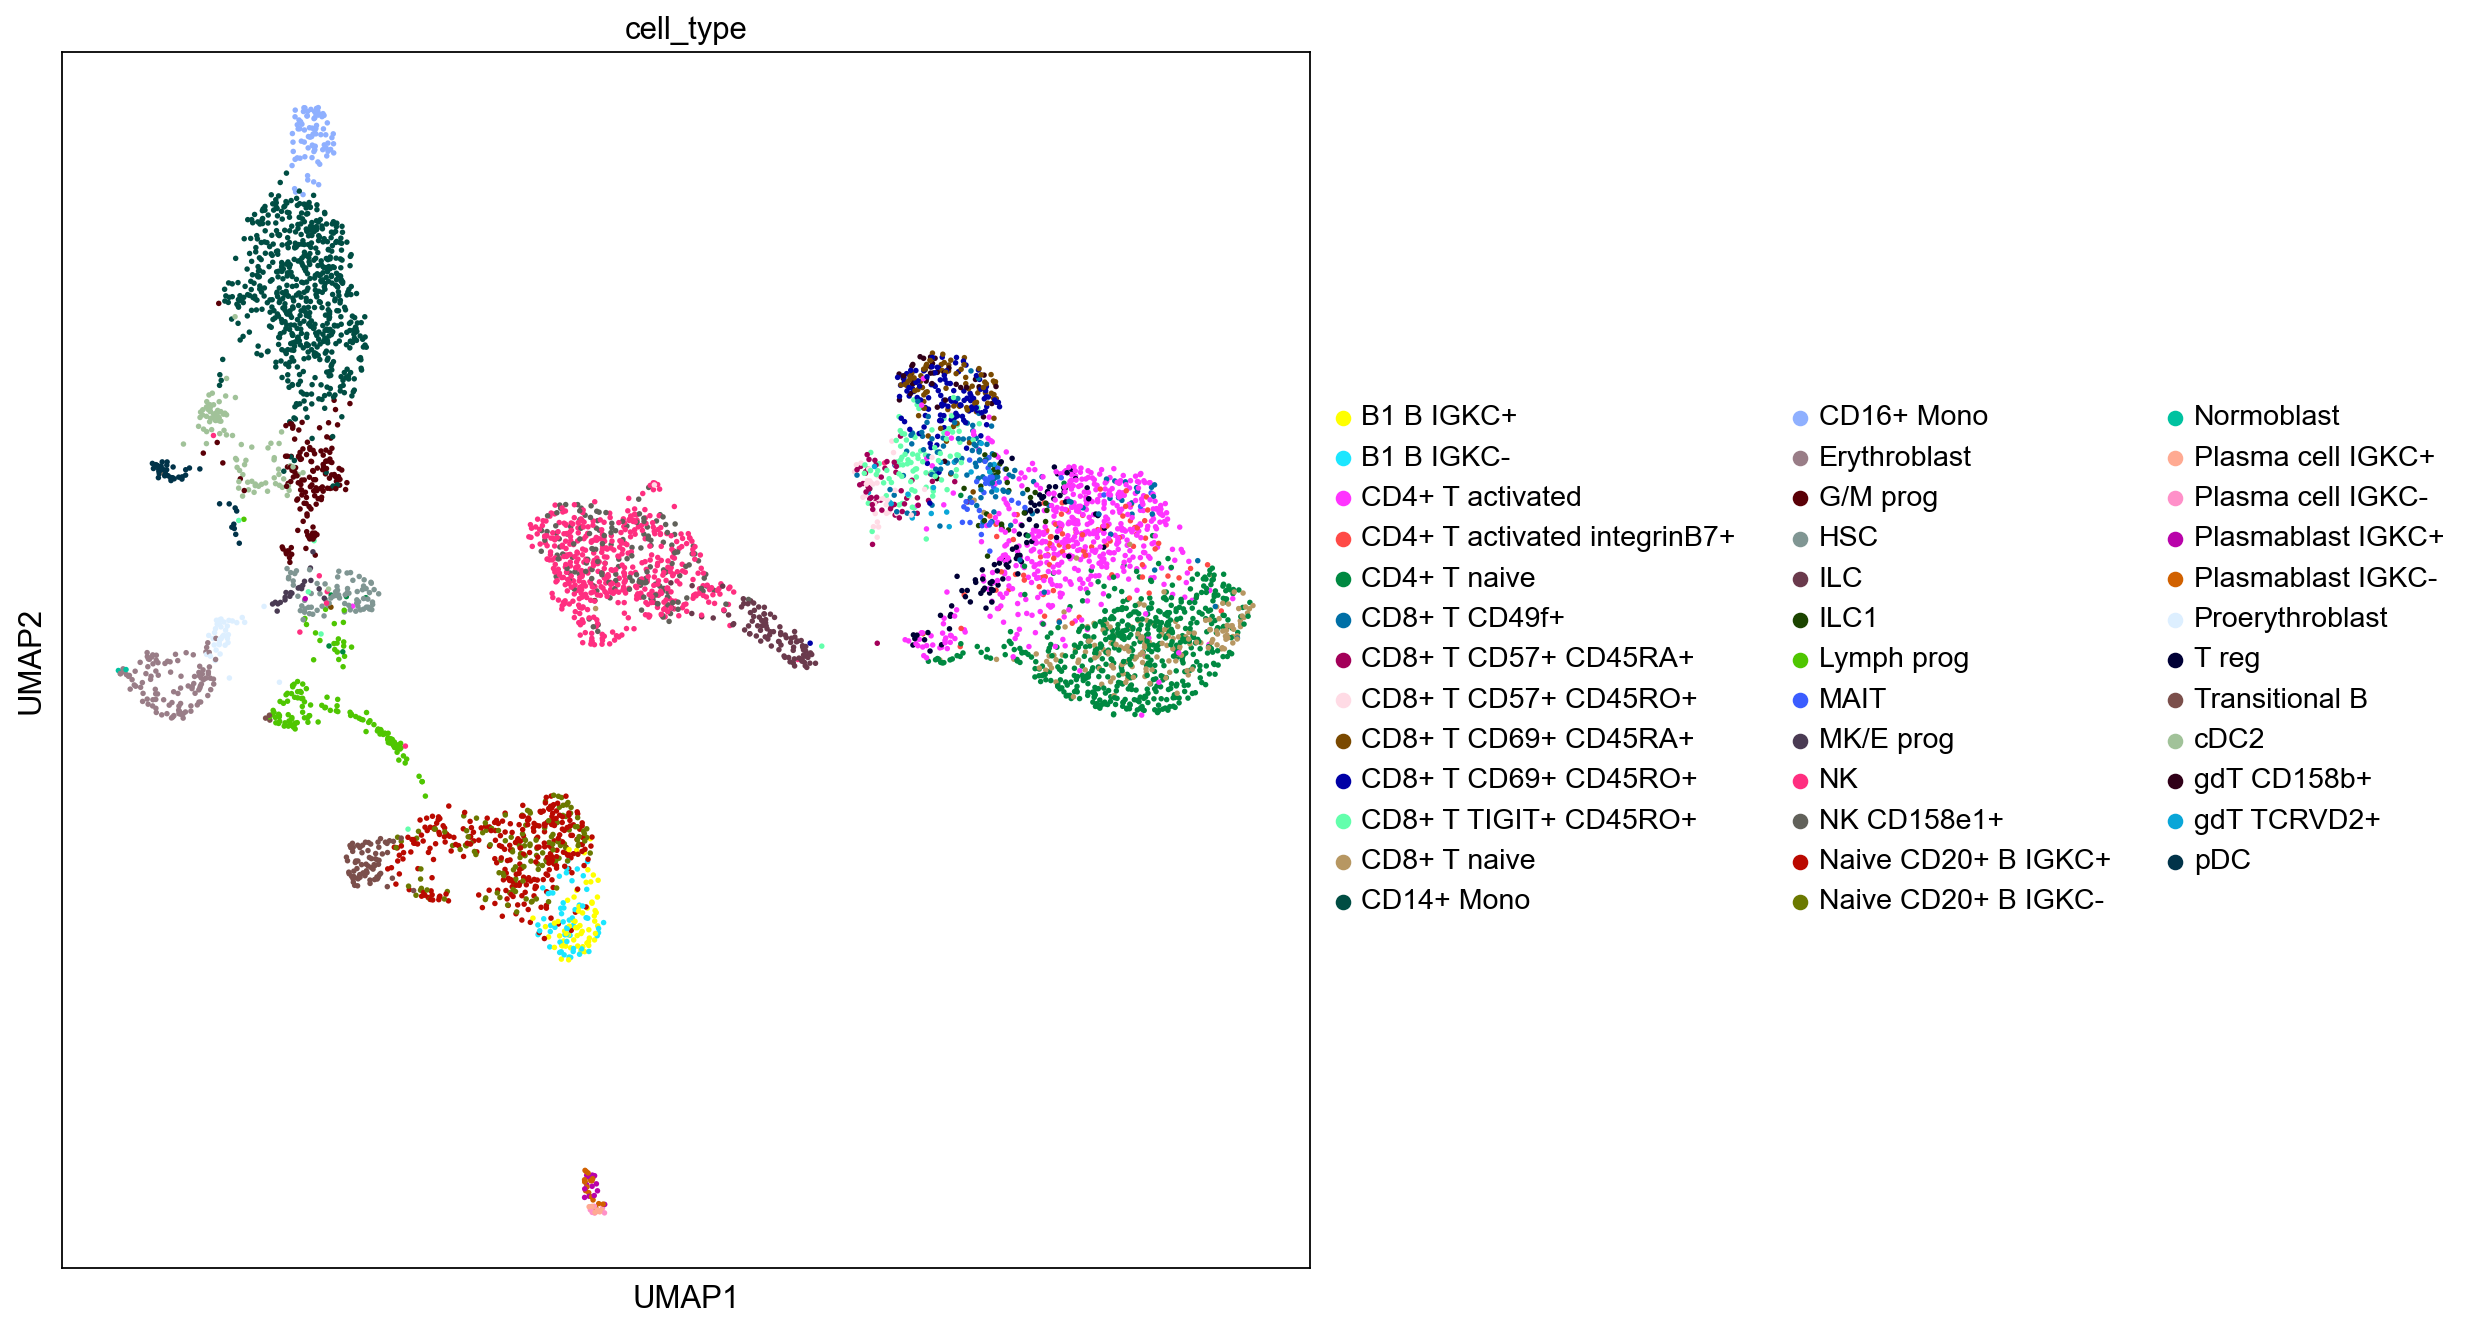

In [93]:
#only one sample

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(sample, color = ['cell_type'])

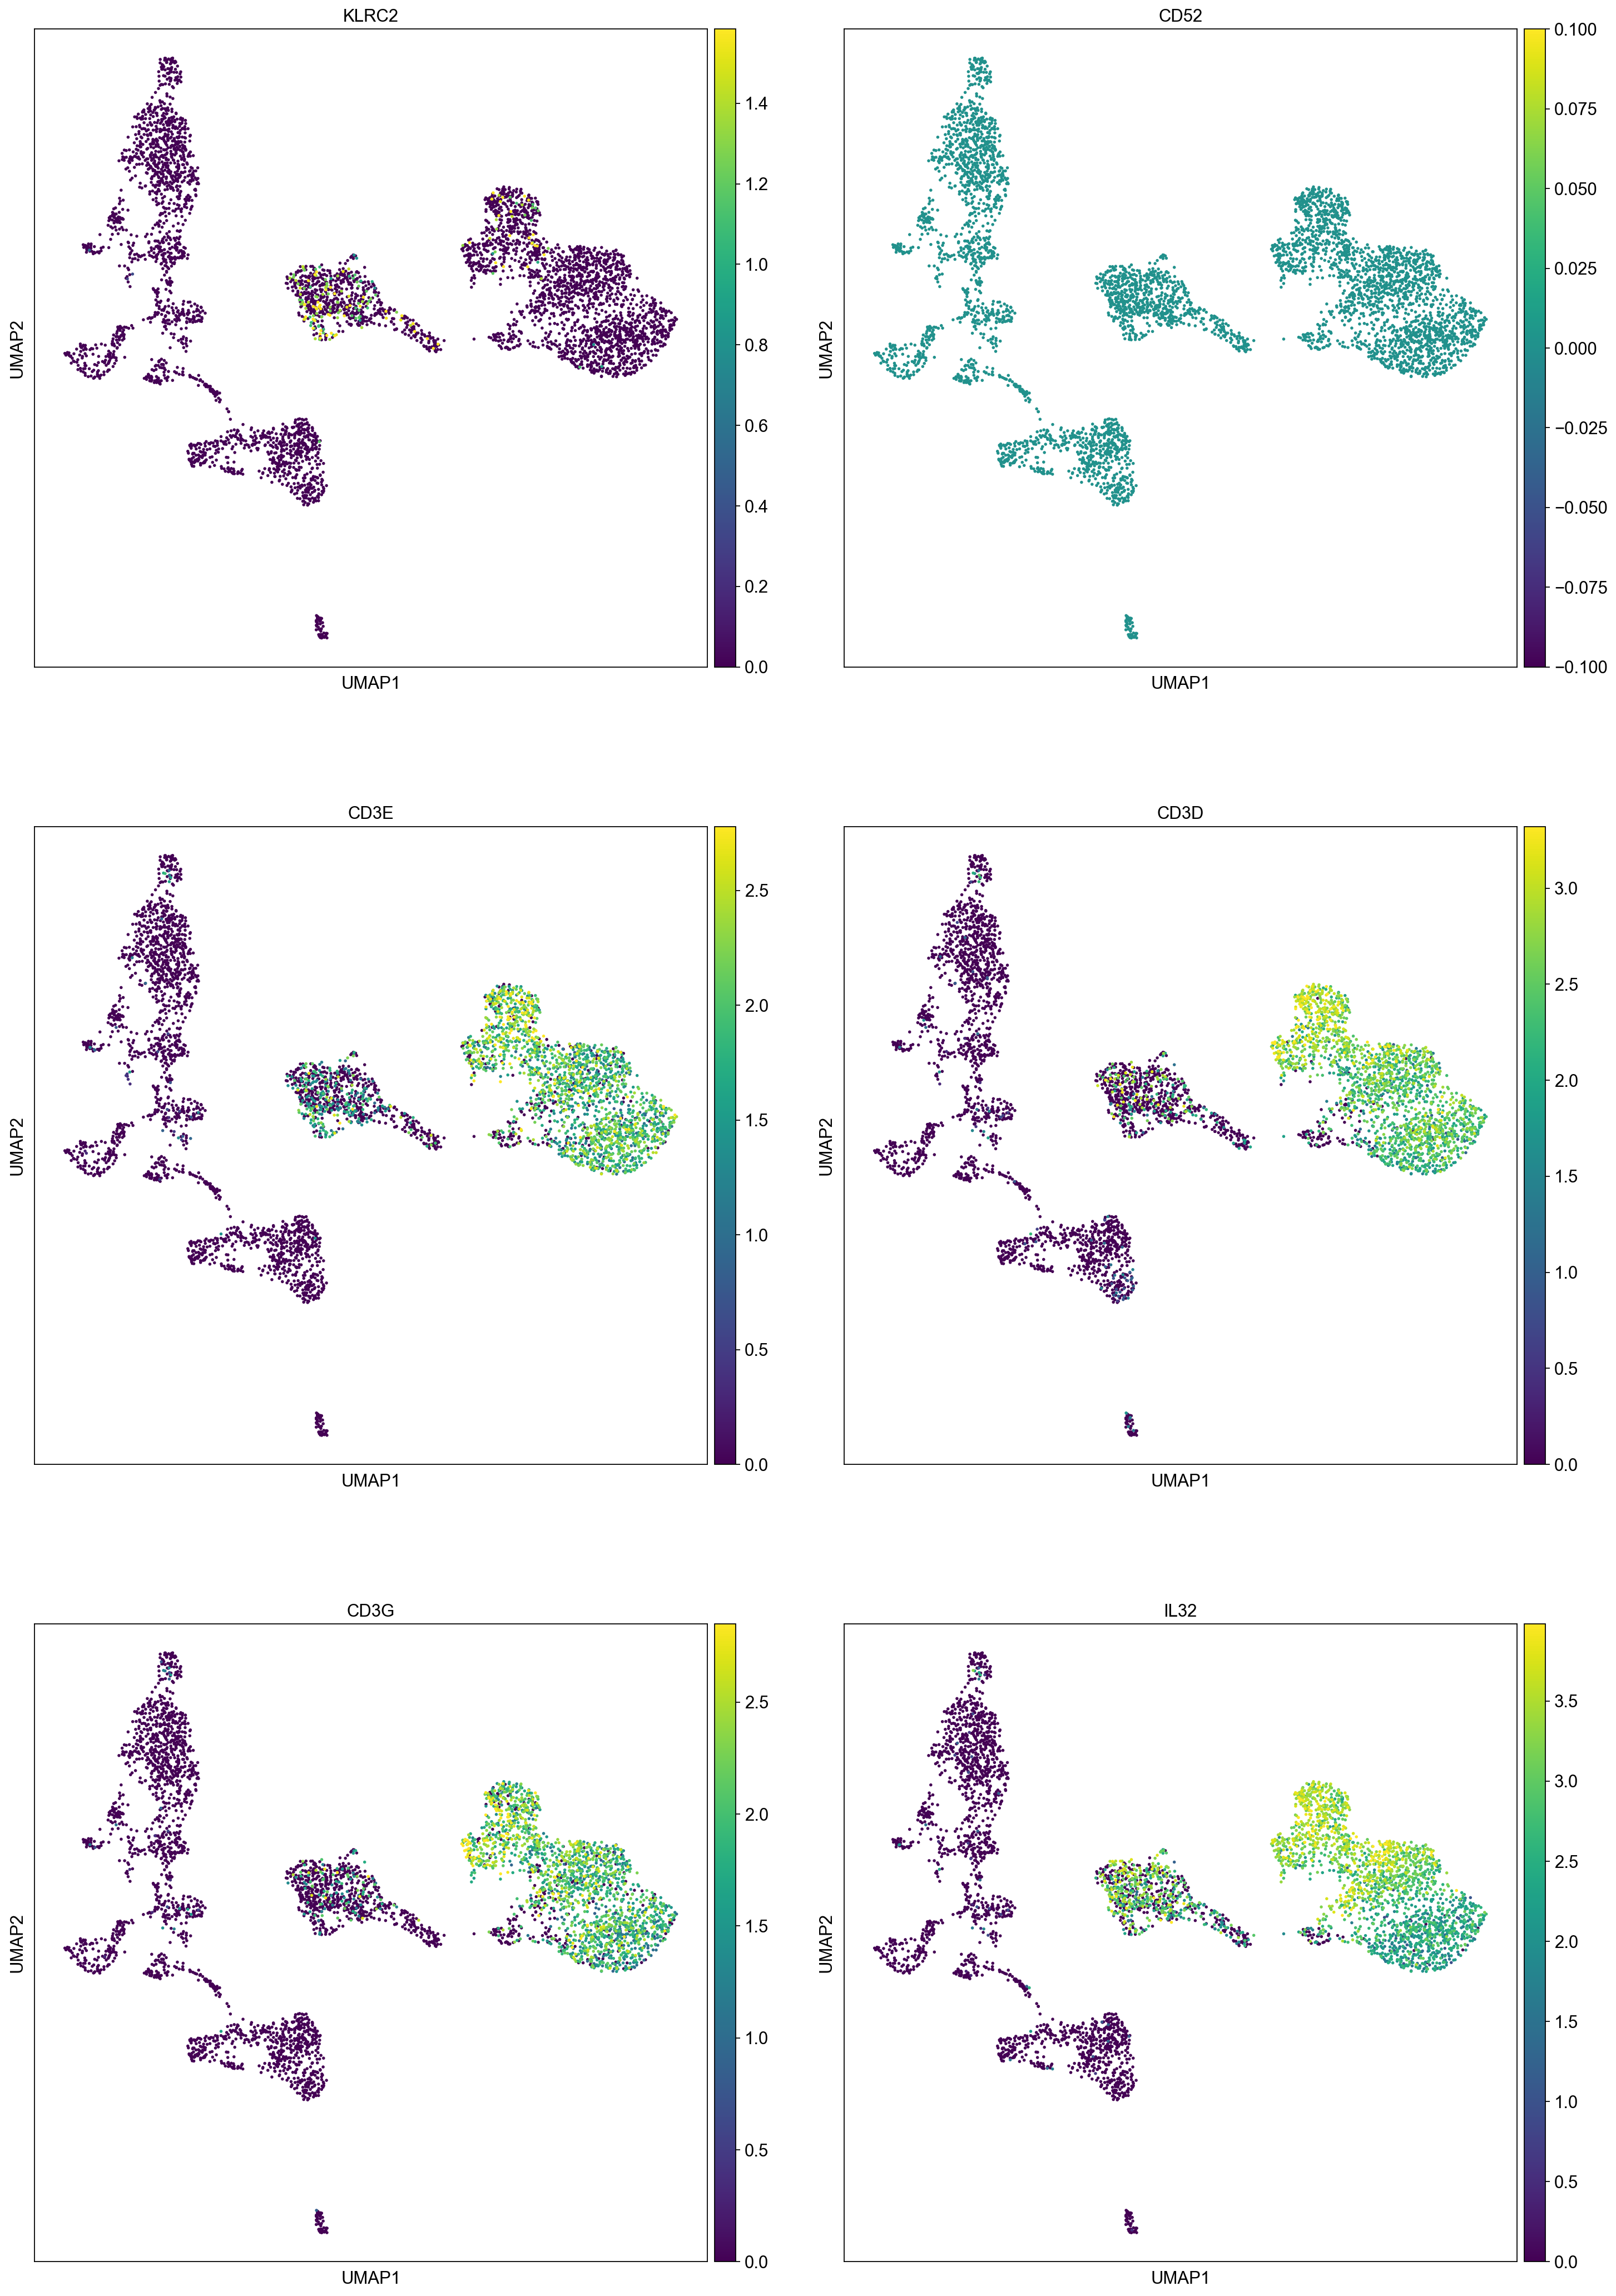

In [121]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(sample, color = adaptive_high_yang,  vmax="p99", ncols = 2)

KeyError: 'Could not find key CD56 in .var_names or .obs.columns.'

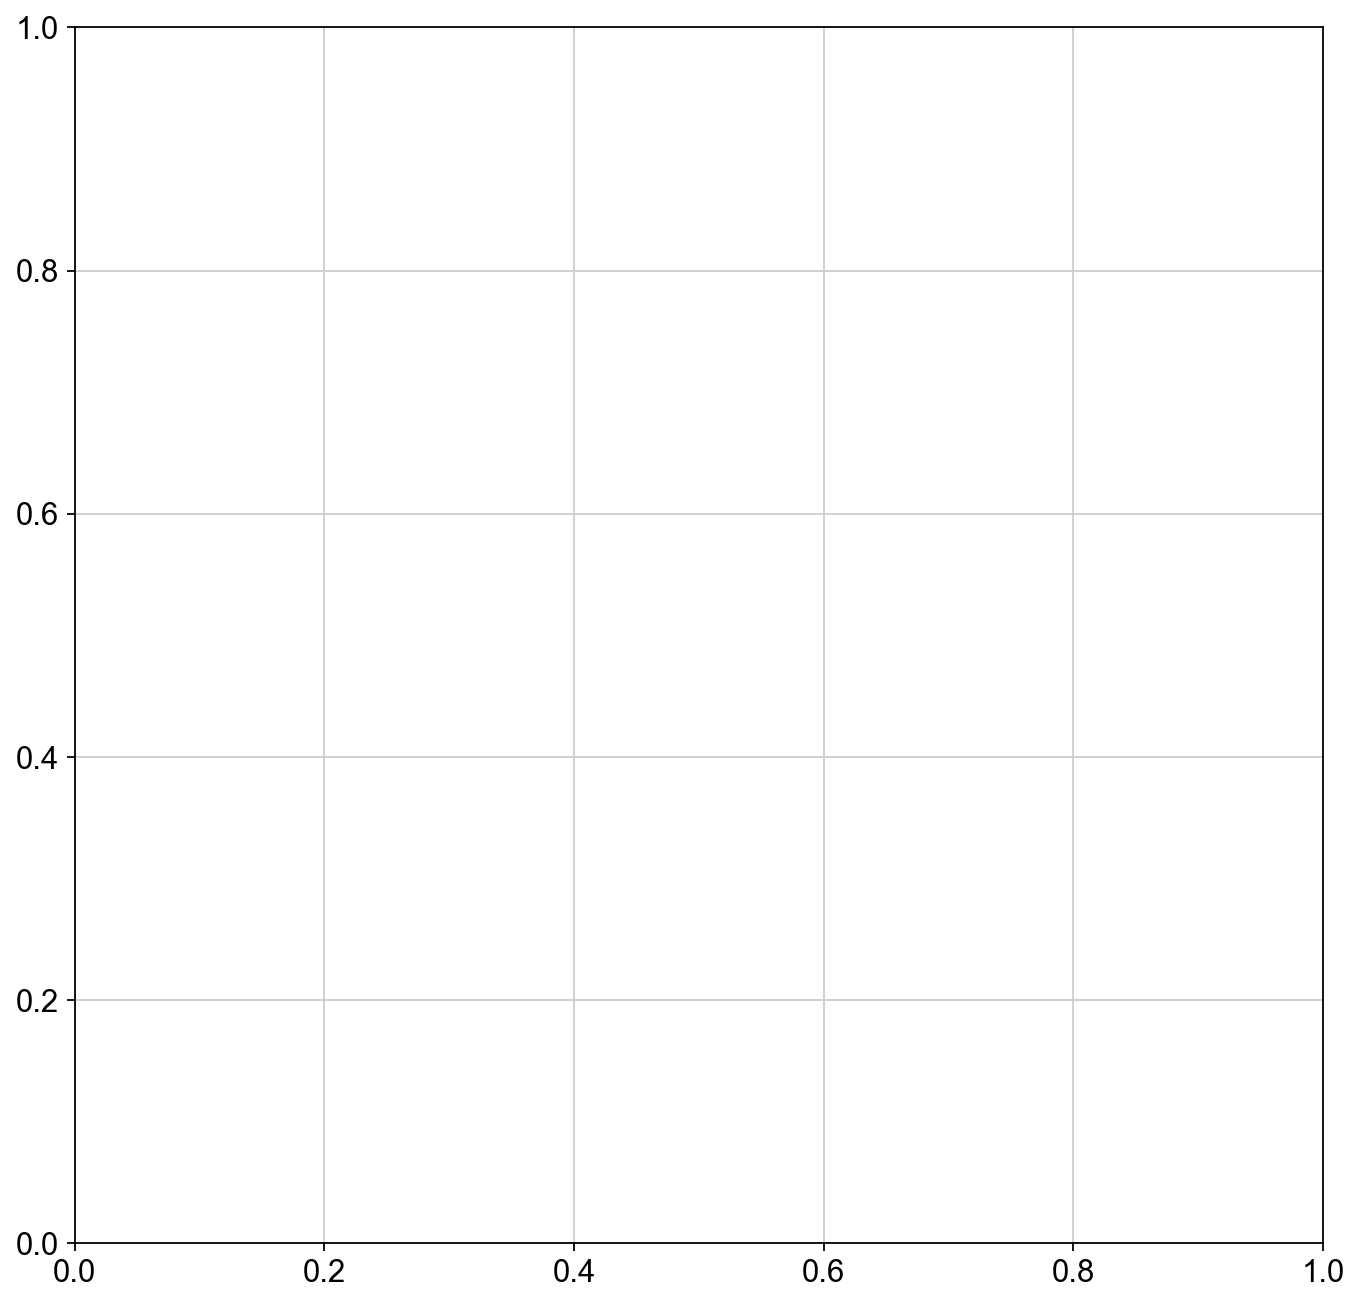

In [136]:
sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(sample, color = ['CD56'], layer = 'protein_expression_clr_neurips')

### Melsen et al. gene sets